In [1]:
import copy
import ctypes
import gc
import itertools
import os
import pickle
import pprint
import random
import re
import time
import warnings
from collections import Counter, defaultdict
from functools import reduce
from itertools import cycle
from random import choice, choices

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# import catboost as cb
import optuna
import pandas as pd
import polars as pl
import seaborn as sns
import sklearn
import torch
import umap
import xgboost as xgb
from catboost import CatBoostRegressor
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from scipy import stats
from scipy.stats import kurtosis, skew
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    preprocessing,
    tree,
)
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

# from gensim.models import Word2Vec
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    PowerTransformer,
    RobustScaler,
)
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm
from tqdm.autonotebook import tqdm
from xgboost import XGBRegressor

libc = ctypes.CDLL("libc.so.6")  # clear the memory

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.__version__

'2.0.3'

In [3]:
lgb.__version__

'3.3.2'

In [136]:
class MyConfig:
    INPUT_DIR = "./data"
    seed = 42
    is_time_in_secs = True
    time_divider = 1000 if is_time_in_secs else 1

    num_folds = 10
    num_estimators = 12001
    num_trials_early_stopping = 200

    response_variate = "score"
    is_local = False
    use_optuna_tuning = True
    test_size_local = 0.2
    num_trials_optuna = 50

    num_features_to_display = 50
    vector_size = 64
    umap_filename = "count_vectoriser_umap2.sav"
    use_lgb_ftr_selection = False  # not using
    num_top_features = 300  # not using

    use_token_features = True
    use_vif_feature_selection = False
    use_info_gain_feature_selection = False

In [137]:
cnfg = MyConfig()

In [6]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(cnfg.seed)

In [7]:
tqdm.pandas()
sns.set_style("whitegrid")
warnings.simplefilter("ignore")
random.seed(cnfg.seed)
np.random.seed(cnfg.seed)

# Import Data

In [8]:
traindf = pd.read_csv(f"{cnfg.INPUT_DIR}/train_logs.csv")
train_scores = pd.read_csv(f"{cnfg.INPUT_DIR}/train_scores.csv")

if cnfg.is_local:
    train_scores, test_scores = train_test_split(
        train_scores,
        test_size=cnfg.test_size_local,
        random_state=cnfg.seed,
        stratify=train_scores.score,
    )
    train_scores = train_scores.reset_index(drop=True)
    test_scores = test_scores.reset_index(drop=True)
    testdf = traindf[traindf.id.isin(test_scores.id.unique())].reset_index(drop=True)
    traindf = traindf[traindf.id.isin(train_scores.id.unique())].reset_index(drop=True)
else:
    testdf = pd.read_csv(f"{cnfg.INPUT_DIR}/test_logs.csv")

In [9]:
traindf.shape, testdf.shape

((8405898, 11), (6, 11))

## Essay Constructor

In [10]:
def getEssays(df):
    # Copy required columns
    textInputDf = df[["id", "activity", "cursor_position", "text_change"]].copy()

    # Get rid of text inputs that make no change
    # Note: Shift was unpreditcable so ignored
    textInputDf = textInputDf[textInputDf.activity != "Nonproduction"]

    # Get how much each Id there is
    valCountsArr = textInputDf["id"].value_counts(sort=False).values

    # Holds the final index of the previous Id
    lastIndex = 0

    # Holds all the essays
    essaySeries = pd.Series()

    # Fills essay series with essays
    for index, valCount in enumerate(valCountsArr):
        # Indexes down_time at current Id
        currTextInput = textInputDf[
            ["activity", "cursor_position", "text_change"]
        ].iloc[lastIndex : lastIndex + valCount]

        # Update the last index
        lastIndex += valCount

        # Where the essay content will be stored
        essayText = ""

        # Produces the essay
        for Input in currTextInput.values:
            # Input[0] = activity
            # Input[2] = cursor_position
            # Input[3] = text_change

            # If activity = Replace
            if Input[0] == "Replace":
                # splits text_change at ' => '
                replaceTxt = Input[2].split(" => ")

                # DONT TOUCH
                essayText = (
                    essayText[: Input[1] - len(replaceTxt[1])]
                    + replaceTxt[1]
                    + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]) :]
                )
                continue

            # If activity = Paste
            if Input[0] == "Paste":
                # DONT TOUCH
                essayText = (
                    essayText[: Input[1] - len(Input[2])]
                    + Input[2]
                    + essayText[Input[1] - len(Input[2]) :]
                )
                continue

            # If activity = Remove/Cut
            if Input[0] == "Remove/Cut":
                # DONT TOUCH
                essayText = (
                    essayText[: Input[1]] + essayText[Input[1] + len(Input[2]) :]
                )
                continue

            # If activity = Move...
            if "M" in Input[0]:
                # Gets rid of the "Move from to" text
                croppedTxt = Input[0][10:]

                # Splits cropped text by ' To '
                splitTxt = croppedTxt.split(" To ")

                # Splits split text again by ', ' for each item
                valueArr = [item.split(", ") for item in splitTxt]

                # Move from [2, 4] To [5, 7] = (2, 4, 5, 7)
                moveData = (
                    int(valueArr[0][0][1:]),
                    int(valueArr[0][1][:-1]),
                    int(valueArr[1][0][1:]),
                    int(valueArr[1][1][:-1]),
                )

                # Skip if someone manages to activiate this by moving to same place
                if moveData[0] != moveData[2]:
                    # Check if they move text forward in essay (they are different)
                    if moveData[0] < moveData[2]:
                        # DONT TOUCH
                        essayText = (
                            essayText[: moveData[0]]
                            + essayText[moveData[1] : moveData[3]]
                            + essayText[moveData[0] : moveData[1]]
                            + essayText[moveData[3] :]
                        )
                    else:
                        # DONT TOUCH
                        essayText = (
                            essayText[: moveData[2]]
                            + essayText[moveData[0] : moveData[1]]
                            + essayText[moveData[2] : moveData[0]]
                            + essayText[moveData[1] :]
                        )
                continue

            # If just input
            # DONT TOUCH
            essayText = (
                essayText[: Input[1] - len(Input[2])]
                + Input[2]
                + essayText[Input[1] - len(Input[2]) :]
            )

        # Sets essay at index
        essaySeries[index] = essayText

    # Sets essay series index to the ids
    essaySeries.index = textInputDf["id"].unique()

    # Returns the essay series
    return essaySeries

In [11]:
%%time
train_essays = getEssays(traindf)

CPU times: user 4min 31s, sys: 1min 39s, total: 6min 10s
Wall time: 6min 10s


In [12]:
test_essays = getEssays(testdf)

In [13]:
train_essaysdf = pd.DataFrame({"id": train_essays.index, "essay": train_essays.values})
test_essaysdf = pd.DataFrame({"id": test_essays.index, "essay": test_essays.values})

In [14]:
merged_data = train_essaysdf.merge(train_scores, on="id")

## Using Tokenizer

In [15]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
# count_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_tokenizer_train = count_vectorizer.fit_transform(merged_data["essay"])
X_tokenizer_test = count_vectorizer.transform(test_essaysdf["essay"])

In [16]:
# dim_reduction_model = umap.UMAP(
#     n_components=64, metric="hellinger", random_state=cnfg.seed
# )
# dim_reduction_model = dim_reduction_model.fit(X_tokenizer_train)
# joblib.dump(dim_reduction_model, cnfg.umap_filename)

In [17]:
# dim_reduction_model = joblib.load(cnfg.umap_filename)

In [18]:
# dim_reduction_model = TruncatedSVD(n_components=64, n_iter=10, random_state=cnfg.seed)
# dim_reduction_model = dim_reduction_model.fit(X_tokenizer_train)

In [19]:
# dim_reduction_model

In [20]:
X_tokenizer_train.shape

(2471, 291)

In [21]:
X_tokenizer_test.shape

(3, 291)

In [22]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [23]:
X_tokenizer_train = np.array(X_tokenizer_train.todense())
X_tokenizer_test = np.array(X_tokenizer_test.todense())

In [24]:
# X_tokenizer_train = dim_reduction_model.transform(X_tokenizer_train)
# X_tokenizer_test = dim_reduction_model.transform(X_tokenizer_test)

In [25]:
X_tokenizer_train.shape, X_tokenizer_test.shape

((2471, 291), (3, 291))

## Create Features from the tokenizer

In [26]:
df_train = pd.DataFrame(
    X_tokenizer_train,
    columns=[f"token_feature_{i}" for i in range(X_tokenizer_train.shape[1])],
)

In [27]:
df_test = pd.DataFrame(
    X_tokenizer_test,
    columns=[f"token_feature_{i}" for i in range(X_tokenizer_test.shape[1])],
)

In [28]:
df_train_index = train_essaysdf["id"]
df_test_index = test_essaysdf["id"]

In [29]:
df_train.loc[:, "id"] = df_train_index
df_test.loc[:, "id"] = df_test_index

In [30]:
df_train

,token_feature_0,token_feature_1,token_feature_2,token_feature_3,token_feature_4,token_feature_5,token_feature_6,token_feature_7,token_feature_8,token_feature_9,...,token_feature_282,token_feature_283,token_feature_284,token_feature_285,token_feature_286,token_feature_287,token_feature_288,token_feature_289,token_feature_290,id
0,53,8,12,8,6,8,1,4,4,2,...,0,0,0,0,0,0,0,0,0,001519c8
1,61,8,12,19,11,5,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0022f953
2,64,6,8,8,6,6,4,10,4,4,...,0,0,0,0,0,0,0,0,0,0042269b
3,44,6,7,8,4,6,6,1,1,2,...,0,0,0,0,0,0,0,0,0,0059420b
4,49,3,15,11,9,2,3,3,0,1,...,0,0,0,0,0,0,0,0,0,0075873a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,49,5,4,9,13,7,7,0,1,0,...,0,0,0,0,0,0,0,0,0,ffb8c745
2467,74,16,9,21,10,7,4,4,1,1,...,0,0,0,0,0,0,0,0,0,ffbef7e5
2468,42,5,9,8,7,5,3,1,1,1,...,0,0,0,0,0,0,0,0,0,ffccd6fd
2469,80,5,19,12,11,6,11,2,1,5,...,0,0,0,0,0,0,0,0,0,ffec5b38


In [31]:
# df_train

In [32]:
# count_vectorizer.vocabulary_

# Feature Engineering

In [33]:
train_agg_fe_df = traindf.groupby("id")[
    ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
].agg(["mean", "std", "min", "max", "last", "first", "sem", "median", "sum"])
train_agg_fe_df.columns = ["_".join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

In [34]:
test_agg_fe_df = testdf.groupby("id")[
    ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
].agg(["mean", "std", "min", "max", "last", "first", "sem", "median", "sum"])
test_agg_fe_df.columns = ["_".join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

### Word2Vec ###

In [35]:
train_sentences = train_essaysdf.essay.apply(
    lambda x: [k.strip() for k in x.split(" ") if k != ""]
)

In [36]:
test_sentences = test_essaysdf.essay.apply(
    lambda x: [k.strip() for k in x.split(" ") if k != ""]
)

In [37]:
model_w2vec = Word2Vec(
    # sentences=train_sentences,
    vector_size=cnfg.vector_size,
    window=5,
    min_count=1,
    workers=1,
    alpha=0.03,
    seed=cnfg.seed,
    sg=1,
)
model_w2vec.build_vocab(train_sentences, progress_per=10000)
model_w2vec.train(
    train_sentences, total_examples=model_w2vec.corpus_count, epochs=200, report_delay=1
)

(37325859, 191407600)

In [38]:
def get_w2vec_embeddings(mdl, sentences, vector_size=64):
    all_embd_final = []
    not_found_words = []
    for i in tqdm(range(len(sentences))):
        all_embd = []
        for j in range(len(sentences[i])):
            try:
                emb = mdl.wv[sentences[i][j]]
                all_embd.append(emb)
            except:
                all_embd.append(np.zeros(vector_size))
                not_found_words.append(sentences[i][j])
        if all_embd == []:
            embd_final = np.zeros(vector_size)
        else:
            embd_final = np.mean(all_embd, axis=0)
        all_embd_final.append(embd_final)
    embd_df = pd.DataFrame(
        all_embd_final, columns=[f"w2vec_dim_{k}" for k in range(vector_size)]
    )
    return embd_df, not_found_words

In [39]:
embd_df_train, not_found_words_train = get_w2vec_embeddings(
    model_w2vec, train_sentences, vector_size=cnfg.vector_size
)
embd_df_train["id"] = train_essaysdf.id

100%|██████████████████████████████████████| 2471/2471 [00:04<00:00, 523.79it/s]


In [40]:
embd_df_test, not_found_words_test = get_w2vec_embeddings(
    model_w2vec, test_sentences, vector_size=cnfg.vector_size
)
embd_df_test["id"] = test_essaysdf.id

100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 10913.19it/s]


In [41]:
df_train = df_train.merge(embd_df_train, on="id")
df_test = df_test.merge(embd_df_test, on="id")

In [42]:
df_train.shape, df_test.shape

((2471, 356), (3, 356))

In [43]:
embd_df_train

,w2vec_dim_0,w2vec_dim_1,w2vec_dim_2,w2vec_dim_3,w2vec_dim_4,w2vec_dim_5,w2vec_dim_6,w2vec_dim_7,w2vec_dim_8,w2vec_dim_9,...,w2vec_dim_55,w2vec_dim_56,w2vec_dim_57,w2vec_dim_58,w2vec_dim_59,w2vec_dim_60,w2vec_dim_61,w2vec_dim_62,w2vec_dim_63,id
0,-0.163211,0.053758,0.090599,-0.087247,0.020114,0.043409,-0.089194,-0.217305,-0.130540,-0.142931,...,-0.213399,0.100732,-0.187446,-0.115796,0.100578,0.073946,-0.062290,0.124507,-0.002383,001519c8
1,-0.163441,0.047015,0.101760,-0.087787,0.015313,0.048601,-0.106448,-0.190701,-0.108752,-0.170442,...,-0.207380,0.092634,-0.179361,-0.128312,0.105183,0.068009,-0.050576,0.145595,0.005468,0022f953
2,-0.167828,0.056987,0.090904,-0.089623,0.024170,0.033839,-0.089207,-0.223916,-0.142777,-0.138005,...,-0.203529,0.103882,-0.199257,-0.112578,0.097584,0.078825,-0.062264,0.113889,-0.008181,0042269b
3,-0.152282,0.059582,0.083083,-0.062713,0.017886,0.049836,-0.096937,-0.225761,-0.124013,-0.142137,...,-0.214734,0.107338,-0.184785,-0.133818,0.088074,0.066080,-0.066583,0.128194,-0.015529,0059420b
4,-0.160334,0.047725,0.101900,-0.081917,0.007104,0.040934,-0.103261,-0.203890,-0.128997,-0.157816,...,-0.212414,0.098170,-0.166072,-0.136107,0.083777,0.085283,-0.059871,0.151312,0.017864,0075873a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,-0.157765,0.042559,0.084338,-0.080772,0.016056,0.031425,-0.098200,-0.216687,-0.137002,-0.146867,...,-0.206039,0.096302,-0.182458,-0.117743,0.091600,0.065920,-0.058101,0.131916,0.006535,ffb8c745
2467,-0.172820,0.032194,0.084362,-0.072825,0.013422,0.035233,-0.094622,-0.198171,-0.131490,-0.158081,...,-0.217391,0.088738,-0.175479,-0.111753,0.075285,0.066296,-0.066712,0.143726,0.013500,ffbef7e5
2468,-0.156528,0.059451,0.077127,-0.092394,0.019304,0.045011,-0.096665,-0.225501,-0.135413,-0.137586,...,-0.208484,0.110765,-0.189618,-0.118339,0.109251,0.071249,-0.054576,0.111493,-0.006799,ffccd6fd
2469,-0.160633,0.051161,0.090953,-0.086651,0.024145,0.032667,-0.093217,-0.227831,-0.143371,-0.139928,...,-0.196231,0.100821,-0.185050,-0.123955,0.090747,0.076655,-0.073427,0.124642,-0.005774,ffec5b38


In [44]:
class Preprocessor:
    def __init__(self, seed):
        self.seed = seed

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.events = [
            "q",
            "Space",
            "Backspace",
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            ".",
            ",",
            "ArrowDown",
            "ArrowUp",
            "Enter",
            "CapsLock",
            "'",
            "Delete",
            "Unidentified",
        ]
        self.text_changes = [
            "q",
            " ",
            "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.punctuations = [
            '"',
            ".",
            ",",
            "'",
            "-",
            ";",
            ":",
            "?",
            "!",
            "<",
            ">",
            "/",
            "@",
            "#",
            "$",
            "%",
            "^",
            "&",
            "*",
            "(",
            ")",
            "_",
            "+",
        ]
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]

        self.idf = defaultdict(float)

    #         self.gaps = [1, 2]

    def match_punctuations(self, df):
        tmp_df = df.groupby("id").agg({"down_event": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["down_event"].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({"punct_cnt": ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[
            (~df["text_change"].str.contains("=>")) & (df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        tmp_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
        tmp_df["text_change"] = tmp_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        tmp_df["input_word_count"] = tmp_df["text_change"].apply(len)
        tmp_df["input_word_length_mean"] = tmp_df["text_change"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_max"] = tmp_df["text_change"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_std"] = tmp_df["text_change"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df.drop(["text_change"], axis=1, inplace=True)
        return tmp_df

    def make_feats(self, df):
        print("Starting to engineer features")

        # initialize features dataframe
        feats = pd.DataFrame({"id": df["id"].unique().tolist()})

        # get shifted features
        # time shift
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"up_time_shift{gap}"] = df.groupby("id")["up_time"].shift(gap)
            df[f"action_time_gap{gap}"] = df["down_time"] - df[f"up_time_shift{gap}"]
        df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"cursor_position_shift{gap}"] = df.groupby("id")[
                "cursor_position"
            ].shift(gap)
            df[f"cursor_position_change{gap}"] = (
                df["cursor_position"] - df[f"cursor_position_shift{gap}"]
            )
            df[f"cursor_position_abs_change{gap}"] = np.abs(
                df[f"cursor_position_change{gap}"]
            )
        df.drop(
            columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True
        )

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"word_count_shift{gap}"] = df.groupby("id")["word_count"].shift(gap)
            df[f"word_count_change{gap}"] = (
                df["word_count"] - df[f"word_count_shift{gap}"]
            )
            df[f"word_count_abs_change{gap}"] = np.abs(df[f"word_count_change{gap}"])
        df.drop(columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True)

        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(feature name, [ stat summaries to add ])]
        feats_stat = [
            ("event_id", ["max"]),
            ("up_time", ["max"]),
            (
                "action_time",
                [
                    "max",
                    "min",
                    "mean",
                    "std",
                    "quantile",
                    "sem",
                    "sum",
                    "skew",
                    pd.DataFrame.kurt,
                ],
            ),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            ("cursor_position", ["nunique", "max", "quantile", "sem", "mean"]),
            ("word_count", ["nunique", "max", "quantile", "sem", "mean"]),
        ]
        for gap in self.gaps:
            feats_stat.extend(
                [
                    (
                        f"action_time_gap{gap}",
                        [
                            "max",
                            "min",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                    (
                        f"cursor_position_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                    (
                        f"word_count_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                ]
            )

        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__

                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = (
                    df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: f"{colname}_{method_name}"})
                )
                feats = feats.merge(tmp_df, on="id", how="left")

        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # # input words
        # print("Engineering input words data")
        # tmp_df = self.get_input_words(df)
        # feats = pd.merge(feats, tmp_df, on='id', how='left')

        # compare feats
        print("Engineering ratios data")
        feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
        feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
        feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]
        feats["idle_time_ratio"] = feats["action_time_gap1_sum"] / feats["up_time_max"]

        print("Done!")
        return feats

In [45]:
preprocessor = Preprocessor(seed=cnfg.seed)

print("Engineering features for training data")

other_train_feats = preprocessor.make_feats(traindf)

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
other_test_feats = preprocessor.make_feats(testdf)

Engineering features for training data
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|█| 33/33 [02:41<00:00,  4.89s/it, column=word_count_change100, method=kurt]


Engineering punctuation counts data


100%|█████████████████████████████████████| 2471/2471 [00:00<00:00, 6437.21it/s]


Engineering ratios data
Done!

-------------------------
Engineering features for test data
-------------------------
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|█| 33/33 [00:01<00:00, 28.29it/s, column=word_count_change100, method=kurt]


Engineering punctuation counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 42224.54it/s]

Engineering ratios data
Done!


In [46]:
other_train_feats.shape, other_test_feats.shape

((2471, 231), (3, 231))

In [47]:
df_train_all = pd.DataFrame()
df_test_all = pd.DataFrame()

In [48]:
df_train_all = df_train.merge(train_agg_fe_df, on="id")

In [49]:
df_test_all = df_test.merge(test_agg_fe_df, on="id")

In [50]:
def q1(x):
    return x.quantile(0.25)


def q3(x):
    return x.quantile(0.75)

In [51]:
AGGREGATIONS = [
    "count",
    "mean",
    "std",
    "min",
    "max",
    "first",
    "last",
    "sem",
    q1,
    "median",
    q3,
    "skew",
    pd.DataFrame.kurt,
    "sum",
]


def split_essays_into_sentences(df):
    essay_df = df.copy()
    essay_df["id"] = essay_df.index
    essay_df["sent"] = essay_df["essay"].apply(
        lambda x: re.split("\\.|\\?|\\!", str(x))
    )
    essay_df = essay_df.explode("sent")
    essay_df["sent"] = essay_df["sent"].apply(lambda x: x.replace("\n", "").strip())
    # Number of characters in sentences
    essay_df["sent_len"] = essay_df["sent"].apply(lambda x: len(x))
    # Number of words in sentences
    essay_df["sent_word_count"] = essay_df["sent"].apply(lambda x: len(x.split(" ")))
    essay_df = essay_df[essay_df.columns.tolist()].reset_index(drop=True)
    return essay_df


def compute_sentence_aggregations(df):
    sent_agg_df = pd.concat(
        [
            df[["id", "sent_len"]].groupby(["id"]).agg(AGGREGATIONS),
            df[["id", "sent_word_count"]].groupby(["id"]).agg(AGGREGATIONS),
        ],
        axis=1,
    )
    sent_agg_df.columns = ["_".join(x) for x in sent_agg_df.columns]
    sent_agg_df["id"] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count": "sent_count"})
    return sent_agg_df


def split_essays_into_paragraphs(df):
    essay_df = df.copy()
    essay_df["id"] = essay_df.index
    essay_df["paragraph"] = essay_df["essay"].apply(lambda x: str(x).split("\n"))
    essay_df = essay_df.explode("paragraph")
    # Number of characters in paragraphs
    essay_df["paragraph_len"] = essay_df["paragraph"].apply(lambda x: len(x))
    # Number of words in paragraphs
    essay_df["paragraph_word_count"] = essay_df["paragraph"].apply(
        lambda x: len(x.split(" "))
    )
    essay_df = essay_df[essay_df.paragraph_len != 0].reset_index(drop=True)
    return essay_df


def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [
            df[["id", "paragraph_len"]].groupby(["id"]).agg(AGGREGATIONS),
            df[["id", "paragraph_word_count"]].groupby(["id"]).agg(AGGREGATIONS),
        ],
        axis=1,
    )
    paragraph_agg_df.columns = ["_".join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df["id"] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(
        columns={"paragraph_len_count": "paragraph_count"}
    )
    return paragraph_agg_df

In [52]:
# Sentence features for train dataset
train_sent_df = split_essays_into_sentences(train_essaysdf)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)
# plt.figure(figsize=(15, 1.5))
# plt.boxplot(x=train_sent_df.sent_len, vert=False, labels=['Sentence length'])
# plt.show()

In [53]:
train_paragraph_df = split_essays_into_paragraphs(train_essaysdf)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)

In [54]:
test_sent_agg_df = compute_sentence_aggregations(
    split_essays_into_sentences(test_essaysdf)
)
test_paragraph_agg_df = compute_paragraph_aggregations(
    split_essays_into_paragraphs(test_essaysdf)
)

In [55]:
train_paragraph_agg_df.loc[:, "id"] = df_train_index
train_sent_agg_df.loc[:, "id"] = df_train_index

In [56]:
test_paragraph_agg_df.loc[:, "id"] = df_test_index
test_sent_agg_df.loc[:, "id"] = df_test_index

In [57]:
new_train_feats = pd.DataFrame()
new_test_feats = pd.DataFrame()

In [58]:
new_train_feats = train_paragraph_agg_df.merge(df_train_all, on="id")
new_train_feats = new_train_feats.merge(train_sent_agg_df, on="id")

In [59]:
new_test_feats = test_paragraph_agg_df.merge(df_test_all, on="id")
new_test_feats = new_test_feats.merge(test_sent_agg_df, on="id")

In [60]:
new_train_feats.shape

(2471, 455)

In [61]:
df_train_all.shape, df_test_all.shape

((2471, 401), (3, 401))

In [62]:
train_feats = pd.DataFrame()
test_feats = pd.DataFrame()

In [63]:
train_feats = new_train_feats.merge(other_train_feats, on="id")
test_feats = new_test_feats.merge(other_test_feats, on="id")

In [64]:
data = []

for logs in [traindf, testdf]:
    logs["up_time_lagged"] = (
        logs.groupby("id")["up_time"].shift(1).fillna(logs["down_time"])
    )
    logs["time_diff"] = abs(logs["down_time"] - logs["up_time_lagged"]) / 1000

    group = logs.groupby("id")["time_diff"]
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby("id")["down_time"].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(
        pd.DataFrame(
            {
                "id": logs["id"].unique(),
                "largest_lantency": largest_lantency,
                "smallest_lantency": smallest_lantency,
                "median_lantency": median_lantency,
                "initial_pause": initial_pause,
                "pauses_half_sec": pauses_half_sec,
                "pauses_1_sec": pauses_1_sec,
                "pauses_1_half_sec": pauses_1_half_sec,
                "pauses_2_sec": pauses_2_sec,
                "pauses_3_sec": pauses_3_sec,
            }
        ).reset_index(drop=True)
    )

train_eD592674, test_eD592674 = data

In [65]:
train_feats = train_feats.merge(train_eD592674, on="id", how="left")
test_feats = test_feats.merge(test_eD592674, on="id", how="left")

In [66]:
train_feats = train_feats.merge(train_scores, on="id", how="left")

## Polars Features ###

In [67]:
activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
events = [
    "q",
    "Space",
    "Backspace",
    "Shift",
    "ArrowRight",
    "Leftclick",
    "ArrowLeft",
    ".",
    ",",
    "ArrowDown",
    "ArrowUp",
    "Enter",
    "CapsLock",
    "'",
    "Delete",
    "Unidentified",
]
text_changes = ["q", " ", ".", ",", "\n", "'", '"', "-", "?", ";", "=", "/", "\\", ":"]


def count_by_values(df, colname, values):
    fts = df.select(pl.col("id").unique(maintain_order=True))
    for i, value in enumerate(values):
        tmp_df = df.group_by("id").agg(
            pl.col(colname).is_in([value]).sum().alias(f"{colname}_{i}_cnt")
        )
        fts = fts.join(tmp_df, on="id", how="left")
    return fts

In [68]:
def dev_feats(df):
    print("< Count by values features >")

    feats = count_by_values(df, "activity", activities)
    feats = feats.join(
        count_by_values(df, "text_change", text_changes), on="id", how="left"
    )
    feats = feats.join(count_by_values(df, "down_event", events), on="id", how="left")
    feats = feats.join(count_by_values(df, "up_event", events), on="id", how="left")

    print("< P-bursts features >")

    temp = df.with_columns(pl.col("up_time").shift().over("id").alias("up_time_lagged"))
    temp = temp.with_columns(
        (abs(pl.col("down_time") - pl.col("up_time_lagged")) / 1000)
        .fill_null(0)
        .alias("time_diff")
    )
    temp = temp.filter(pl.col("activity").is_in(["Input", "Remove/Cut"]))
    temp = temp.with_columns(pl.col("time_diff") < 2)
    temp = temp.with_columns(
        pl.when(pl.col("time_diff") & pl.col("time_diff").is_last())
        .then(pl.count())
        .over(pl.col("time_diff").rle_id())
        .alias("P-bursts")
    )
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(
        pl.mean("P-bursts").suffix("_mean"),
        pl.std("P-bursts").suffix("_std"),
        pl.count("P-bursts").suffix("_count"),
        pl.median("P-bursts").suffix("_median"),
        pl.max("P-bursts").suffix("_max"),
        pl.first("P-bursts").suffix("_first"),
        pl.last("P-bursts").suffix("_last"),
    )
    feats = feats.join(temp, on="id", how="left")

    print("< R-bursts features >")

    temp = df.filter(pl.col("activity").is_in(["Input", "Remove/Cut"]))
    temp = temp.with_columns(pl.col("activity").is_in(["Remove/Cut"]))
    temp = temp.with_columns(
        pl.when(pl.col("activity") & pl.col("activity").is_last())
        .then(pl.count())
        .over(pl.col("activity").rle_id())
        .alias("R-bursts")
    )
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(
        pl.mean("R-bursts").suffix("_mean"),
        pl.std("R-bursts").suffix("_std"),
        pl.median("R-bursts").suffix("_median"),
        pl.max("R-bursts").suffix("_max"),
        pl.first("R-bursts").suffix("_first"),
        pl.last("R-bursts").suffix("_last"),
    )
    feats = feats.join(temp, on="id", how="left")

    return feats

In [69]:
train_logs_pl = pl.from_pandas(traindf)
train_feats_pl = dev_feats(train_logs_pl)
train_feats_pl = train_feats_pl.to_pandas()

< Count by values features >
< P-bursts features >
< R-bursts features >


In [70]:
test_logs_pl = pl.from_pandas(testdf)
test_feats_pl = dev_feats(test_logs_pl)
test_feats_pl = test_feats_pl.to_pandas()

< Count by values features >
< P-bursts features >
< R-bursts features >


In [71]:
train_feats_pl.shape, test_feats_pl.shape

((2471, 65), (3, 65))

In [72]:
# train_feats_pl.columns.tolist()

In [73]:
train_feats = train_feats.merge(train_feats_pl, on="id", how="left")
test_feats = test_feats.merge(test_feats_pl, on="id", how="left")

In [74]:
train_feats.columns[train_feats.isnull().any()].tolist()

['paragraph_len_std',
 'paragraph_len_sem',
 'paragraph_len_skew',
 'paragraph_len_kurt',
 'paragraph_word_count_std',
 'paragraph_word_count_sem',
 'paragraph_word_count_skew',
 'paragraph_word_count_kurt',
 'sent_len_skew',
 'sent_len_kurt',
 'sent_word_count_skew',
 'sent_word_count_kurt',
 'R-bursts_mean',
 'R-bursts_std',
 'R-bursts_median',
 'R-bursts_max',
 'R-bursts_first',
 'R-bursts_last']

In [75]:
if cnfg.is_local:
    test_feats = test_feats.merge(test_scores, on="id", how="left")

In [76]:
def my_max(lst):
    try:
        x = max(lst)
    except:
        x = 0
    return x


def my_min(lst):
    try:
        x = min(lst)
    except:
        x = 0
    return x


def my_mean(lst):
    try:
        x = np.mean(lst)
    except:
        x = 0
    return x


def my_std(lst):
    try:
        x = st.stdev(lst)
    except:
        x = 0
    return x


def my_skew(lst):
    try:
        x = skew(lst)
    except:
        x = 0
    return x


def my_kurtosis(lst):
    try:
        x = kurtosis(lst, nan_policy="omit")
    except:
        x = 0
    return x


def my_median_grouped(lst):
    try:
        x = st.median_grouped(lst)
    except:
        x = 0
    return x


def my_sum(lst):
    try:
        x = sum(lst)
    except:
        x = 0
    return x


# def my_kurtosis_series(x):
#     k = my_kurtosis(x.values.tolist())
#     return k


class MyPreprocessor:
    def __init__(self, df):
        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.activities_name_mapping = {
            "Input": "input",
            "Remove/Cut": "remove",
            "Nonproduction": "non_production",
            "Replace": "replace",
            "Paste": "paste",
        }
        self.text_changes = text_changes = [
            "q",
            " ",
            # "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.special_character_name_mapping = special_character_name_mapping = {
            "'": "qoute",
            '"': "double_qoute",
            ".": "full_stop",
            ",": "comma",
            "-": "hyphen",
            "?": "question_mark",
            ";": "semi_colon",
            "=": "equal_to",
            "/": "forward_slash",
            "\\": "back_slash",
            ":": "colon",
            "(": "bracket_open",
            ")": "bracket_close",
            "!": "exclamation_mark",
            "[": "square_bracket_open",
            "$": "dollar",
            ">": "greater_than_sign",
            "]": "square_bracket_close",
            "*": "star",
            "%": "percentage",
            "&": "ampresand",
            "<": "less_than_sign",
            "+": "plus_sign",
            "_": "under_score",
            "{": "curly_bracket_open",
            "`": "tilted_qoute",
            "#": "hashtag",
            " ": "blank_space",
            "\n": "new_line_char",
        }
        self.df = df.sort_values(["id", "event_id"]).reset_index(drop=True)

    def remove_lower_categorical_values(self):
        ## Clean activity
        self.df["activity"] = self.df.activity.apply(
            lambda x: x if x in self.activities else "__OUTLIER__"
        )

    def clean_up_time(self):
        """
        For maximum number of ids uptime is not increasing. In each id for one or two events, up_time is incorrectly recorded
        Procedure: Calculate the difference with next if diff is negative replace up_time with the up_time of next.
        """
        print(f"Before uptime cleaning, data shape: {self.df.shape}")
        tmp_df = self.df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time

        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        # Do it once more
        tmp_df = tmp_df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time
        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        self.df["up_time"] = tmp_df["up_time"]
        print(f"After uptime cleaning, data shape: {self.df.shape}")

    def add_latency_columns(self):
        # HL -> Hold latency, up_time-down_time
        # IL-> Interkey latency -> down_time(event2) - up_time(event1)
        # PL -> Press latency -> down_time(event2)- down_time(event1) or HL+IL
        # RL -> Release Latency -> up_time(event2)- up_time(event1)
        # self.df["HL"] = self.df["up_time"] - self.df["down_time"] #same as action_time
        self.df["IL"] = self.df["down_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["IL"] = self.df["IL"].fillna(0)
        self.df["PL"] = self.df["down_time"] - self.df.groupby("id").down_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["PL"] = self.df["PL"].fillna(0)
        self.df["RL"] = self.df["up_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.up_time)
        # self.df["RL"] = self.df["RL"].fillna(0)

        # self.df = self.df[~self.df.isna().any(axis=1)].reset_index(drop=True)

    def clean_data(self):
        self.remove_lower_categorical_values()
        self.clean_up_time()

        self.add_latency_columns()

    def change_time_columns_to_secs(self):
        time_columns = ["down_time", "up_time", "action_time", "IL", "PL", "RL"]
        for clm in time_columns:
            self.df[clm] = self.df[clm] / cnfg.time_divider

    def activity_features(self, tmp_df):
        # Activity Counts to total activity count ratio
        # Number of different activities
        features_to_drop = []
        ret = list()
        for i, li in tqdm(enumerate(tmp_df["activity_list"].values)):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities_name_mapping.keys():
                di[self.activities_name_mapping[k]] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in self.activities_name_mapping.keys():
                    # if self.activities_name_mapping[k] in di:
                    di[self.activities_name_mapping[k]] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{act_name}_count" for act_name in ret.columns]
        ret.columns = cols

        # If using ratios drop count columns
        features_to_drop.extend(cols)

        tmp_df = pd.concat([tmp_df, ret], axis=1)
        ###############################################################################
        # Ratios to total activity
        for act_clm in self.activities_name_mapping.values():
            tmp_df[f"activity_{act_clm}_ratio_total"] = (
                tmp_df[f"activity_{act_clm}_count"] / tmp_df["total_num_activites"]
            )
        ###############################################################################
        # Ratio to "Input" Activity
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "input":
                tmp_df[f"activity_{act_clm}_ratio_input"] = (
                    tmp_df[f"activity_{act_clm}_count"] / tmp_df["activity_input_count"]
                )
        ###############################################################################
        # Ratio to "Nonproduction"
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "non_production":
                tmp_df[f"activity_{act_clm}_ratio_non_production"] = (
                    tmp_df[f"activity_{act_clm}_count"]
                    / tmp_df["activity_non_production_count"]
                )
        ###############################################################################
        # Ratio of first occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            first_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="first"
            )
            first_occr_df[
                f"{self.activities_name_mapping[act_clm]}_first_time"
            ] = first_occr_df["down_time"]
            first_occr_df = first_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_first_time"]
            ]
            tmp_df = tmp_df.merge(first_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                - tmp_df["start_time"]
            )
            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ].fillna(
                -1
            )  # RMVD

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_first_time"
            )
        ###############################################################################
        # Ratio of last occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            last_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="last"
            )
            last_occr_df[
                f"{self.activities_name_mapping[act_clm]}_last_time"
            ] = last_occr_df["down_time"]
            last_occr_df = last_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_last_time"]
            ]
            tmp_df = tmp_df.merge(last_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                - tmp_df["start_time"]
            )
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ].fillna(
                -1
            )  # RMVD

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_last_time"
            )

        ###############################################################################
        # min max mean std and other stats values of time between each type of activity
        methods_to_apply = [
            my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
        ]

        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            particular_act_df[f"{act_clm}_prev_event_time"] = particular_act_df.groupby(
                "id"
            ).down_time.shift(1)
            particular_act_df[f"{act_clm}_inter_act_latency"] = (
                particular_act_df["down_time"]
                - particular_act_df[f"{act_clm}_prev_event_time"]
            )

            particular_act_df[f"{act_clm}_inter_act_latency"] = particular_act_df[
                f"{act_clm}_inter_act_latency"
            ].fillna(0)

            # particular_act_df = particular_act_df[
            #     ~particular_act_df.isna().any(axis=1)
            # ].reset_index(drop=True)

            colname = f"{act_clm}_inter_act_latency"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{act_clm}_{method_name}_inter_act_latency"
                tmp2_df = (
                    particular_act_df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
                tmp_df[colname_method] = tmp_df[colname_method].fillna(0)  # RMVD

        ###############################################################################
        # Number of type of down_events in each of ["Input", "Remove/Cut", "Nonproduction"]
        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            colname = f"num_type_down_events_in_{act_clm}"
            tmp2_df = (
                particular_act_df.groupby("id", as_index=False)
                .agg({"down_event": "nunique"})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which remove/cut happens -> Top ways -> ['Backspace','Delete','x','z','Rightclick'] ratios
        remove_df = self.df[self.df.activity == "Remove/Cut"].reset_index(drop=True)
        name_for_remove = self.activities_name_mapping["Remove/Cut"]
        remove_feats_df = remove_df.groupby("id", as_index=False).agg(
            total_remove_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(remove_feats_df, on="id", how="left")

        features_to_drop.append("total_remove_activity")  # Remove this column

        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp2_df = (
                remove_df[remove_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_remove_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which replace happens -> Top ways -> ['q','Space','.',',','z','v','Enter','Rightclick'] ratios
        replace_df = self.df[self.df.activity == "Replace"].reset_index(drop=True)
        name_for_replace = self.activities_name_mapping["Replace"]
        replace_feats_df = replace_df.groupby("id", as_index=False).agg(
            total_replace_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(replace_feats_df, on="id", how="left")

        features_to_drop.append("total_replace_activity")  # Remove this column

        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp2_df = (
                replace_df[replace_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_replace_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Nonproduction happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_np = [
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            "ArrowDown",
            "ArrowUp",
            "CapsLock",
            "Control",
            "Backspace",
            "Tab",
            "ContextMenu",
            "End",
            "Rightclick",
        ]
        np_df = self.df[self.df.activity == "Nonproduction"].reset_index(drop=True)
        name_for_np = self.activities_name_mapping["Nonproduction"]
        np_feats_df = np_df.groupby("id", as_index=False).agg(
            total_np_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(np_feats_df, on="id", how="left")

        features_to_drop.append("total_np_activity")  # Remove this column

        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp2_df = (
                np_df[np_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_np_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Input happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_input = [
            "q",
            "Space",
            "Enter",
        ] + list(self.special_character_name_mapping.keys())

        top_ways_input = [
            inp
            for inp in top_ways_input
            if inp
            not in [
                ":",
                "(",
                ")",
                "!",
                "[",
                "$",
                ">",
                "]",
                "*",
                "%",
                "&",
                "<",
                "+",
                "_",
                "{",
                "`",
                "#",
                " ",
                "\n",
            ]
        ]
        input_df = self.df[self.df.activity == "Input"].reset_index(drop=True)
        name_for_input = self.activities_name_mapping["Input"]
        input_feats_df = input_df.groupby("id", as_index=False).agg(
            total_input_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(input_feats_df, on="id", how="left")

        features_to_drop.append("total_input_activity")  # Remove this column

        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp2_df = (
                input_df[input_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_input_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################

        ###############################################################################
        print(f"Features dropping in activity function {features_to_drop}")
        tmp_df = tmp_df.drop(columns=features_to_drop)
        return tmp_df

    def word_count_features(self, tmp_df):
        word_count_df = self.df[["id", "event_id", "word_count", "down_time"]]
        # Number of times words deleted:
        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count"
        ] - word_count_df.groupby("id").word_count.shift(1)

        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count_first_derivative"
        ].fillna(0)
        # word_count_df = word_count_df[~word_count_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df.groupby("id", as_index=False).agg(
            num_times_word_deleted=(
                "word_count_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            num_words_deleted=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_sum([-i for i in list(x) if i < 0]),
            ),
            size_of_biggest_chunk_removed=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_num_words_removed_at_a_time=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["num_words_deleted"] = (
            tmp_df["num_words_deleted"] / tmp_df["total_word_count"]
        )
        tmp_df["num_words_deleted"] = tmp_df["num_words_deleted"].fillna(0)

        tmp_df["size_of_biggest_chunk_removed"] = (
            tmp_df["size_of_biggest_chunk_removed"] / tmp_df["total_word_count"]
        )
        tmp_df["size_of_biggest_chunk_removed"] = tmp_df[
            "size_of_biggest_chunk_removed"
        ].fillna(0)

        tmp_df["avg_num_words_removed_at_a_time"] = (
            tmp_df["avg_num_words_removed_at_a_time"] / tmp_df["total_word_count"]
        )
        tmp_df["avg_num_words_removed_at_a_time"] = tmp_df[
            "avg_num_words_removed_at_a_time"
        ].fillna(0)

        word_count_df2 = word_count_df[
            word_count_df.word_count_first_derivative < 0
        ].reset_index(drop=True)
        word_count_df2 = word_count_df2.merge(
            tmp_df[["id", "start_time", "total_time_taken"]], on="id"
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["down_time"] - word_count_df2["start_time"]
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["time_for_word_deletion_share"]
            / word_count_df2["total_time_taken"]
        )

        # Time after start when word is deleted first time and last time
        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            first_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[0],
            ),
            last_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[-1],
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["first_time_word_deletion"] = tmp_df["first_time_word_deletion"].fillna(
            0
        )
        tmp_df["last_time_word_deletion"] = tmp_df["last_time_word_deletion"].fillna(0)

        # Average,max,min,std of time between word deletions
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "down_time"
        ] - word_count_df2.groupby("id").down_time.shift(1)
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "time_between_word_deletions"
        ].fillna(0)
        # word_count_df2 = word_count_df2[~word_count_df2.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            mean_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_mean(list(x)),
            ),
            max_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_max(list(x)),
            ),
            min_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_min(list(x)),
            ),
            std_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_std(list(x)),
            ),
        )

        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["mean_time_btw_word_deletions"] = (
            tmp_df["mean_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["mean_time_btw_word_deletions"] = tmp_df[
            "mean_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["max_time_btw_word_deletions"] = (
            tmp_df["max_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["max_time_btw_word_deletions"] = tmp_df[
            "max_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["min_time_btw_word_deletions"] = (
            tmp_df["min_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["min_time_btw_word_deletions"] = tmp_df[
            "min_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["std_time_btw_word_deletions"] = (
            tmp_df["std_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["std_time_btw_word_deletions"] = tmp_df[
            "std_time_btw_word_deletions"
        ].fillna(0)

        return tmp_df

    def cursor_position_features(self, tmp_df):
        cursor_pos_df = self.df[["id", "event_id", "cursor_position", "down_time"]]
        # Number of times cursor position is decreased means gone back to see something:
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_position"
        ] - cursor_pos_df.groupby("id").cursor_position.shift(1)
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_pos_first_derivative"
        ].fillna(0)
        # cursor_pos_df = cursor_pos_df[~cursor_pos_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        cp_feats_df = cursor_pos_df.groupby("id", as_index=False).agg(
            num_times_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            size_of_biggest_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_size_of_cp_decreased_at_a_time=(
                "cursor_pos_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        cp_feats_df = cp_feats_df.fillna(0)
        tmp_df = tmp_df.merge(cp_feats_df, on="id", how="left")

        return tmp_df

    def text_change_features(self, tmp_df):
        # Count of all text_change features
        for txt_chng in self.text_changes:
            txt_chng_name = (
                txt_chng
                if txt_chng not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[txt_chng]
            )

            text_change_df = self.df[self.df.text_change == txt_chng]
            cnt_col_name = f"{txt_chng_name}_tc_total_share"
            text_change_features = (
                text_change_df.groupby("id", as_index=False)
                .agg({"text_change": lambda x: len(list(x))})
                .rename(columns={"text_change": cnt_col_name})
            )
            tmp_df = tmp_df.merge(text_change_features, on="id", how="left")
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)
            ## Ratio of text_change in particular activity
            for act in ["Input", "Remove/Cut"]:
                act_name = self.activities_name_mapping[act]
                cnt_col_name2 = f"{txt_chng_name}_in_{act_name}_tc_total_share"
                text_change_df2 = text_change_df[text_change_df.activity == act]
                text_change_features2 = (
                    text_change_df2.groupby("id", as_index=False)
                    .agg({"text_change": lambda x: len(list(x))})
                    .rename(columns={"text_change": cnt_col_name2})
                )

                tmp_df = tmp_df.merge(text_change_features2, on="id", how="left")
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)
                # Normalise
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2] / tmp_df[cnt_col_name]
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)

            # Normalise count of text change type with total event count
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name] / tmp_df["num_events"]
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)

        return tmp_df

    def word_len_features(self, tmp_df):
        essay_text_df = self.df[
            (~self.df["text_change"].str.contains("=>"))
            & (self.df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        essay_text_df = (
            essay_text_df.groupby("id").agg({"text_change": list}).reset_index()
        )
        essay_text_df["text_change"] = essay_text_df["text_change"].apply(
            lambda x: "".join(x)
        )
        essay_text_df["text_change2"] = essay_text_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        essay_text_df["input_word_count"] = essay_text_df["text_change2"].apply(len)
        essay_text_df["input_word_length_mean"] = essay_text_df["text_change2"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_max"] = essay_text_df["text_change2"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_std"] = essay_text_df["text_change2"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_skew"] = essay_text_df["text_change2"].apply(
            lambda x: my_skew([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_kurtosis"] = essay_text_df[
            "text_change2"
        ].apply(lambda x: my_kurtosis([len(i) for i in x] if len(x) > 0 else 0))

        essay_text_df2 = essay_text_df[["id", "text_change2"]].explode(
            column="text_change2"
        )
        essay_text_df2 = essay_text_df2.dropna().reset_index(drop=True)

        essay_text_df = essay_text_df.drop(columns=["text_change", "text_change2"])

        tmp_df = tmp_df.merge(essay_text_df, on="id", how="left")

        ## Count number of words of lengths ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'more_than_10']
        essay_text_df2["word_len"] = essay_text_df2.text_change2.apply(
            lambda x: "more_than_10" if len(x) > 10 else str(len(x))
        )

        essay_text_df2 = essay_text_df2.groupby("id", as_index=False).agg(
            {"word_len": list}
        )
        list_of_word_lens = [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "10",
            "more_than_10",
        ]
        ret = list()
        for li in tqdm(essay_text_df2["word_len"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in list_of_word_lens:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"words_of_len_{i}_share" for i in ret.columns]
        ret.columns = cols
        tmp_df = pd.concat([tmp_df, ret], axis=1)
        # Normalise
        for word_len in list_of_word_lens:
            colname = f"words_of_len_{word_len}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["input_word_count"]

        return tmp_df

    def get_stats_for_different_features(self, tmp_df):
        methods_to_apply = [
            # my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
            "last",
            "first",
            "sem",
            # "median",
            "sum",
        ]
        clms_for_stats = [
            "IL",
            "PL",
        ]

        for clm in clms_for_stats:
            colname = f"{clm}_stats"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{colname}_{method_name}"
                tmp2_df = (
                    self.df.groupby(["id"])
                    .agg({clm: method})
                    .reset_index()
                    .rename(columns={clm: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")

        return tmp_df

    def feature_engineering(self):
        # initialize features dataframe
        # feats = pd.DataFrame({"id": self.df["id"].unique().tolist()})

        feats = self.df.groupby("id", as_index=False).agg(
            total_time_taken=("down_time", lambda x: list(x)[-1] - list(x)[0]),
            total_idle_time=("IL", lambda x: sum(x)),
            total_word_count=("word_count", lambda x: list(x)[-1] - list(x)[0]),
            max_cursor_position=("cursor_position", lambda x: my_max(list(x))),
            num_events=("event_id", lambda x: len(list(x))),
            activity_list=("activity", list),
            total_num_activites=("activity", lambda x: len(list(x))),
            total_type_of_activities=("activity", lambda x: len(set(x))),
            start_time=("down_time", lambda x: list(x)[0]),
            end_time=("down_time", lambda x: list(x)[-1]),
        )

        print(print(f"After first groupby: {self.df.shape},{feats.shape}"))

        features_to_drop = [
            "activity_list",
            "total_num_activites",
            "start_time",
            "end_time",
        ]

        # events to time ratio or rate of event or speed of activity
        feats["speed_of_activity"] = feats["num_events"] / feats["total_time_taken"]
        feats["speed_of_writing"] = (
            feats["total_word_count"] / feats["total_time_taken"]
        )
        feats["events_per_word"] = feats["total_word_count"] / feats["num_events"]
        feats["idle_time_ratio"] = feats["total_idle_time"] / feats["total_time_taken"]

        feats["words_to_cp_ratio"] = (
            feats["total_word_count"] / feats["max_cursor_position"]
        )  # indicator of words per line

        # After Activity features
        print("-" * 25)
        print("Starting Activity Features")
        feats = self.activity_features(feats)

        # Word count features
        print("-" * 25)
        print("Starting Word Count Features")
        feats = self.word_count_features(feats)

        # Cursor position features
        print("-" * 25)
        print("Starting Cursor Position Features")
        feats = self.cursor_position_features(feats)

        # IL, PL, action_time statistical features
        print("-" * 25)
        print("Starting Stats Features")
        feats = self.get_stats_for_different_features(feats)

        print("-" * 25)
        print("Starting Text Change Features")
        feats = self.text_change_features(feats)

        print("-" * 25)
        print("Starting Word Length Features")
        feats = self.word_len_features(feats)

        feats = feats.drop(columns=features_to_drop)
        feats = feats.set_index(["id"]).add_prefix("additional_").reset_index()
        return feats

    def pre_process_data(self):
        self.clean_data()
        print(f"In pre process data: {self.df.shape}")

        if cnfg.is_time_in_secs:
            self.change_time_columns_to_secs()

        return self.df

    def pre_process_and_engineer_features(self):
        _ = self.pre_process_data()
        features_df = self.feature_engineering()
        return self.df, features_df

In [77]:
my_preprocess_train = MyPreprocessor(traindf)
(
    train_logs2,
    my_train_feats,
) = my_preprocess_train.pre_process_and_engineer_features()

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
my_preprocess_test = MyPreprocessor(testdf)
_, my_test_feats = my_preprocess_test.pre_process_and_engineer_features()

Before uptime cleaning, data shape: (8405898, 53)
After uptime cleaning, data shape: (8405898, 53)
In pre process data: (8405898, 56)
After first groupby: (8405898, 56),(2471, 11)
None
-------------------------
Starting Activity Features


2471it [00:00, 8238.95it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 27265.12it/s]



-------------------------
Engineering features for test data
-------------------------
Before uptime cleaning, data shape: (6, 53)
After uptime cleaning, data shape: (6, 53)
In pre process data: (6, 56)
After first groupby: (6, 56),(3, 11)
None
-------------------------
Starting Activity Features


3it [00:00, 49734.83it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 35696.20it/s]


In [78]:
my_train_feats.shape

(2471, 190)

In [79]:
my_train_feats.columns[my_train_feats.isnull().any()].tolist()

[]

In [80]:
train_feats.columns[train_feats.isnull().any()].tolist()

['paragraph_len_std',
 'paragraph_len_sem',
 'paragraph_len_skew',
 'paragraph_len_kurt',
 'paragraph_word_count_std',
 'paragraph_word_count_sem',
 'paragraph_word_count_skew',
 'paragraph_word_count_kurt',
 'sent_len_skew',
 'sent_len_kurt',
 'sent_word_count_skew',
 'sent_word_count_kurt',
 'R-bursts_mean',
 'R-bursts_std',
 'R-bursts_median',
 'R-bursts_max',
 'R-bursts_first',
 'R-bursts_last']

In [81]:
train_feats = train_feats.merge(my_train_feats, on="id")

In [82]:
test_feats = test_feats.merge(my_test_feats, on="id")

In [83]:
train_feats.shape, test_feats.shape

((2471, 948), (3, 947))

In [84]:
train_feats.shape, test_feats.shape

((2471, 948), (3, 947))

In [85]:
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
nan_cols

['paragraph_len_std',
 'paragraph_len_sem',
 'paragraph_len_skew',
 'paragraph_len_kurt',
 'paragraph_word_count_std',
 'paragraph_word_count_sem',
 'paragraph_word_count_skew',
 'paragraph_word_count_kurt',
 'sent_len_skew',
 'sent_len_kurt',
 'sent_word_count_skew',
 'sent_word_count_kurt',
 'R-bursts_mean',
 'R-bursts_std',
 'R-bursts_median',
 'R-bursts_max',
 'R-bursts_first',
 'R-bursts_last']

In [86]:
for col in nan_cols:
    mode_value_train = train_feats[col].mode()[
        0
    ]  # In case there are multiple modes, choose the first one
    train_feats[col].fillna(mode_value_train, inplace=True)

In [87]:
for col in test_feats.columns[test_feats.isna().any()].tolist():
    # Find the most frequent value in the training set for the current feature
    most_frequent_value_train = train_feats[col].mode()[0]

    # Fill missing values in the test set with the most frequent value from the training set
    test_feats[col].fillna(most_frequent_value_train, inplace=True)

In [88]:
train_feats.shape, test_feats.shape

((2471, 948), (3, 947))

In [89]:
train_feats.columns[train_feats.isna().any()].tolist()

[]

In [90]:
nan_values_test = test_feats.columns[test_feats.isna().any()].tolist()
nan_values_test

[]

In [91]:
# train_feats.columns.tolist()

#### Training ####

In [138]:
if cnfg.use_info_gain_feature_selection:
    drop_columns = [
        "token_feature_16",
        "token_feature_17",
        "token_feature_18",
        "token_feature_19",
        "token_feature_34",
        "token_feature_36",
        "token_feature_37",
        "token_feature_38",
        "token_feature_39",
        "token_feature_40",
        "token_feature_55",
        "token_feature_59",
        "token_feature_73",
        "token_feature_88",
        "token_feature_89",
        "token_feature_93",
        "token_feature_106",
        "token_feature_109",
        "token_feature_111",
        "token_feature_124",
        "token_feature_137",
        "token_feature_138",
        "token_feature_139",
        "token_feature_143",
        "token_feature_144",
        "token_feature_157",
        "token_feature_160",
        "token_feature_161",
        "token_feature_176",
        "token_feature_177",
        "token_feature_179",
        "token_feature_186",
        "token_feature_190",
        "token_feature_191",
        "token_feature_193",
        "token_feature_197",
        "token_feature_202",
        "token_feature_205",
        "token_feature_207",
        "token_feature_214",
        "token_feature_215",
        "token_feature_217",
        "token_feature_219",
        "token_feature_225",
        "token_feature_226",
        "token_feature_228",
        "token_feature_231",
        "token_feature_233",
        "token_feature_235",
        "token_feature_236",
        "token_feature_237",
        "token_feature_238",
        "token_feature_239",
        "token_feature_240",
        "token_feature_241",
        "token_feature_242",
        "token_feature_243",
        "token_feature_245",
        "token_feature_248",
        "token_feature_250",
        "token_feature_251",
        "token_feature_259",
        "token_feature_260",
        "token_feature_262",
        "token_feature_263",
        "token_feature_264",
        "token_feature_271",
        "token_feature_273",
        "token_feature_276",
        "w2vec_dim_50",
        "tmp_cursor_position_min",
        "tmp_word_count_min",
        "sent_word_count_last",
        "sent_word_count_skew",
        "sent_word_count_kurt",
        "cursor_position_change2_quantile",
        "word_count_change2_quantile",
        "cursor_position_change3_quantile",
        "word_count_change3_quantile",
        "cursor_position_change10_quantile",
        "cursor_position_change10_skew",
        "word_count_change20_quantile",
        "cursor_position_change50_quantile",
        "cursor_position_change100_skew",
        "word_count_change100_quantile",
        "smallest_lantency",
        "text_change_10_cnt",
        "text_change_12_cnt",
        "down_event_6_cnt",
        "down_event_9_cnt",
        "up_event_9_cnt",
        "up_event_10_cnt",
        "up_event_14_cnt",
        "up_event_15_cnt",
        "R-bursts_first",
        "R-bursts_last",
        "additional_activity_paste_ratio_total",
        "additional_paste_last_time_total_ratio",
        "additional_input_my_min_inter_act_latency",
        "additional_input_my_std_inter_act_latency",
        "additional_input_my_median_grouped_inter_act_latency",
        "additional_remove_my_min_inter_act_latency",
        "additional_remove_my_std_inter_act_latency",
        "additional_remove_my_median_grouped_inter_act_latency",
        "additional_non_production_kurt_inter_act_latency",
        "additional_non_production_my_median_grouped_inter_act_latency",
        "additional_num_type_down_events_in_non_production",
        "additional_Backspace_in_remove_share",
        "additional_Delete_in_remove_share",
        "additional_z_in_remove_share",
        "additional_Space_in_replace_share",
        "additional_comma_in_replace_share",
        "additional_z_in_replace_share",
        "additional_v_in_replace_share",
        "additional_ArrowRight_in_non_production_share",
        "additional_ContextMenu_in_non_production_share",
        "additional_std_time_btw_word_deletions",
        "additional_IL_stats_my_median_grouped",
        "additional_IL_stats_last",
        "additional_PL_stats_my_median_grouped",
        "additional_PL_stats_last",
        "additional_PL_stats_first",
        "additional_new_line_char_in_remove_tc_total_share",
        "additional_equal_to_in_input_tc_total_share",
        "additional_equal_to_in_remove_tc_total_share",
        "additional_forward_slash_in_input_tc_total_share",
        "additional_forward_slash_in_remove_tc_total_share",
        "additional_back_slash_in_input_tc_total_share",
    ]
else:
    drop_columns = []

In [139]:
if not cnfg.use_token_features:
    token_clms = [k for k in train_feats.columns if "token_feature" in k]
    drop_columns = drop_columns + token_clms
    drop_columns = list(set(drop_columns))

In [140]:
len(drop_columns)

0

In [141]:
# drop_columns

In [142]:
target_col = [cnfg.response_variate]

# drop_cols = ["id", "score_class"]

train_cols = list(
    filter(
        lambda x: x not in [cnfg.response_variate, "id", "fold"] + drop_columns,
        train_feats.columns,
    )
)

train_cols.__len__(), target_col.__len__()

(946, 1)

In [143]:
# [name for name in train_cols if np.std(train_feats[name]) == 0]

In [144]:
train_cols = [name for name in train_cols if np.std(train_feats[name]) > 0]

In [145]:
len(train_cols)

928

In [100]:
# sorted(train_cols)

In [101]:
# train_feats[train_cols].values

In [102]:
if cnfg.use_vif_feature_selection:
    vif_scores = [
        variance_inflation_factor(train_feats[train_cols].values, feature)
        for feature in range(len(train_cols))
    ]
    vif_df = pd.DataFrame()
    vif_df["col_name"] = train_cols
    vif_df["vif_score"] = vif_scores

    selected_features_df = vif_df[vif_df.vif_score <= 1000]
    selected_columns = selected_features_df.col_name.values.tolist()
    print(len(selected_columns))
    train_cols = selected_columns

### BorutaShap Features ###

In [103]:
# from BorutaShap import BorutaShap

In [104]:
# # If no model is selected default is the Random Forest
# # If classification is True it is a classification problem
# Feature_Selector = BorutaShap(importance_measure="shap", classification=False)

# Feature_Selector.fit(
#     X=train_feats[train_cols], y=train_feats["score"], n_trials=50, random_state=0
# )

In [105]:
# Feature_Selector.plot(which_features='all', figsize=(16,12))

In [106]:
# shap_featrs_to_remove = Feature_Selector.features_to_remove.tolist()

In [107]:
# shap_featrs_selected = Feature_Selector.columns.tolist()

In [108]:
# len(shap_featrs_selected), len(shap_featrs_to_remove)

In [109]:
# shap_featrs_selected

In [110]:
# shap_featrs_to_remove

In [111]:
# dir(Feature_Selector)

In [112]:
# train_feats[shap_featrs_to_remove]

### Lasso Features

In [180]:
from sklearn.model_selection import cross_val_score

In [181]:
X_train_lasso = train_feats[train_cols].values
y_train_lasso = train_feats["score"].values

In [115]:
# 0.007548936057143111
# 0.00799156163051956

In [182]:
def objective(trial):
    _alpha = trial.suggest_loguniform("alpha", 1e-3, 10.0)
    lasso = Lasso(alpha=_alpha, random_state=cnfg.seed, max_iter=1000)
    pipeline = Pipeline(
        [
            # ("normalizer", FunctionTransformer(lambda x: np.log1p(np.abs(x)))),
            ("scaler", RobustScaler()),
            ("model", lasso),
        ]
    )
    score = cross_val_score(
        pipeline,
        X_train_lasso,
        y_train_lasso,
        cv=10,
        scoring="neg_root_mean_squared_error",
    ).mean()

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-01-07 21:12:34,160] A new study created in memory with name: no-name-b8f61ac6-cbc5-4631-9564-319b670d9877
[I 2024-01-07 21:12:36,048] Trial 0 finished with value: -1.0233530812553677 and parameters: {'alpha': 4.580580028194018}. Best is trial 0 with value: -1.0233530812553677.
[I 2024-01-07 21:12:46,176] Trial 1 finished with value: -0.6403882087074857 and parameters: {'alpha': 0.0044378424056534405}. Best is trial 1 with value: -0.6403882087074857.
[I 2024-01-07 21:12:48,212] Trial 2 finished with value: -1.0058927594472051 and parameters: {'alpha': 1.1580995372312608}. Best is trial 1 with value: -0.6403882087074857.
[I 2024-01-07 21:12:53,480] Trial 3 finished with value: -0.6620793459607545 and parameters: {'alpha': 0.07845166024165955}. Best is trial 1 with value: -0.6403882087074857.
[I 2024-01-07 21:12:59,686] Trial 4 finished with value: -0.6417661350363784 and parameters: {'alpha': 0.03453938527485469}. Best is trial 1 with value: -0.6403882087074857.
[I 2024-01-07 21:

In [183]:
_alpha = 0.012050551032922395
lasso = Lasso(alpha=_alpha, random_state=cnfg.seed, max_iter=1000)
pipeline = Pipeline(
    [
        # ("normalizer", FunctionTransformer(lambda x: np.log1p(np.abs(x)))),
        ("scaler", RobustScaler()),
        ("model", lasso),
    ]
)
pipeline.fit(X_train_lasso, y_train_lasso)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model', Lasso(alpha=0.012050551032922395, random_state=42))])

In [184]:
lasso_weights = pipeline[1].coef_

In [185]:
lasso_selected = np.array(train_cols)[lasso_weights != 0]
lasso_rejected = np.array(train_cols)[lasso_weights == 0]

In [186]:
lasso_selected.shape, lasso_rejected.shape

((161,), (767,))

In [187]:
lasso_selected

array(['paragraph_count', 'paragraph_len_last', 'paragraph_len_sem',
       'paragraph_word_count_first', 'paragraph_word_count_kurt',
       'token_feature_6', 'token_feature_7', 'token_feature_8',
       'token_feature_9', 'token_feature_48', 'token_feature_69',
       'token_feature_73', 'token_feature_74', 'token_feature_81',
       'token_feature_86', 'token_feature_102', 'token_feature_104',
       'token_feature_105', 'token_feature_106', 'token_feature_107',
       'token_feature_132', 'token_feature_138', 'token_feature_150',
       'token_feature_154', 'token_feature_155', 'token_feature_156',
       'token_feature_160', 'token_feature_167', 'token_feature_168',
       'token_feature_169', 'token_feature_172', 'token_feature_173',
       'token_feature_203', 'w2vec_dim_0', 'w2vec_dim_6', 'w2vec_dim_10',
       'w2vec_dim_13', 'w2vec_dim_15', 'w2vec_dim_19', 'w2vec_dim_26',
       'w2vec_dim_29', 'w2vec_dim_33', 'w2vec_dim_34', 'w2vec_dim_37',
       'w2vec_dim_38', 'w2vec_dim

In [121]:
# [k for k in shap_featrs_to_remove if k in lasso_rejected]

In [122]:
# [k for k in shap_featrs_to_remove if k in lasso_selected]

In [123]:
# lasso_selected

#### Vif ###

In [124]:
# vif_scores = [
#     variance_inflation_factor(train_feats[train_cols].values, feature)
#     for feature in range(len(train_cols))
# ]
# vif_df = pd.DataFrame()
# vif_df["col_name"] = train_cols
# vif_df["vif_score"] = vif_scores

In [125]:
# selected_features_df = vif_df[vif_df.vif_score <= 1000]
# vif_selected_columns = selected_features_df.col_name.values.tolist()
# vif_rejected_columns = [k for k in train_cols if k not in vif_selected_columns]
# print(len(vif_selected_columns), len(vif_rejected_columns))

In [126]:
# shap_featrs_to_remove, lasso_rejected, vif_rejected_columns

### Info gain

In [127]:
# info_gain_rejected = [
#     "token_feature_16",
#     "token_feature_17",
#     "token_feature_18",
#     "token_feature_19",
#     "token_feature_34",
#     "token_feature_36",
#     "token_feature_37",
#     "token_feature_38",
#     "token_feature_39",
#     "token_feature_40",
#     "token_feature_55",
#     "token_feature_59",
#     "token_feature_73",
#     "token_feature_88",
#     "token_feature_89",
#     "token_feature_93",
#     "token_feature_106",
#     "token_feature_109",
#     "token_feature_111",
#     "token_feature_124",
#     "token_feature_137",
#     "token_feature_138",
#     "token_feature_139",
#     "token_feature_143",
#     "token_feature_144",
#     "token_feature_157",
#     "token_feature_160",
#     "token_feature_161",
#     "token_feature_176",
#     "token_feature_177",
#     "token_feature_179",
#     "token_feature_186",
#     "token_feature_190",
#     "token_feature_191",
#     "token_feature_193",
#     "token_feature_197",
#     "token_feature_202",
#     "token_feature_205",
#     "token_feature_207",
#     "token_feature_214",
#     "token_feature_215",
#     "token_feature_217",
#     "token_feature_219",
#     "token_feature_225",
#     "token_feature_226",
#     "token_feature_228",
#     "token_feature_231",
#     "token_feature_233",
#     "token_feature_235",
#     "token_feature_236",
#     "token_feature_237",
#     "token_feature_238",
#     "token_feature_239",
#     "token_feature_240",
#     "token_feature_241",
#     "token_feature_242",
#     "token_feature_243",
#     "token_feature_245",
#     "token_feature_248",
#     "token_feature_250",
#     "token_feature_251",
#     "token_feature_259",
#     "token_feature_260",
#     "token_feature_262",
#     "token_feature_263",
#     "token_feature_264",
#     "token_feature_271",
#     "token_feature_273",
#     "token_feature_276",
#     "w2vec_dim_50",
#     "tmp_cursor_position_min",
#     "tmp_word_count_min",
#     "sent_word_count_last",
#     "sent_word_count_skew",
#     "sent_word_count_kurt",
#     "cursor_position_change2_quantile",
#     "word_count_change2_quantile",
#     "cursor_position_change3_quantile",
#     "word_count_change3_quantile",
#     "cursor_position_change10_quantile",
#     "cursor_position_change10_skew",
#     "word_count_change20_quantile",
#     "cursor_position_change50_quantile",
#     "cursor_position_change100_skew",
#     "word_count_change100_quantile",
#     "smallest_lantency",
#     "text_change_10_cnt",
#     "text_change_12_cnt",
#     "down_event_6_cnt",
#     "down_event_9_cnt",
#     "up_event_9_cnt",
#     "up_event_10_cnt",
#     "up_event_14_cnt",
#     "up_event_15_cnt",
#     "R-bursts_first",
#     "R-bursts_last",
#     "additional_activity_paste_ratio_total",
#     "additional_paste_last_time_total_ratio",
#     "additional_input_my_min_inter_act_latency",
#     "additional_input_my_std_inter_act_latency",
#     "additional_input_my_median_grouped_inter_act_latency",
#     "additional_remove_my_min_inter_act_latency",
#     "additional_remove_my_std_inter_act_latency",
#     "additional_remove_my_median_grouped_inter_act_latency",
#     "additional_non_production_kurt_inter_act_latency",
#     "additional_non_production_my_median_grouped_inter_act_latency",
#     "additional_num_type_down_events_in_non_production",
#     "additional_Backspace_in_remove_share",
#     "additional_Delete_in_remove_share",
#     "additional_z_in_remove_share",
#     "additional_Space_in_replace_share",
#     "additional_comma_in_replace_share",
#     "additional_z_in_replace_share",
#     "additional_v_in_replace_share",
#     "additional_ArrowRight_in_non_production_share",
#     "additional_ContextMenu_in_non_production_share",
#     "additional_std_time_btw_word_deletions",
#     "additional_IL_stats_my_median_grouped",
#     "additional_IL_stats_last",
#     "additional_PL_stats_my_median_grouped",
#     "additional_PL_stats_last",
#     "additional_PL_stats_first",
#     "additional_new_line_char_in_remove_tc_total_share",
#     "additional_equal_to_in_input_tc_total_share",
#     "additional_equal_to_in_remove_tc_total_share",
#     "additional_forward_slash_in_input_tc_total_share",
#     "additional_forward_slash_in_remove_tc_total_share",
#     "additional_back_slash_in_input_tc_total_share",
# ]

In [128]:
# len(shap_featrs_to_remove), len(lasso_rejected), len(vif_rejected_columns), len(
#     info_gain_rejected
# )

In [129]:
# to_remove_ftrs = list(
#     set(shap_featrs_to_remove)
#     .intersection(set(lasso_rejected))
#     .intersection(set(vif_rejected_columns))
#     # .intersection(set(info_gain_rejected))
# )
# len(to_remove_ftrs)

In [188]:
# to_remove_ftrs

In [189]:
train_cols_org = train_cols.copy()

### RFE Features

In [224]:
lasso_selected

array(['paragraph_count', 'paragraph_len_last', 'paragraph_len_sem',
       'paragraph_word_count_first', 'paragraph_word_count_kurt',
       'token_feature_6', 'token_feature_7', 'token_feature_8',
       'token_feature_9', 'token_feature_48', 'token_feature_69',
       'token_feature_73', 'token_feature_74', 'token_feature_81',
       'token_feature_86', 'token_feature_102', 'token_feature_104',
       'token_feature_105', 'token_feature_106', 'token_feature_107',
       'token_feature_132', 'token_feature_138', 'token_feature_150',
       'token_feature_154', 'token_feature_155', 'token_feature_156',
       'token_feature_160', 'token_feature_167', 'token_feature_168',
       'token_feature_169', 'token_feature_172', 'token_feature_173',
       'token_feature_203', 'w2vec_dim_0', 'w2vec_dim_6', 'w2vec_dim_10',
       'w2vec_dim_13', 'w2vec_dim_15', 'w2vec_dim_19', 'w2vec_dim_26',
       'w2vec_dim_29', 'w2vec_dim_33', 'w2vec_dim_34', 'w2vec_dim_37',
       'w2vec_dim_38', 'w2vec_dim

In [190]:
train_cols = lasso_selected

In [191]:
# train_cols = [k for k in train_cols if k not in to_remove_ftrs]

In [192]:
# vif_df.vif_score.describe()

In [193]:
# sorted(selected_columns)

In [194]:
len(train_cols)

161

## Train the model with N fold Cross validation ##

In [195]:
# Split train data into X and Y
data_X = train_feats[train_cols]
data_Y = train_feats["score"].values

In [196]:
data_X.shape, data_Y.shape

((2471, 161), (2471,))

In [197]:
class SingleModelTrainer:
    def __init__(self, model_name, X_train, Y_train, X_val, Y_val, params):
        # Model
        self.model_name = model_name
        self.params = params
        self.create_model(model_name)

        self.X_train = X_train
        self.Y_train = Y_train

        self.X_val = X_val
        self.Y_val = Y_val

        print(f"Number of features: {len(self.X_train.columns)}")

    def make_pipeline(self, model):
        return Pipeline(
            [
                # (
                #     "remove_infs",
                #     FunctionTransformer(
                #         lambda x: np.nan_to_num(x, nan=np.nan, posinf=0, neginf=0)
                #     ),
                # ),
                # ("imputer", SimpleImputer(strategy="mean")),
                # ("normalizer", FunctionTransformer(lambda x: np.log1p(np.abs(x)))),
                ("scaler", RobustScaler()),
                ("model", model),
            ]
        )

    # Create the model
    def create_model(self, model_name):
        if model_name == "lgbm":
            # print("lgbm")
            self.model = lgb.LGBMRegressor(**self.params)
        elif model_name == "xgb":
            # print("xgb")
            self.model = XGBRegressor(**self.params)
        elif model_name == "catboost":
            # print("catboost")
            self.model = CatBoostRegressor(**self.params)
        elif model_name == "rfr":
            # print("rfr")
            self.model = self.make_pipeline(RandomForestRegressor(**self.params))
        elif model_name == "svr":
            # print("svr")
            self.model = self.make_pipeline(SVR(**self.params))
        elif model_name == "lasso":
            # print("lasso")
            self.model = self.make_pipeline(Lasso(**self.params))
            # self.model = Lasso(**self.params)
        elif model_name == "ridge":
            # print("ridge")
            self.model = self.make_pipeline(Ridge(**self.params))
        else:
            print("Not implemented")
            sys.exit(-1)

    # Get the trained model
    def get_model(self):
        return self.model

    def train_model_lgbm(self):
        early_stopping_callback = lgb.early_stopping(
            cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
        )
        verbose_callback = lgb.log_evaluation(100)

        self.model.fit(
            self.X_train,
            self.Y_train,
            eval_set=[(self.X_val, self.Y_val)],
            callbacks=[
                early_stopping_callback,
                verbose_callback,
            ],
        )
        return self.model

    def train_model_xgb(self):
        early_stopping_rounds = 250
        self.model.fit(
            self.X_train,
            self.Y_train,
            eval_set=[(self.X_val, self.Y_val)],
            early_stopping_rounds=early_stopping_rounds,
            verbose=False,
        )
        return self.model

    def train_model_cat(self):
        self.model.fit(
            self.X_train,
            self.Y_train,
            eval_set=(self.X_val, self.Y_val),
            use_best_model=True,
            early_stopping_rounds=200,
        )
        return self.model

    def train_model_other_sklearn(self):
        return self.model

    def train_model(self, model_name):
        if model_name == "lgbm":
            # print("lgbm")
            self.model = self.train_model_lgbm()
        elif model_name == "xgb":
            # print("xgb")
            self.model = self.train_model_xgb()
        elif model_name == "catboost":
            # print("catboost")
            self.model = self.train_model_cat()
        elif model_name == "rfr":
            # print("rfr")
            self.model = self.train_model_other_sklearn()
        elif model_name == "svr":
            # print("svr")
            self.model = self.train_model_other_sklearn()
        elif model_name == "lasso":
            # print("lasso")
            self.model = self.train_model_other_sklearn()
        elif model_name == "ridge":
            # print("ridge")
            self.model = self.train_model_other_sklearn()
        else:
            print("Not implemented")
            sys.exit(-1)

        return self.model

    # # Clear the memory
    # def clear_memory(self):
    #     # del self.model
    #     libc.malloc_trim(0)
    #     torch.cuda.empty_cache()
    #     gc.collect()

In [198]:
class NfoldTrainer:
    def __init__(self, model_name, X, Y, DATA_SEED, params):
        self.model_name = model_name
        self.X = X
        self.Y = Y

        self.params = params
        self.DATA_SEED = DATA_SEED

        self.nfold_model_dict = {}
        self.nfold_model_dict[f"models_{model_name}_{DATA_SEED}"] = []

    def nFold_model_training(self):
        # kf = model_selection.KFold(
        #     n_splits=cnfg.num_folds, random_state=self.DATA_SEED, shuffle=True
        # )
        kf = model_selection.StratifiedKFold(
            n_splits=cnfg.num_folds, random_state=self.DATA_SEED, shuffle=True
        )

        oof_valid_preds = np.zeros(
            self.X.shape[0],
        )

        oof_valid_targets = np.zeros(
            self.X.shape[0],
        )

        # for fold, (train_idx, valid_idx) in enumerate(kf.split(self.X)):
        for fold, (train_idx, valid_idx) in enumerate(
            kf.split(self.X, self.Y.astype(str))
        ):
            X_train, y_train = (
                self.X.iloc[train_idx],
                self.Y[train_idx],
            )
            X_valid, y_valid = (
                self.X.iloc[valid_idx],
                self.Y[valid_idx],
            )

            fold_model = SingleModelTrainer(
                self.model_name, X_train, y_train, X_valid, y_valid, self.params
            )

            fold_model = fold_model.train_model(self.model_name)

            valid_predict = fold_model.predict(X_valid)
            oof_valid_preds[valid_idx] = valid_predict
            oof_valid_targets[valid_idx] = y_valid

            score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
            print(
                f"{self.model_name}_{self.DATA_SEED} -> Fold-{fold} RMSE Score : {score}"
            )

            # models_dict[f"{self.model_name}_{self.DATA_SEED}_{fold}"] = model
            self.nfold_model_dict[f"models_{self.model_name}_{self.DATA_SEED}"].append(
                fold_model
            )

        oof_score = metrics.mean_squared_error(
            oof_valid_targets, oof_valid_preds, squared=False
        )

        self.nfold_model_dict["oof_score"] = oof_score
        print(f"{self.model_name}_{self.DATA_SEED} OOF RMSE Score : {oof_score}")

        return self.nfold_model_dict

In [199]:
# best_params = {
#     "reg_alpha": 3.7313148891479577,
#     "reg_lambda": 0.07336443200911107,
#     "feature_fraction": 0.729730264529236,
#     "bagging_fraction": 0.6265575715018099,
#     "learning_rate": 0.025426823592278103,
#     "num_leaves": 15,
#     "min_child_samples": 7,
# }
# params = {
#     "objective": "regression",
#     "boosting_type": "gbdt",
#     "metric": "rmse",
#     # "device_type": "gpu",
#     "verbosity": -1,
#     "bagging_freq": 1,
#     "random_state": cnfg.seed,
#     "n_estimators": cnfg.num_estimators,
#     **best_params,
# }
# nfold_trainer = NfoldTrainer("lgbm", data_X, data_Y, cnfg.seed, params)
# nfold_dict = nfold_trainer.nFold_model_training()

In [200]:
# best_params = {
#     "lambda": 12.937682645843024,
#     "alpha": 16.887936592540555,
#     "eta": 0.4,
#     "gamma": 18,
#     "learning_rate": 0.018,
#     "colsample_bytree": 0.9,
#     "colsample_bynode": 0.6,
#     "min_child_weight": 34,
#     "max_depth": 7,
#     "subsample": 0.5,
# }
# params = {
#     "objective": "reg:squarederror",
#     "seed": cnfg.seed,
#     "n_estimators": 1400,
#     "eval_metric": "rmse",
#     **best_params,
# }
# nfold_trainer = NfoldTrainer("xgb", data_X, data_Y, cnfg.seed, params)
# nfold_dict = nfold_trainer.nFold_model_training()

In [201]:
# cb_learn_rate = 0.006
# n_iterations = 5000
# early_stop_rounds = 50

# opt_catboost_params = {
#     "iterations": n_iterations,
#     "learning_rate": cb_learn_rate,
#     "random_seed": cnfg.seed,
#     "silent": True,
#     "depth": 7,
#     "l2_leaf_reg": 3,
#     "loss_function": "RMSE",
#     "eval_metric": "RMSE",
#     "grow_policy": "Depthwise",
#     "od_type": "iter",
#     "od_wait": 20,
#     "subsample": 0.8,
# }
# nfold_trainer = NfoldTrainer("catboost", data_X, data_Y, cnfg.seed, opt_catboost_params)
# nfold_dict = nfold_trainer.nFold_model_training()

### Hyperparam Optimisation

### LGBM ###

In [202]:
def objective_lgbm(trial):
    model_name = "lgbm"
    print(trial.number)
    if cnfg.is_local:
        test_feats_df = test_feats.copy()
        X_test = test_feats_df[train_cols].values
        test_predict_list = []
    param = {
        "objective": "regression",
        "boosting_type": "gbdt",
        "metric": "rmse",
        # "device_type": "gpu",
        "verbosity": -1,
        # "verbose": -1,
        "bagging_freq": 1,
        "random_state": cnfg.seed,
        "n_estimators": cnfg.num_estimators,
        # "early_stopping_rounds": cnfg.num_trials_early_stopping,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        # "max_depth": trial.suggest_int("max_depth", 15, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
    }

    nfold_trainer = NfoldTrainer(model_name, data_X, data_Y, cnfg.seed, param)
    nfold_dict = nfold_trainer.nFold_model_training()

    oof_score = nfold_dict["oof_score"]
    print("OOF RMSE Score : ", oof_score)

    if cnfg.is_local:
        for model in nfold_dict[f"models_{model_name}_{cnfg.seed}"]:
            test_predict = model.predict(X_test)
            test_predict_list.append(test_predict)

        test_feats_df["pred_score"] = np.mean(test_predict_list, axis=0)
        test_rmse = metrics.mean_squared_error(
            test_feats_df.score.values, test_feats_df.pred_score.values, squared=False
        )
        print("Test Set RMSE Score : ", test_rmse)
        final_rmse = 0.35 * oof_score + 0.65 * test_rmse
    else:
        final_rmse = oof_score

    return final_rmse

In [203]:
if cnfg.use_optuna_tuning:
    study_lgbm = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters LGBM"
    )
    study_lgbm.optimize(
        lambda trial: objective_lgbm(trial), n_trials=cnfg.num_trials_optuna
    )
    print("Best trial LGBM:", study_lgbm.best_trial.params)

[I 2024-01-07 21:29:37,233] A new study created in memory with name: Optimize boosting hyperparameters LGBM


0
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.9414509216720273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9414509216720273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9857085784464433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9857085784464433
[100]	valid_0's rmse: 0.636412
[200]	valid_0's rmse: 0.646528
lgbm_42 -> Fold-0 RMSE Score : 0.6241861550067039
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.9414509216720273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9414509216720273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9857085784464433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9857085784464433
[100]	valid_0's rmse

[I 2024-01-07 21:29:42,815] Trial 0 finished with value: 0.6149156501445013 and parameters: {'reg_alpha': 0.02843964349741173, 'reg_lambda': 0.005253733842357761, 'feature_fraction': 0.9414509216720273, 'bagging_fraction': 0.9857085784464433, 'learning_rate': 0.09935462854480276, 'num_leaves': 86, 'min_child_samples': 68}. Best is trial 0 with value: 0.6149156501445013.


lgbm_42 -> Fold-9 RMSE Score : 0.6736553532376974
lgbm_42 OOF RMSE Score : 0.6149156501445013
OOF RMSE Score :  0.6149156501445013
1
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.7758852215656509, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7758852215656509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.986390408434727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.986390408434727
[100]	valid_0's rmse: 0.626418
[200]	valid_0's rmse: 0.614243
[300]	valid_0's rmse: 0.616439
[400]	valid_0's rmse: 0.62027
lgbm_42 -> Fold-0 RMSE Score : 0.613928864062562
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.7758852215656509, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7758852215656509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current 

[I 2024-01-07 21:29:49,353] Trial 1 finished with value: 0.6117786540542239 and parameters: {'reg_alpha': 0.0013709308333807212, 'reg_lambda': 0.001241195177480091, 'feature_fraction': 0.7758852215656509, 'bagging_fraction': 0.986390408434727, 'learning_rate': 0.03108080121100928, 'num_leaves': 97, 'min_child_samples': 98}. Best is trial 1 with value: 0.6117786540542239.


[400]	valid_0's rmse: 0.671662
[500]	valid_0's rmse: 0.672262
lgbm_42 -> Fold-9 RMSE Score : 0.6701770526438945
lgbm_42 OOF RMSE Score : 0.6117786540542239
OOF RMSE Score :  0.6117786540542239
2
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6250524776361875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6250524776361875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7984397825038265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7984397825038265
[100]	valid_0's rmse: 0.621036
[200]	valid_0's rmse: 0.616674
[300]	valid_0's rmse: 0.618671
lgbm_42 -> Fold-0 RMSE Score : 0.6150270520060417
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6250524776361875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6250524776361875
[LightGBM] [Warning] bagging_freq is set=1, subsamp

[I 2024-01-07 21:29:54,064] Trial 2 finished with value: 0.6082230710919646 and parameters: {'reg_alpha': 2.549135297175981, 'reg_lambda': 0.24298629529790344, 'feature_fraction': 0.6250524776361875, 'bagging_fraction': 0.7984397825038265, 'learning_rate': 0.04063222894060905, 'num_leaves': 77, 'min_child_samples': 95}. Best is trial 2 with value: 0.6082230710919646.


[200]	valid_0's rmse: 0.668168
[300]	valid_0's rmse: 0.664577
[400]	valid_0's rmse: 0.664947
lgbm_42 -> Fold-9 RMSE Score : 0.6625729366904022
lgbm_42 OOF RMSE Score : 0.6082230710919646
OOF RMSE Score :  0.6082230710919646
3
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6030743918503287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6030743918503287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7642735897983692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7642735897983692
[100]	valid_0's rmse: 0.634526
[200]	valid_0's rmse: 0.609285
[300]	valid_0's rmse: 0.607894
[400]	valid_0's rmse: 0.608092
[500]	valid_0's rmse: 0.609388
lgbm_42 -> Fold-0 RMSE Score : 0.6070376748461274
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6030743918503287, colsample_bytree=1.0 will be ignored. Current v

[I 2024-01-07 21:30:00,554] Trial 3 finished with value: 0.6069072408769473 and parameters: {'reg_alpha': 0.003460037166415521, 'reg_lambda': 0.017109961238091824, 'feature_fraction': 0.6030743918503287, 'bagging_fraction': 0.7642735897983692, 'learning_rate': 0.0220393392733699, 'num_leaves': 22, 'min_child_samples': 81}. Best is trial 3 with value: 0.6069072408769473.


lgbm_42 -> Fold-9 RMSE Score : 0.667198211390532
lgbm_42 OOF RMSE Score : 0.6069072408769473
OOF RMSE Score :  0.6069072408769473
4
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.9548358056497996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9548358056497996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6694278833226416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6694278833226416
[100]	valid_0's rmse: 0.615566
[200]	valid_0's rmse: 0.611587
[300]	valid_0's rmse: 0.614413
[400]	valid_0's rmse: 0.621815
lgbm_42 -> Fold-0 RMSE Score : 0.609933873571079
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.9548358056497996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9548358056497996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curren

[I 2024-01-07 21:30:05,851] Trial 4 finished with value: 0.606078657772773 and parameters: {'reg_alpha': 0.0010835933026668526, 'reg_lambda': 2.354948777263662, 'feature_fraction': 0.9548358056497996, 'bagging_fraction': 0.6694278833226416, 'learning_rate': 0.03535280364692863, 'num_leaves': 35, 'min_child_samples': 83}. Best is trial 4 with value: 0.606078657772773.


[300]	valid_0's rmse: 0.661277
[400]	valid_0's rmse: 0.664132
lgbm_42 -> Fold-9 RMSE Score : 0.6602885131578302
lgbm_42 OOF RMSE Score : 0.606078657772773
OOF RMSE Score :  0.606078657772773
5
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6690092163238355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6690092163238355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8484366811588807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8484366811588807
[100]	valid_0's rmse: 0.615083
[200]	valid_0's rmse: 0.611657
[300]	valid_0's rmse: 0.61124
[400]	valid_0's rmse: 0.610959
lgbm_42 -> Fold-0 RMSE Score : 0.6101064102255437
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6690092163238355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6690092163238355
[LightGBM] [Warning] ba

[I 2024-01-07 21:30:11,472] Trial 5 finished with value: 0.6114094915187148 and parameters: {'reg_alpha': 3.0262574364270822, 'reg_lambda': 0.522558126182854, 'feature_fraction': 0.6690092163238355, 'bagging_fraction': 0.8484366811588807, 'learning_rate': 0.07969960277109035, 'num_leaves': 118, 'min_child_samples': 42}. Best is trial 4 with value: 0.606078657772773.


[300]	valid_0's rmse: 0.669189
lgbm_42 -> Fold-9 RMSE Score : 0.6664059733616889
lgbm_42 OOF RMSE Score : 0.6114094915187148
OOF RMSE Score :  0.6114094915187148
6
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.9810741229240422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9810741229240422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8890898999334422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8890898999334422
[100]	valid_0's rmse: 0.668024
[200]	valid_0's rmse: 0.630503
[300]	valid_0's rmse: 0.623422
[400]	valid_0's rmse: 0.622066
[500]	valid_0's rmse: 0.621578
[600]	valid_0's rmse: 0.622396
lgbm_42 -> Fold-0 RMSE Score : 0.6210942069059304
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.9810741229240422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981074

[I 2024-01-07 21:30:19,765] Trial 6 finished with value: 0.6122602034276353 and parameters: {'reg_alpha': 6.214388460684851, 'reg_lambda': 0.013824572268440331, 'feature_fraction': 0.9810741229240422, 'bagging_fraction': 0.8890898999334422, 'learning_rate': 0.01900029873675042, 'num_leaves': 41, 'min_child_samples': 98}. Best is trial 4 with value: 0.606078657772773.


[700]	valid_0's rmse: 0.669043
lgbm_42 -> Fold-9 RMSE Score : 0.6687159806760132
lgbm_42 OOF RMSE Score : 0.6122602034276353
OOF RMSE Score :  0.6122602034276353
7
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6398069652693978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6398069652693978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8566134081499537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8566134081499537
[100]	valid_0's rmse: 0.656839
[200]	valid_0's rmse: 0.621372
[300]	valid_0's rmse: 0.61908
[400]	valid_0's rmse: 0.619271
[500]	valid_0's rmse: 0.619935
lgbm_42 -> Fold-0 RMSE Score : 0.6184004533228399
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6398069652693978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6398069652693978
[LightGBM] [Warning] 

[I 2024-01-07 21:30:27,397] Trial 7 finished with value: 0.6086032092703361 and parameters: {'reg_alpha': 0.06858148842327723, 'reg_lambda': 0.07484703631068793, 'feature_fraction': 0.6398069652693978, 'bagging_fraction': 0.8566134081499537, 'learning_rate': 0.018296200825943354, 'num_leaves': 23, 'min_child_samples': 100}. Best is trial 4 with value: 0.606078657772773.


lgbm_42 -> Fold-9 RMSE Score : 0.660403237676879
lgbm_42 OOF RMSE Score : 0.6086032092703361
OOF RMSE Score :  0.6086032092703361
8
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6275786221672065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6275786221672065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9032951341805908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9032951341805908
[100]	valid_0's rmse: 0.614925
[200]	valid_0's rmse: 0.608881
[300]	valid_0's rmse: 0.613573
lgbm_42 -> Fold-0 RMSE Score : 0.6069661749484863
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6275786221672065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6275786221672065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Light

[I 2024-01-07 21:30:34,336] Trial 8 finished with value: 0.6077403179740735 and parameters: {'reg_alpha': 0.07684286433227437, 'reg_lambda': 8.227485338122557, 'feature_fraction': 0.6275786221672065, 'bagging_fraction': 0.9032951341805908, 'learning_rate': 0.03782940529246604, 'num_leaves': 120, 'min_child_samples': 66}. Best is trial 4 with value: 0.606078657772773.


[500]	valid_0's rmse: 0.676977
lgbm_42 -> Fold-9 RMSE Score : 0.6756754405872727
lgbm_42 OOF RMSE Score : 0.6077403179740735
OOF RMSE Score :  0.6077403179740735
9
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.9652537053489355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9652537053489355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9231602202333451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9231602202333451
[100]	valid_0's rmse: 0.619517
[200]	valid_0's rmse: 0.627704
lgbm_42 -> Fold-0 RMSE Score : 0.6183394157012626
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.9652537053489355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9652537053489355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Ligh

[I 2024-01-07 21:30:38,751] Trial 9 finished with value: 0.6120122258870018 and parameters: {'reg_alpha': 0.2457229087912908, 'reg_lambda': 0.03527467353657061, 'feature_fraction': 0.9652537053489355, 'bagging_fraction': 0.9231602202333451, 'learning_rate': 0.057225372045557873, 'num_leaves': 25, 'min_child_samples': 77}. Best is trial 4 with value: 0.606078657772773.


[300]	valid_0's rmse: 0.676468
lgbm_42 -> Fold-9 RMSE Score : 0.6713853193133815
lgbm_42 OOF RMSE Score : 0.6120122258870018
OOF RMSE Score :  0.6120122258870018
10
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5029767319001717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5029767319001717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6451017909178407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6451017909178407
[100]	valid_0's rmse: 0.697471
[200]	valid_0's rmse: 0.62432
[300]	valid_0's rmse: 0.605685
[400]	valid_0's rmse: 0.601898
[500]	valid_0's rmse: 0.601854
[600]	valid_0's rmse: 0.6019
[700]	valid_0's rmse: 0.602121
lgbm_42 -> Fold-0 RMSE Score : 0.601280060379474
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5029767319001717, colsample_bytree=1.0 will be ignored. Current valu

[I 2024-01-07 21:31:00,696] Trial 10 finished with value: 0.5999749880766975 and parameters: {'reg_alpha': 0.006101483300480312, 'reg_lambda': 2.0044994451965903, 'feature_fraction': 0.5029767319001717, 'bagging_fraction': 0.6451017909178407, 'learning_rate': 0.011266245182388298, 'num_leaves': 60, 'min_child_samples': 15}. Best is trial 10 with value: 0.5999749880766975.


11
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5061168111443204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5061168111443204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6390475404884679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6390475404884679
[100]	valid_0's rmse: 0.716695
[200]	valid_0's rmse: 0.639388
[300]	valid_0's rmse: 0.618478
[400]	valid_0's rmse: 0.612198
[500]	valid_0's rmse: 0.610135
[600]	valid_0's rmse: 0.609075
[700]	valid_0's rmse: 0.609232
[800]	valid_0's rmse: 0.609361
[900]	valid_0's rmse: 0.609046
[1000]	valid_0's rmse: 0.60896
[1100]	valid_0's rmse: 0.610046
lgbm_42 -> Fold-0 RMSE Score : 0.6087169070862373
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5061168111443204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50611681114

[I 2024-01-07 21:31:26,832] Trial 11 finished with value: 0.6016881177530237 and parameters: {'reg_alpha': 0.0011057736078263975, 'reg_lambda': 3.2057389744216316, 'feature_fraction': 0.5061168111443204, 'bagging_fraction': 0.6390475404884679, 'learning_rate': 0.010319187606566747, 'num_leaves': 51, 'min_child_samples': 10}. Best is trial 10 with value: 0.5999749880766975.


[700]	valid_0's rmse: 0.661246
lgbm_42 -> Fold-9 RMSE Score : 0.659145153879768
lgbm_42 OOF RMSE Score : 0.6016881177530237
OOF RMSE Score :  0.6016881177530237
12
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5040698708657788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5040698708657788
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6002352108306693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6002352108306693
[100]	valid_0's rmse: 0.709835
[200]	valid_0's rmse: 0.629018
[300]	valid_0's rmse: 0.613414
[400]	valid_0's rmse: 0.606643
[500]	valid_0's rmse: 0.605746
[600]	valid_0's rmse: 0.603738
[700]	valid_0's rmse: 0.603915
[800]	valid_0's rmse: 0.604107
lgbm_42 -> Fold-0 RMSE Score : 0.6031484034367411
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5040698708657788, colsample_bytree

[I 2024-01-07 21:32:01,171] Trial 12 finished with value: 0.6006025410735281 and parameters: {'reg_alpha': 0.006821340397408142, 'reg_lambda': 1.16016591715631, 'feature_fraction': 0.5040698708657788, 'bagging_fraction': 0.6002352108306693, 'learning_rate': 0.010332439294318135, 'num_leaves': 58, 'min_child_samples': 7}. Best is trial 10 with value: 0.5999749880766975.


[1000]	valid_0's rmse: 0.661209
lgbm_42 -> Fold-9 RMSE Score : 0.6607767694429886
lgbm_42 OOF RMSE Score : 0.6006025410735281
OOF RMSE Score :  0.6006025410735281
13
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.501911839635024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.501911839635024
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6196767518781252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6196767518781252
[100]	valid_0's rmse: 0.693647
[200]	valid_0's rmse: 0.622044
[300]	valid_0's rmse: 0.608699
[400]	valid_0's rmse: 0.607019
[500]	valid_0's rmse: 0.60481
[600]	valid_0's rmse: 0.604372
[700]	valid_0's rmse: 0.60444
[800]	valid_0's rmse: 0.60392
[900]	valid_0's rmse: 0.603549
[1000]	valid_0's rmse: 0.603935
lgbm_42 -> Fold-0 RMSE Score : 0.6034194144890427
Number of features: 161
[LightGBM] [Warning] 

[I 2024-01-07 21:32:35,600] Trial 13 finished with value: 0.6015272262846508 and parameters: {'reg_alpha': 0.008502556571558425, 'reg_lambda': 0.7462949408347218, 'feature_fraction': 0.501911839635024, 'bagging_fraction': 0.6196767518781252, 'learning_rate': 0.011185788033893791, 'num_leaves': 63, 'min_child_samples': 5}. Best is trial 10 with value: 0.5999749880766975.


[900]	valid_0's rmse: 0.658579
lgbm_42 -> Fold-9 RMSE Score : 0.6580989777960813
lgbm_42 OOF RMSE Score : 0.6015272262846508
OOF RMSE Score :  0.6015272262846508
14
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5461098675227227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5461098675227227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6886004276382891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6886004276382891
[100]	valid_0's rmse: 0.681316
[200]	valid_0's rmse: 0.621132
[300]	valid_0's rmse: 0.609708
[400]	valid_0's rmse: 0.607746
[500]	valid_0's rmse: 0.605934
[600]	valid_0's rmse: 0.607443
[700]	valid_0's rmse: 0.60772
lgbm_42 -> Fold-0 RMSE Score : 0.6056095943164918
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5461098675227227, colsample_bytree=1.0 will be ignored. Current v

[I 2024-01-07 21:32:55,204] Trial 14 finished with value: 0.6035000035723137 and parameters: {'reg_alpha': 0.00701010730240502, 'reg_lambda': 1.323365887841276, 'feature_fraction': 0.5461098675227227, 'bagging_fraction': 0.6886004276382891, 'learning_rate': 0.012439480457091269, 'num_leaves': 60, 'min_child_samples': 24}. Best is trial 10 with value: 0.5999749880766975.


[600]	valid_0's rmse: 0.664571
lgbm_42 -> Fold-9 RMSE Score : 0.6633926311598545
lgbm_42 OOF RMSE Score : 0.6035000035723137
OOF RMSE Score :  0.6035000035723137
15
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5622442364845073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5622442364845073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.605346877014333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.605346877014333
[100]	valid_0's rmse: 0.684286
[200]	valid_0's rmse: 0.627121
[300]	valid_0's rmse: 0.61583
[400]	valid_0's rmse: 0.611512
[500]	valid_0's rmse: 0.610572
[600]	valid_0's rmse: 0.609795
[700]	valid_0's rmse: 0.609173
[800]	valid_0's rmse: 0.609889
[900]	valid_0's rmse: 0.608623
[1000]	valid_0's rmse: 0.610318
lgbm_42 -> Fold-0 RMSE Score : 0.6083380357963618
Number of features: 161
[LightGBM] [Warning]

[I 2024-01-07 21:33:00,553] Trial 15 finished with value: 0.6011482879944967 and parameters: {'reg_alpha': 0.01990466656387373, 'reg_lambda': 0.2554368353153615, 'feature_fraction': 0.5622442364845073, 'bagging_fraction': 0.605346877014333, 'learning_rate': 0.014652831696686098, 'num_leaves': 8, 'min_child_samples': 26}. Best is trial 10 with value: 0.5999749880766975.


[900]	valid_0's rmse: 0.653313
[1000]	valid_0's rmse: 0.6519
[1100]	valid_0's rmse: 0.652026
lgbm_42 -> Fold-9 RMSE Score : 0.6512181053388845
lgbm_42 OOF RMSE Score : 0.6011482879944967
OOF RMSE Score :  0.6011482879944967
16
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.72996720374451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.72996720374451
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7025364570938586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025364570938586
[100]	valid_0's rmse: 0.687656
[200]	valid_0's rmse: 0.628762
[300]	valid_0's rmse: 0.615052
[400]	valid_0's rmse: 0.610163
[500]	valid_0's rmse: 0.608839
[600]	valid_0's rmse: 0.607564
[700]	valid_0's rmse: 0.608974
[800]	valid_0's rmse: 0.609232
lgbm_42 -> Fold-0 RMSE Score : 0.607499664582045
Number of features: 161
[LightGBM] [Warning] fe

[I 2024-01-07 21:33:25,737] Trial 16 finished with value: 0.60498202810082 and parameters: {'reg_alpha': 0.004336075135891184, 'reg_lambda': 7.680461089135969, 'feature_fraction': 0.72996720374451, 'bagging_fraction': 0.7025364570938586, 'learning_rate': 0.013813564410809824, 'num_leaves': 97, 'min_child_samples': 18}. Best is trial 10 with value: 0.5999749880766975.


lgbm_42 -> Fold-9 RMSE Score : 0.6649240936405139
lgbm_42 OOF RMSE Score : 0.60498202810082
OOF RMSE Score :  0.60498202810082
17
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5597608896246138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597608896246138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7259827466267852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7259827466267852
[100]	valid_0's rmse: 0.664815
[200]	valid_0's rmse: 0.616262
[300]	valid_0's rmse: 0.608932
[400]	valid_0's rmse: 0.606757
[500]	valid_0's rmse: 0.606453
lgbm_42 -> Fold-0 RMSE Score : 0.60616834691356
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5597608896246138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597608896246138
[LightGBM] [Warning] bagging_freq is set=1, subsample_fr

[I 2024-01-07 21:33:35,365] Trial 17 finished with value: 0.6027858293548597 and parameters: {'reg_alpha': 0.01570763010614935, 'reg_lambda': 1.8004309428750604, 'feature_fraction': 0.5597608896246138, 'bagging_fraction': 0.7259827466267852, 'learning_rate': 0.015084022981772128, 'num_leaves': 75, 'min_child_samples': 40}. Best is trial 10 with value: 0.5999749880766975.


[500]	valid_0's rmse: 0.666761
lgbm_42 -> Fold-9 RMSE Score : 0.6645014658058893
lgbm_42 OOF RMSE Score : 0.6027858293548597
OOF RMSE Score :  0.6027858293548597
18
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5081525159190148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081525159190148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6600716324121093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6600716324121093
[100]	valid_0's rmse: 0.713567
[200]	valid_0's rmse: 0.633549
[300]	valid_0's rmse: 0.61344
[400]	valid_0's rmse: 0.606755
[500]	valid_0's rmse: 0.603738
[600]	valid_0's rmse: 0.603324
[700]	valid_0's rmse: 0.604881
lgbm_42 -> Fold-0 RMSE Score : 0.6026930335274882
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5081525159190148, colsample_bytree=1.0 will be ignored. Current v

[I 2024-01-07 21:33:47,950] Trial 18 finished with value: 0.6027472209580136 and parameters: {'reg_alpha': 0.0029740117053416487, 'reg_lambda': 0.3623150956961943, 'feature_fraction': 0.5081525159190148, 'bagging_fraction': 0.6600716324121093, 'learning_rate': 0.010049262464538394, 'num_leaves': 52, 'min_child_samples': 36}. Best is trial 10 with value: 0.5999749880766975.


[900]	valid_0's rmse: 0.669638
lgbm_42 -> Fold-9 RMSE Score : 0.6688656501235143
lgbm_42 OOF RMSE Score : 0.6027472209580136
OOF RMSE Score :  0.6027472209580136
19
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5646069545482092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5646069545482092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6237709636234298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6237709636234298
[100]	valid_0's rmse: 0.624992
[200]	valid_0's rmse: 0.609611
[300]	valid_0's rmse: 0.607924
[400]	valid_0's rmse: 0.60981
lgbm_42 -> Fold-0 RMSE Score : 0.6076192251187728
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5646069545482092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5646069545482092
[LightGBM] [Warning] bagging_freq is set=1, subsamp

[I 2024-01-07 21:34:05,744] Trial 19 finished with value: 0.6025712597081474 and parameters: {'reg_alpha': 0.2264752859980464, 'reg_lambda': 0.14784367064094242, 'feature_fraction': 0.5646069545482092, 'bagging_fraction': 0.6237709636234298, 'learning_rate': 0.024559699546877214, 'num_leaves': 47, 'min_child_samples': 1}. Best is trial 10 with value: 0.5999749880766975.


[600]	valid_0's rmse: 0.666167
lgbm_42 -> Fold-9 RMSE Score : 0.6648576841814001
lgbm_42 OOF RMSE Score : 0.6025712597081474
OOF RMSE Score :  0.6025712597081474
20
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6847868737358915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6847868737358915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7297615432784095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7297615432784095
[100]	valid_0's rmse: 0.68057
[200]	valid_0's rmse: 0.625452
[300]	valid_0's rmse: 0.612344
[400]	valid_0's rmse: 0.608431
[500]	valid_0's rmse: 0.609577
[600]	valid_0's rmse: 0.608158
[700]	valid_0's rmse: 0.610338
lgbm_42 -> Fold-0 RMSE Score : 0.6080994309544552
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6847868737358915, colsample_bytree=1.0 will be ignored. Current v

[I 2024-01-07 21:34:15,236] Trial 20 finished with value: 0.6034384203440812 and parameters: {'reg_alpha': 0.01026853316835027, 'reg_lambda': 1.1111926265480117, 'feature_fraction': 0.6847868737358915, 'bagging_fraction': 0.7297615432784095, 'learning_rate': 0.013174131227685933, 'num_leaves': 90, 'min_child_samples': 51}. Best is trial 10 with value: 0.5999749880766975.


[800]	valid_0's rmse: 0.663499
[900]	valid_0's rmse: 0.663907
lgbm_42 -> Fold-9 RMSE Score : 0.6624296438425258
lgbm_42 OOF RMSE Score : 0.6034384203440812
OOF RMSE Score :  0.6034384203440812
21
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5605533802768556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5605533802768556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6198646541087144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6198646541087144
[100]	valid_0's rmse: 0.672405
[200]	valid_0's rmse: 0.623147
[300]	valid_0's rmse: 0.612193
[400]	valid_0's rmse: 0.610055
[500]	valid_0's rmse: 0.61228
lgbm_42 -> Fold-0 RMSE Score : 0.6090156240578651
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5605533802768556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.560553

[I 2024-01-07 21:34:20,297] Trial 21 finished with value: 0.6007701859517659 and parameters: {'reg_alpha': 0.021459010218555934, 'reg_lambda': 0.32194489685442107, 'feature_fraction': 0.5605533802768556, 'bagging_fraction': 0.6198646541087144, 'learning_rate': 0.015686828378031488, 'num_leaves': 9, 'min_child_samples': 25}. Best is trial 10 with value: 0.5999749880766975.


[600]	valid_0's rmse: 0.653032
lgbm_42 -> Fold-9 RMSE Score : 0.6522843308099718
lgbm_42 OOF RMSE Score : 0.6007701859517659
OOF RMSE Score :  0.6007701859517659
22
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5030284613256669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5030284613256669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6063760493629404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6063760493629404
[100]	valid_0's rmse: 0.706426
[200]	valid_0's rmse: 0.63318
[300]	valid_0's rmse: 0.615104
[400]	valid_0's rmse: 0.606624
[500]	valid_0's rmse: 0.603987
[600]	valid_0's rmse: 0.602708
[700]	valid_0's rmse: 0.602715
lgbm_42 -> Fold-0 RMSE Score : 0.6020548378953612
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5030284613256669, colsample_bytree=1.0 will be ignored. Current v

[I 2024-01-07 21:34:27,359] Trial 22 finished with value: 0.6009320749506772 and parameters: {'reg_alpha': 0.03463869286425889, 'reg_lambda': 0.6307708306906935, 'feature_fraction': 0.5030284613256669, 'bagging_fraction': 0.6063760493629404, 'learning_rate': 0.011860442157412675, 'num_leaves': 10, 'min_child_samples': 16}. Best is trial 10 with value: 0.5999749880766975.


[900]	valid_0's rmse: 0.657863
[1000]	valid_0's rmse: 0.657748
lgbm_42 -> Fold-9 RMSE Score : 0.6570419637281498
lgbm_42 OOF RMSE Score : 0.6009320749506772
OOF RMSE Score :  0.6009320749506772
23
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5826351149753488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5826351149753488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6543473824388061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6543473824388061
[100]	valid_0's rmse: 0.720472
[200]	valid_0's rmse: 0.635437
[300]	valid_0's rmse: 0.61226
[400]	valid_0's rmse: 0.604277
[500]	valid_0's rmse: 0.602456
[600]	valid_0's rmse: 0.600649
[700]	valid_0's rmse: 0.601096
[800]	valid_0's rmse: 0.601861
[900]	valid_0's rmse: 0.602252
lgbm_42 -> Fold-0 RMSE Score : 0.6004233514048508
Number of features: 161
[LightGBM] [Warnin

[I 2024-01-07 21:34:45,562] Trial 23 finished with value: 0.6011482098185096 and parameters: {'reg_alpha': 0.005313273140237273, 'reg_lambda': 2.858631797802678, 'feature_fraction': 0.5826351149753488, 'bagging_fraction': 0.6543473824388061, 'learning_rate': 0.010027148539113637, 'num_leaves': 71, 'min_child_samples': 25}. Best is trial 10 with value: 0.5999749880766975.


[1200]	valid_0's rmse: 0.663066
lgbm_42 -> Fold-9 RMSE Score : 0.6620658291852414
lgbm_42 OOF RMSE Score : 0.6011482098185096
OOF RMSE Score :  0.6011482098185096
24
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.54076130538392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54076130538392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6012415572262565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6012415572262565
[100]	valid_0's rmse: 0.651491
[200]	valid_0's rmse: 0.612382
[300]	valid_0's rmse: 0.609886
[400]	valid_0's rmse: 0.608839
[500]	valid_0's rmse: 0.611119
[600]	valid_0's rmse: 0.613104
lgbm_42 -> Fold-0 RMSE Score : 0.6084751291594438
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.54076130538392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5407613053

[I 2024-01-07 21:34:58,855] Trial 24 finished with value: 0.6010372576787418 and parameters: {'reg_alpha': 0.01500158968199128, 'reg_lambda': 0.7944082578589794, 'feature_fraction': 0.54076130538392, 'bagging_fraction': 0.6012415572262565, 'learning_rate': 0.016481410024901794, 'num_leaves': 33, 'min_child_samples': 12}. Best is trial 10 with value: 0.5999749880766975.


[600]	valid_0's rmse: 0.65901
lgbm_42 -> Fold-9 RMSE Score : 0.6571403371343401
lgbm_42 OOF RMSE Score : 0.6010372576787418
OOF RMSE Score :  0.6010372576787418
25
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5951254035357048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951254035357048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6425396919306919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6425396919306919
[100]	valid_0's rmse: 0.679369
[200]	valid_0's rmse: 0.618199
[300]	valid_0's rmse: 0.605426
[400]	valid_0's rmse: 0.601835
[500]	valid_0's rmse: 0.602442
[600]	valid_0's rmse: 0.601623
lgbm_42 -> Fold-0 RMSE Score : 0.6007292131485283
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5951254035357048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.595125

[I 2024-01-07 21:35:12,857] Trial 25 finished with value: 0.6047425043837705 and parameters: {'reg_alpha': 0.002256634968833823, 'reg_lambda': 0.13366697647950104, 'feature_fraction': 0.5951254035357048, 'bagging_fraction': 0.6425396919306919, 'learning_rate': 0.01249035866303188, 'num_leaves': 108, 'min_child_samples': 32}. Best is trial 10 with value: 0.5999749880766975.


[600]	valid_0's rmse: 0.668554
lgbm_42 -> Fold-9 RMSE Score : 0.6672010830635322
lgbm_42 OOF RMSE Score : 0.6047425043837705
OOF RMSE Score :  0.6047425043837705
26
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5546527863593376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5546527863593376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6819589765139354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6819589765139354
[100]	valid_0's rmse: 0.649438
[200]	valid_0's rmse: 0.610354
[300]	valid_0's rmse: 0.605523
[400]	valid_0's rmse: 0.604862
[500]	valid_0's rmse: 0.605081
lgbm_42 -> Fold-0 RMSE Score : 0.6044465732270022
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5546527863593376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5546527863593376
[LightGBM] [Warning

[I 2024-01-07 21:35:38,779] Trial 26 finished with value: 0.6048967112175575 and parameters: {'reg_alpha': 0.00836238718898348, 'reg_lambda': 0.4125780354950028, 'feature_fraction': 0.5546527863593376, 'bagging_fraction': 0.6819589765139354, 'learning_rate': 0.015697293315548293, 'num_leaves': 56, 'min_child_samples': 7}. Best is trial 10 with value: 0.5999749880766975.


lgbm_42 -> Fold-9 RMSE Score : 0.6666473778191229
lgbm_42 OOF RMSE Score : 0.6048967112175575
OOF RMSE Score :  0.6048967112175575
27
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5257979467799254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5257979467799254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6450850813145452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6450850813145452
[100]	valid_0's rmse: 0.695333
[200]	valid_0's rmse: 0.624588
[300]	valid_0's rmse: 0.610423
[400]	valid_0's rmse: 0.605648
[500]	valid_0's rmse: 0.605506
[600]	valid_0's rmse: 0.604837
[700]	valid_0's rmse: 0.605174
lgbm_42 -> Fold-0 RMSE Score : 0.6045283131286686
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5257979467799254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.52579

[I 2024-01-07 21:35:56,131] Trial 27 finished with value: 0.6021652386858631 and parameters: {'reg_alpha': 0.040774463550892585, 'reg_lambda': 3.4124594317378873, 'feature_fraction': 0.5257979467799254, 'bagging_fraction': 0.6450850813145452, 'learning_rate': 0.011849458393549036, 'num_leaves': 41, 'min_child_samples': 18}. Best is trial 10 with value: 0.5999749880766975.


[1000]	valid_0's rmse: 0.665789
lgbm_42 -> Fold-9 RMSE Score : 0.6653610494142744
lgbm_42 OOF RMSE Score : 0.6021652386858631
OOF RMSE Score :  0.6021652386858631
28
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5340818185266782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5340818185266782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7041609830444868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7041609830444868
[100]	valid_0's rmse: 0.648545
[200]	valid_0's rmse: 0.612332
[300]	valid_0's rmse: 0.60673
[400]	valid_0's rmse: 0.605681
[500]	valid_0's rmse: 0.606154
[600]	valid_0's rmse: 0.607139
lgbm_42 -> Fold-0 RMSE Score : 0.6048546114644346
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5340818185266782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.53408

[I 2024-01-07 21:36:05,227] Trial 28 finished with value: 0.6038559471246041 and parameters: {'reg_alpha': 0.0029325984981106003, 'reg_lambda': 0.9274903747741704, 'feature_fraction': 0.5340818185266782, 'bagging_fraction': 0.7041609830444868, 'learning_rate': 0.01802379899114754, 'num_leaves': 65, 'min_child_samples': 46}. Best is trial 10 with value: 0.5999749880766975.


[500]	valid_0's rmse: 0.668781
lgbm_42 -> Fold-9 RMSE Score : 0.6658688487773415
lgbm_42 OOF RMSE Score : 0.6038559471246041
OOF RMSE Score :  0.6038559471246041
29
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5892817756437114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5892817756437114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.629184553053089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629184553053089
[100]	valid_0's rmse: 0.674077
[200]	valid_0's rmse: 0.619324
[300]	valid_0's rmse: 0.609606
[400]	valid_0's rmse: 0.606592
[500]	valid_0's rmse: 0.607275
lgbm_42 -> Fold-0 RMSE Score : 0.6059560424916991
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5892817756437114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5892817756437114
[LightGBM] [Warning] 

[I 2024-01-07 21:36:15,598] Trial 29 finished with value: 0.605692668019574 and parameters: {'reg_alpha': 0.019991379892323025, 'reg_lambda': 1.5205844129645234, 'feature_fraction': 0.5892817756437114, 'bagging_fraction': 0.629184553053089, 'learning_rate': 0.013763043579932112, 'num_leaves': 84, 'min_child_samples': 52}. Best is trial 10 with value: 0.5999749880766975.


[600]	valid_0's rmse: 0.66363
lgbm_42 -> Fold-9 RMSE Score : 0.6628538124725536
lgbm_42 OOF RMSE Score : 0.605692668019574
OOF RMSE Score :  0.605692668019574
30
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.8817194899058327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8817194899058327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6680798886841922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6680798886841922
[100]	valid_0's rmse: 0.639756
[200]	valid_0's rmse: 0.611094
[300]	valid_0's rmse: 0.606049
[400]	valid_0's rmse: 0.605628
[500]	valid_0's rmse: 0.606027
lgbm_42 -> Fold-0 RMSE Score : 0.6050947342671383
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.8817194899058327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8817194899058327
[LightGBM] [Warning] b

[I 2024-01-07 21:36:23,689] Trial 30 finished with value: 0.6040047581985706 and parameters: {'reg_alpha': 0.0053620938205874305, 'reg_lambda': 5.3028806964426485, 'feature_fraction': 0.8817194899058327, 'bagging_fraction': 0.6680798886841922, 'learning_rate': 0.022089308949991834, 'num_leaves': 14, 'min_child_samples': 32}. Best is trial 10 with value: 0.5999749880766975.


[500]	valid_0's rmse: 0.665074
lgbm_42 -> Fold-9 RMSE Score : 0.6631474477871883
lgbm_42 OOF RMSE Score : 0.6040047581985706
OOF RMSE Score :  0.6040047581985706
31
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5072293343602237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072293343602237
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.61227169865594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.61227169865594
[100]	valid_0's rmse: 0.697555
[200]	valid_0's rmse: 0.627227
[300]	valid_0's rmse: 0.609172
[400]	valid_0's rmse: 0.604963
[500]	valid_0's rmse: 0.603905
[600]	valid_0's rmse: 0.604606
[700]	valid_0's rmse: 0.60511
lgbm_42 -> Fold-0 RMSE Score : 0.6033711053108295
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5072293343602237, colsample_bytree=1.0 will be ignored. Current value

[I 2024-01-07 21:36:33,201] Trial 31 finished with value: 0.599721599360244 and parameters: {'reg_alpha': 0.0329192258263173, 'reg_lambda': 0.5818358088360684, 'feature_fraction': 0.5072293343602237, 'bagging_fraction': 0.61227169865594, 'learning_rate': 0.011909494560296415, 'num_leaves': 14, 'min_child_samples': 16}. Best is trial 31 with value: 0.599721599360244.


lgbm_42 -> Fold-9 RMSE Score : 0.6572417687114006
lgbm_42 OOF RMSE Score : 0.599721599360244
OOF RMSE Score :  0.599721599360244
32
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5278425131379039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5278425131379039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6264239104466991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6264239104466991
[100]	valid_0's rmse: 0.697993
[200]	valid_0's rmse: 0.626244
[300]	valid_0's rmse: 0.608957
[400]	valid_0's rmse: 0.60406
[500]	valid_0's rmse: 0.602901
[600]	valid_0's rmse: 0.604035
lgbm_42 -> Fold-0 RMSE Score : 0.6026767764112976
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5278425131379039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5278425131379039
[LightGBM] [Warning] b

[I 2024-01-07 21:36:43,123] Trial 32 finished with value: 0.6003875760638194 and parameters: {'reg_alpha': 0.033897388354490215, 'reg_lambda': 1.5392695888044463, 'feature_fraction': 0.5278425131379039, 'bagging_fraction': 0.6264239104466991, 'learning_rate': 0.0116986350734316, 'num_leaves': 17, 'min_child_samples': 13}. Best is trial 31 with value: 0.599721599360244.


lgbm_42 -> Fold-9 RMSE Score : 0.6573238976537683
lgbm_42 OOF RMSE Score : 0.6003875760638194
OOF RMSE Score :  0.6003875760638194
33
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5344119870958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5344119870958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6403283580560389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6403283580560389
[100]	valid_0's rmse: 0.703582
[200]	valid_0's rmse: 0.62904
[300]	valid_0's rmse: 0.612031
[400]	valid_0's rmse: 0.604485
[500]	valid_0's rmse: 0.601207
[600]	valid_0's rmse: 0.601444
[700]	valid_0's rmse: 0.602003
[800]	valid_0's rmse: 0.60198
lgbm_42 -> Fold-0 RMSE Score : 0.6003516587786959
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5344119870958, colsample_bytree=1.0 will be ignored. Current value: feat

[I 2024-01-07 21:36:53,804] Trial 33 finished with value: 0.6015293801103035 and parameters: {'reg_alpha': 0.037525486596635085, 'reg_lambda': 1.4483383238086036, 'feature_fraction': 0.5344119870958, 'bagging_fraction': 0.6403283580560389, 'learning_rate': 0.011411331180860986, 'num_leaves': 18, 'min_child_samples': 13}. Best is trial 31 with value: 0.599721599360244.


[900]	valid_0's rmse: 0.656345
lgbm_42 -> Fold-9 RMSE Score : 0.6554144395907856
lgbm_42 OOF RMSE Score : 0.6015293801103035
OOF RMSE Score :  0.6015293801103035
34
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5012595304899088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012595304899088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6019383610083864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6019383610083864
[100]	valid_0's rmse: 0.719419
[200]	valid_0's rmse: 0.636447
[300]	valid_0's rmse: 0.615598
[400]	valid_0's rmse: 0.609152
[500]	valid_0's rmse: 0.606758
[600]	valid_0's rmse: 0.60592
[700]	valid_0's rmse: 0.605777
[800]	valid_0's rmse: 0.60644
[900]	valid_0's rmse: 0.606862
lgbm_42 -> Fold-0 RMSE Score : 0.6053042918466397
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5012

[I 2024-01-07 21:37:14,878] Trial 34 finished with value: 0.6014452642353854 and parameters: {'reg_alpha': 0.0018174407361500567, 'reg_lambda': 2.285658516424439, 'feature_fraction': 0.5012595304899088, 'bagging_fraction': 0.6019383610083864, 'learning_rate': 0.010062032406798782, 'num_leaves': 32, 'min_child_samples': 1}. Best is trial 31 with value: 0.599721599360244.


[800]	valid_0's rmse: 0.657265
lgbm_42 -> Fold-9 RMSE Score : 0.6563617135992112
lgbm_42 OOF RMSE Score : 0.6014452642353854
OOF RMSE Score :  0.6014452642353854
35
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6070316454718684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6070316454718684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6619264651246426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6619264651246426
[100]	valid_0's rmse: 0.690005
[200]	valid_0's rmse: 0.624982
[300]	valid_0's rmse: 0.609594
[400]	valid_0's rmse: 0.607054
[500]	valid_0's rmse: 0.60544
[600]	valid_0's rmse: 0.606115
[700]	valid_0's rmse: 0.606748
lgbm_42 -> Fold-0 RMSE Score : 0.6047386706877995
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6070316454718684, colsample_bytree=1.0 will be ignored. Current v

[I 2024-01-07 21:37:31,262] Trial 35 finished with value: 0.6015592249798637 and parameters: {'reg_alpha': 0.011925752029372445, 'reg_lambda': 4.971925394047331, 'feature_fraction': 0.6070316454718684, 'bagging_fraction': 0.6619264651246426, 'learning_rate': 0.012712313527011016, 'num_leaves': 29, 'min_child_samples': 21}. Best is trial 31 with value: 0.599721599360244.


[1100]	valid_0's rmse: 0.663583
lgbm_42 -> Fold-9 RMSE Score : 0.662369191493454
lgbm_42 OOF RMSE Score : 0.6015592249798637
OOF RMSE Score :  0.6015592249798637
36
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5296981930221352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5296981930221352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6376957822670709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6376957822670709
[100]	valid_0's rmse: 0.669499
[200]	valid_0's rmse: 0.614719
[300]	valid_0's rmse: 0.602917
[400]	valid_0's rmse: 0.598497
[500]	valid_0's rmse: 0.599258
[600]	valid_0's rmse: 0.599775
lgbm_42 -> Fold-0 RMSE Score : 0.5982105268727809
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5296981930221352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.52969

[I 2024-01-07 21:38:09,380] Trial 36 finished with value: 0.6026862045877331 and parameters: {'reg_alpha': 0.004764572833497703, 'reg_lambda': 0.571009064583477, 'feature_fraction': 0.5296981930221352, 'bagging_fraction': 0.6376957822670709, 'learning_rate': 0.01341557221192229, 'num_leaves': 82, 'min_child_samples': 6}. Best is trial 31 with value: 0.599721599360244.


[800]	valid_0's rmse: 0.665038
lgbm_42 -> Fold-9 RMSE Score : 0.6649033299593456
lgbm_42 OOF RMSE Score : 0.6026862045877331
OOF RMSE Score :  0.6026862045877331
37
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.583525417676272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.583525417676272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6786342071929122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6786342071929122
[100]	valid_0's rmse: 0.697959
[200]	valid_0's rmse: 0.627886
[300]	valid_0's rmse: 0.612233
[400]	valid_0's rmse: 0.609168
[500]	valid_0's rmse: 0.607158
[600]	valid_0's rmse: 0.607268
[700]	valid_0's rmse: 0.60762
lgbm_42 -> Fold-0 RMSE Score : 0.6061802252848619
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.583525417676272, colsample_bytree=1.0 will be ignored. Current valu

[I 2024-01-07 21:38:23,250] Trial 37 finished with value: 0.6031525520574852 and parameters: {'reg_alpha': 0.0019797639798000027, 'reg_lambda': 1.1321005390185657, 'feature_fraction': 0.583525417676272, 'bagging_fraction': 0.6786342071929122, 'learning_rate': 0.01126582348540348, 'num_leaves': 41, 'min_child_samples': 31}. Best is trial 31 with value: 0.599721599360244.


[600]	valid_0's rmse: 0.66706
lgbm_42 -> Fold-9 RMSE Score : 0.6664594501807612
lgbm_42 OOF RMSE Score : 0.6031525520574852
OOF RMSE Score :  0.6031525520574852
38
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6178081095541571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6178081095541571
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7491317397905314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7491317397905314
[100]	valid_0's rmse: 0.656006
[200]	valid_0's rmse: 0.61551
[300]	valid_0's rmse: 0.610108
[400]	valid_0's rmse: 0.608601
[500]	valid_0's rmse: 0.611199
lgbm_42 -> Fold-0 RMSE Score : 0.6075522800295585
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6178081095541571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6178081095541571
[LightGBM] [Warning] 

[I 2024-01-07 21:38:30,709] Trial 38 finished with value: 0.6040627400229829 and parameters: {'reg_alpha': 0.02708285341731637, 'reg_lambda': 2.08292559849188, 'feature_fraction': 0.6178081095541571, 'bagging_fraction': 0.7491317397905314, 'learning_rate': 0.016752632382854127, 'num_leaves': 17, 'min_child_samples': 62}. Best is trial 31 with value: 0.599721599360244.


lgbm_42 -> Fold-9 RMSE Score : 0.6640142674086457
lgbm_42 OOF RMSE Score : 0.6040627400229829
OOF RMSE Score :  0.6040627400229829
39
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6512706161765611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6512706161765611
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6592208995024889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6592208995024889
[100]	valid_0's rmse: 0.660383
[200]	valid_0's rmse: 0.610611
[300]	valid_0's rmse: 0.600586
[400]	valid_0's rmse: 0.601167
[500]	valid_0's rmse: 0.601429
lgbm_42 -> Fold-0 RMSE Score : 0.5998452410222803
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6512706161765611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6512706161765611
[LightGBM] [Warning] bagging_freq is set=1, subsam

[I 2024-01-07 21:38:57,384] Trial 39 finished with value: 0.6013141797223405 and parameters: {'reg_alpha': 0.056709782678376806, 'reg_lambda': 0.20587022625175383, 'feature_fraction': 0.6512706161765611, 'bagging_fraction': 0.6592208995024889, 'learning_rate': 0.013800211146168499, 'num_leaves': 70, 'min_child_samples': 13}. Best is trial 31 with value: 0.599721599360244.


lgbm_42 -> Fold-9 RMSE Score : 0.6635672601630294
lgbm_42 OOF RMSE Score : 0.6013141797223405
OOF RMSE Score :  0.6013141797223405
40
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5284292036829188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5284292036829188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6247519670094999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6247519670094999
[100]	valid_0's rmse: 0.644151
[200]	valid_0's rmse: 0.612718
[300]	valid_0's rmse: 0.610155
[400]	valid_0's rmse: 0.609262
[500]	valid_0's rmse: 0.610722
[600]	valid_0's rmse: 0.612545
lgbm_42 -> Fold-0 RMSE Score : 0.6078969140247338
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5284292036829188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5284292036829188
[LightGBM] [Warning

[I 2024-01-07 21:39:04,185] Trial 40 finished with value: 0.6045264639039349 and parameters: {'reg_alpha': 0.12226121858226578, 'reg_lambda': 0.549338659478868, 'feature_fraction': 0.5284292036829188, 'bagging_fraction': 0.6247519670094999, 'learning_rate': 0.020149231887163242, 'num_leaves': 45, 'min_child_samples': 89}. Best is trial 31 with value: 0.599721599360244.


[600]	valid_0's rmse: 0.661704
[700]	valid_0's rmse: 0.66129
[800]	valid_0's rmse: 0.661004
lgbm_42 -> Fold-9 RMSE Score : 0.6601571381314488
lgbm_42 OOF RMSE Score : 0.6045264639039349
OOF RMSE Score :  0.6045264639039349
41
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5607188667682446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5607188667682446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6225944576663801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225944576663801
[100]	valid_0's rmse: 0.658812
[200]	valid_0's rmse: 0.612796
[300]	valid_0's rmse: 0.606468
[400]	valid_0's rmse: 0.603238
[500]	valid_0's rmse: 0.603795
[600]	valid_0's rmse: 0.604286
lgbm_42 -> Fold-0 RMSE Score : 0.6028061952482644
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5607188667682446, colsample_bytree

[I 2024-01-07 21:39:16,444] Trial 41 finished with value: 0.601093844754514 and parameters: {'reg_alpha': 0.020629723949106823, 'reg_lambda': 0.2977535859638907, 'feature_fraction': 0.5607188667682446, 'bagging_fraction': 0.6225944576663801, 'learning_rate': 0.014782527037366917, 'num_leaves': 24, 'min_child_samples': 21}. Best is trial 31 with value: 0.599721599360244.


42
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5831272169979902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5831272169979902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.620340643041332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.620340643041332
[100]	valid_0's rmse: 0.707525
[200]	valid_0's rmse: 0.634525
[300]	valid_0's rmse: 0.614774
[400]	valid_0's rmse: 0.606419
[500]	valid_0's rmse: 0.606352
[600]	valid_0's rmse: 0.606047
lgbm_42 -> Fold-0 RMSE Score : 0.6055652472620476
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5831272169979902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5831272169979902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set

[I 2024-01-07 21:39:28,554] Trial 42 finished with value: 0.600233749006359 and parameters: {'reg_alpha': 0.012245972041553817, 'reg_lambda': 0.39755436708634606, 'feature_fraction': 0.5831272169979902, 'bagging_fraction': 0.620340643041332, 'learning_rate': 0.010901945580933166, 'num_leaves': 17, 'min_child_samples': 9}. Best is trial 31 with value: 0.599721599360244.


[1000]	valid_0's rmse: 0.657729
[1100]	valid_0's rmse: 0.659017
lgbm_42 -> Fold-9 RMSE Score : 0.6569116214475197
lgbm_42 OOF RMSE Score : 0.600233749006359
OOF RMSE Score :  0.600233749006359
43
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5254580745189956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5254580745189956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6481403088597355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6481403088597355
[100]	valid_0's rmse: 0.70619
[200]	valid_0's rmse: 0.628883
[300]	valid_0's rmse: 0.608996
[400]	valid_0's rmse: 0.602694
[500]	valid_0's rmse: 0.599349
[600]	valid_0's rmse: 0.598554
[700]	valid_0's rmse: 0.59867
[800]	valid_0's rmse: 0.598978
lgbm_42 -> Fold-0 RMSE Score : 0.5977730883323608
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5254

[I 2024-01-07 21:39:39,128] Trial 43 finished with value: 0.6011833452870328 and parameters: {'reg_alpha': 0.009712146681481237, 'reg_lambda': 0.8342755511369624, 'feature_fraction': 0.5254580745189956, 'bagging_fraction': 0.6481403088597355, 'learning_rate': 0.011039874200827922, 'num_leaves': 18, 'min_child_samples': 8}. Best is trial 31 with value: 0.599721599360244.


[700]	valid_0's rmse: 0.658046
[800]	valid_0's rmse: 0.657823
lgbm_42 -> Fold-9 RMSE Score : 0.6569096015745599
lgbm_42 OOF RMSE Score : 0.6011833452870328
OOF RMSE Score :  0.6011833452870328
44
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5806953868484148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5806953868484148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6009451105731974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6009451105731974
[100]	valid_0's rmse: 0.695342
[200]	valid_0's rmse: 0.624781
[300]	valid_0's rmse: 0.609838
[400]	valid_0's rmse: 0.604492
[500]	valid_0's rmse: 0.60587
[600]	valid_0's rmse: 0.605379
lgbm_42 -> Fold-0 RMSE Score : 0.6042861794141795
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5806953868484148, colsample_bytree=1.0 will be ignored. Current v

[I 2024-01-07 21:39:57,791] Trial 44 finished with value: 0.6016694190516925 and parameters: {'reg_alpha': 0.013413937372769785, 'reg_lambda': 0.46264767186114103, 'feature_fraction': 0.5806953868484148, 'bagging_fraction': 0.6009451105731974, 'learning_rate': 0.01128289819246003, 'num_leaves': 37, 'min_child_samples': 4}. Best is trial 31 with value: 0.599721599360244.


lgbm_42 -> Fold-9 RMSE Score : 0.6620443703947682
lgbm_42 OOF RMSE Score : 0.6016694190516925
OOF RMSE Score :  0.6016694190516925
45
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5193409058133343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5193409058133343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6776251356595354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6776251356595354
[100]	valid_0's rmse: 0.688474
[200]	valid_0's rmse: 0.624049
[300]	valid_0's rmse: 0.60873
[400]	valid_0's rmse: 0.605226
[500]	valid_0's rmse: 0.603951
[600]	valid_0's rmse: 0.604657
[700]	valid_0's rmse: 0.605805
lgbm_42 -> Fold-0 RMSE Score : 0.6032067571055779
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5193409058133343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519340

[I 2024-01-07 21:40:09,761] Trial 45 finished with value: 0.6018163187898482 and parameters: {'reg_alpha': 0.0035370604062909573, 'reg_lambda': 1.167111033105343, 'feature_fraction': 0.5193409058133343, 'bagging_fraction': 0.6776251356595354, 'learning_rate': 0.012389469559184466, 'num_leaves': 24, 'min_child_samples': 15}. Best is trial 31 with value: 0.599721599360244.


[600]	valid_0's rmse: 0.658514
[700]	valid_0's rmse: 0.657969
lgbm_42 -> Fold-9 RMSE Score : 0.6572737693189347
lgbm_42 OOF RMSE Score : 0.6018163187898482
OOF RMSE Score :  0.6018163187898482
46
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5456488307706022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5456488307706022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8038781883267672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8038781883267672
[100]	valid_0's rmse: 0.704716
[200]	valid_0's rmse: 0.627989
[300]	valid_0's rmse: 0.608877
[400]	valid_0's rmse: 0.602198
[500]	valid_0's rmse: 0.60126
[600]	valid_0's rmse: 0.600781
[700]	valid_0's rmse: 0.601636
lgbm_42 -> Fold-0 RMSE Score : 0.6004399045978053
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5456488307706022, colsample_bytree

[I 2024-01-07 21:40:28,378] Trial 46 finished with value: 0.6020075541873858 and parameters: {'reg_alpha': 0.007074778221294043, 'reg_lambda': 0.0697324787796699, 'feature_fraction': 0.5456488307706022, 'bagging_fraction': 0.8038781883267672, 'learning_rate': 0.010675003453975478, 'num_leaves': 29, 'min_child_samples': 20}. Best is trial 31 with value: 0.599721599360244.


lgbm_42 -> Fold-9 RMSE Score : 0.6618975554015615
lgbm_42 OOF RMSE Score : 0.6020075541873858
OOF RMSE Score :  0.6020075541873858
47
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6114994799055251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6114994799055251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6166603759240257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6166603759240257
[100]	valid_0's rmse: 0.685432
[200]	valid_0's rmse: 0.619941
[300]	valid_0's rmse: 0.607363
[400]	valid_0's rmse: 0.600223
[500]	valid_0's rmse: 0.59957
[600]	valid_0's rmse: 0.598578
[700]	valid_0's rmse: 0.599181
[800]	valid_0's rmse: 0.599537
lgbm_42 -> Fold-0 RMSE Score : 0.5984339499776817
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6114994799055251, colsample_bytree=1.0 will be ignored. Current v

[I 2024-01-07 21:40:58,066] Trial 47 finished with value: 0.6022337381209382 and parameters: {'reg_alpha': 0.04985981994294382, 'reg_lambda': 2.0436584811103327, 'feature_fraction': 0.6114994799055251, 'bagging_fraction': 0.6166603759240257, 'learning_rate': 0.012047311343048487, 'num_leaves': 59, 'min_child_samples': 8}. Best is trial 31 with value: 0.599721599360244.


[800]	valid_0's rmse: 0.661349
lgbm_42 -> Fold-9 RMSE Score : 0.6609925691512681
lgbm_42 OOF RMSE Score : 0.6022337381209382
OOF RMSE Score :  0.6022337381209382
48
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5044063142833494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044063142833494
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.639855159960102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639855159960102
[100]	valid_0's rmse: 0.670382
[200]	valid_0's rmse: 0.617686
[300]	valid_0's rmse: 0.607326
[400]	valid_0's rmse: 0.603314
[500]	valid_0's rmse: 0.60326
[600]	valid_0's rmse: 0.602794
lgbm_42 -> Fold-0 RMSE Score : 0.6024635108178379
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.5044063142833494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50440631

[I 2024-01-07 21:41:05,419] Trial 48 finished with value: 0.6001351137496272 and parameters: {'reg_alpha': 0.028736537626660074, 'reg_lambda': 0.7646921286982317, 'feature_fraction': 0.5044063142833494, 'bagging_fraction': 0.639855159960102, 'learning_rate': 0.014607270701195954, 'num_leaves': 14, 'min_child_samples': 28}. Best is trial 31 with value: 0.599721599360244.


lgbm_42 -> Fold-9 RMSE Score : 0.6524802386753678
lgbm_42 OOF RMSE Score : 0.6001351137496272
OOF RMSE Score :  0.6001351137496272
49
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6313301139016666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6313301139016666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6917534001482156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6917534001482156
[100]	valid_0's rmse: 0.678183
[200]	valid_0's rmse: 0.621319
[300]	valid_0's rmse: 0.607049
[400]	valid_0's rmse: 0.604182
[500]	valid_0's rmse: 0.60373
[600]	valid_0's rmse: 0.602006
[700]	valid_0's rmse: 0.603924
[800]	valid_0's rmse: 0.604215
lgbm_42 -> Fold-0 RMSE Score : 0.601812648129154
Number of features: 161
[LightGBM] [Warning] feature_fraction is set=0.6313301139016666, colsample_bytree=1.0 will be ignored. Current va

[I 2024-01-07 21:41:12,185] Trial 49 finished with value: 0.6023747221107173 and parameters: {'reg_alpha': 0.031179816022742026, 'reg_lambda': 0.6744967313058085, 'feature_fraction': 0.6313301139016666, 'bagging_fraction': 0.6917534001482156, 'learning_rate': 0.014356016587212583, 'num_leaves': 12, 'min_child_samples': 29}. Best is trial 31 with value: 0.599721599360244.


[900]	valid_0's rmse: 0.663252
lgbm_42 -> Fold-9 RMSE Score : 0.6619469760524098
lgbm_42 OOF RMSE Score : 0.6023747221107173
OOF RMSE Score :  0.6023747221107173
Best trial LGBM: {'reg_alpha': 0.0329192258263173, 'reg_lambda': 0.5818358088360684, 'feature_fraction': 0.5072293343602237, 'bagging_fraction': 0.61227169865594, 'learning_rate': 0.011909494560296415, 'num_leaves': 14, 'min_child_samples': 16}


### XGB

In [204]:
def objective_xgb(trial):
    model_name = "xgb"
    print(trial.number)
    if cnfg.is_local:
        test_feats_df = test_feats.copy()
        X_test = test_feats_df[train_cols].values
        test_predict_list = []

    param = {
        # "tree_method": "gpu_hist",
        "objective": "reg:squarederror",
        "seed": cnfg.seed,
        "n_estimators": 1500,
        "eval_metric": "rmse",
        "max_depth": trial.suggest_int(
            "max_depth", 6, 10
        ),  # Extremely prone to overfitting!
        "eta": trial.suggest_float("eta", 0.007, 0.013),  # Most important parameter.
        "subsample": trial.suggest_discrete_uniform("subsample", 0.2, 0.9, 0.1),
        "colsample_bytree": trial.suggest_discrete_uniform(
            "colsample_bytree", 0.2, 0.9, 0.1
        ),
        "colsample_bylevel": trial.suggest_discrete_uniform(
            "colsample_bylevel", 0.2, 0.9, 0.1
        ),
        "min_child_weight": trial.suggest_loguniform(
            "min_child_weight", 1e-4, 1e4
        ),  # I've had trouble with LB score until tuning this.
        "reg_lambda": trial.suggest_loguniform(
            "reg_lambda", 1e-4, 50
        ),  # L2 regularization
        "reg_alpha": trial.suggest_loguniform(
            "reg_alpha", 1e-4, 50
        ),  # L1 regularization
        "gamma": trial.suggest_loguniform("gamma", 1e-4, 50),
    }

    nfold_trainer = NfoldTrainer(model_name, data_X, data_Y, cnfg.seed, param)
    nfold_dict = nfold_trainer.nFold_model_training()

    oof_score = nfold_dict["oof_score"]
    print("OOF RMSE Score : ", oof_score)

    if cnfg.is_local:
        for model in nfold_dict[f"models_{model_name}_{cnfg.seed}"]:
            test_predict = model.predict(X_test)
            test_predict_list.append(test_predict)

        test_feats_df["pred_score"] = np.mean(test_predict_list, axis=0)
        test_rmse = metrics.mean_squared_error(
            test_feats_df.score.values, test_feats_df.pred_score.values, squared=False
        )
        print("Test Set RMSE Score : ", test_rmse)
        final_rmse = 0.35 * oof_score + 0.65 * test_rmse
    else:
        final_rmse = oof_score

    return final_rmse

In [205]:
if cnfg.use_optuna_tuning:
    study_xgb = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters XGB"
    )
    study_xgb.optimize(
        lambda trial: objective_xgb(trial), n_trials=cnfg.num_trials_optuna
    )
    print("Best trial XGB:", study_xgb.best_trial.params)

[I 2024-01-07 21:41:12,210] A new study created in memory with name: Optimize boosting hyperparameters XGB


0
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6063131075337567
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5791811466000851
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5700929604817566
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6165067474063124
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5632619225178686
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5923001406864363
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.580229634029615
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6155327976185159
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6059670604863147
Number of features: 161


[I 2024-01-07 21:41:33,329] Trial 0 finished with value: 0.598506179688709 and parameters: {'max_depth': 6, 'eta': 0.0108069306407041, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.2, 'min_child_weight': 0.00015593432375840858, 'reg_lambda': 0.000247941474930948, 'reg_alpha': 0.0004475092901087653, 'gamma': 1.4783250549910976}. Best is trial 0 with value: 0.598506179688709.


xgb_42 -> Fold-9 RMSE Score : 0.650445132847668
xgb_42 OOF RMSE Score : 0.598506179688709
OOF RMSE Score :  0.598506179688709
1
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 1.0301390962920849
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 1.0200665680725605
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 1.0200681927327662
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 1.012099854186048
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 1.0208241596193857
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 1.0151736089799173
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 1.032365298932621
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 1.0323641276496964
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 1.0317474916891
Number of features: 161


[I 2024-01-07 21:41:38,059] Trial 1 finished with value: 1.0247278377695923 and parameters: {'max_depth': 9, 'eta': 0.009751608904589636, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 842.3898558742984, 'reg_lambda': 1.684365002429942, 'reg_alpha': 0.7226062434621394, 'gamma': 0.29601625980585455}. Best is trial 0 with value: 0.598506179688709.


xgb_42 -> Fold-9 RMSE Score : 1.0321350168974448
xgb_42 OOF RMSE Score : 1.0247278377695923
OOF RMSE Score :  1.0247278377695923
2
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6366089645177032
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5922798436523417
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5994378075383762
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6318381100894959
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5972151904598642
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.6227813427944092
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.6097931384373189
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6353526378178314
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6314358295380255
Number of features: 161


[I 2024-01-07 21:41:58,156] Trial 2 finished with value: 0.6249865755484891 and parameters: {'max_depth': 6, 'eta': 0.011698286246817874, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0023654604627211372, 'reg_lambda': 0.06861051166441419, 'reg_alpha': 14.597220686948734, 'gamma': 1.2392492047193797}. Best is trial 0 with value: 0.598506179688709.


xgb_42 -> Fold-9 RMSE Score : 0.6875004915429989
xgb_42 OOF RMSE Score : 0.6249865755484891
OOF RMSE Score :  0.6249865755484891
3
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6045854551682796
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5817696778639391
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5678656098903269
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6277747018440667
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5635074801017743
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5964209019406883
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5804171954385796
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6142182511101678
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6081715157429032
Number of features: 161


[I 2024-01-07 21:42:42,297] Trial 3 finished with value: 0.6010531732408638 and parameters: {'max_depth': 9, 'eta': 0.00799865994383576, 'subsample': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'min_child_weight': 7.879751318341458, 'reg_lambda': 0.0001493882482436622, 'reg_alpha': 0.39690585218707564, 'gamma': 0.7663314049490167}. Best is trial 0 with value: 0.598506179688709.


xgb_42 -> Fold-9 RMSE Score : 0.659394135197773
xgb_42 OOF RMSE Score : 0.6010531732408638
OOF RMSE Score :  0.6010531732408638
4
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6131207687322608
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5844342880406892
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5712598155927094
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6301553032629091
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5693836712141412
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.6050884475899576
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.580160847738125
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6152678852669677
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6114387315348193
Number of features: 161


[I 2024-01-07 21:44:15,239] Trial 4 finished with value: 0.6059695285865788 and parameters: {'max_depth': 9, 'eta': 0.010988983487275287, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 4.212708210015961, 'reg_lambda': 1.842766921942605, 'reg_alpha': 1.4325139702309126, 'gamma': 0.012141048640265814}. Best is trial 0 with value: 0.598506179688709.


xgb_42 -> Fold-9 RMSE Score : 0.6720960542850988
xgb_42 OOF RMSE Score : 0.6059695285865788
OOF RMSE Score :  0.6059695285865788
5
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6068356210552789
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5865878208437522
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5813936956938512
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6305600151021391
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5629991057845988
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5958781835759633
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5809985886013337
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6160519193245033
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6117800386225469
Number of features: 161


[I 2024-01-07 21:47:06,501] Trial 5 finished with value: 0.6047923724844506 and parameters: {'max_depth': 8, 'eta': 0.0070517231219781335, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.8, 'min_child_weight': 0.00014717276919513613, 'reg_lambda': 0.00036925833996736396, 'reg_alpha': 0.0028551197480631754, 'gamma': 0.0006815471475086648}. Best is trial 0 with value: 0.598506179688709.


xgb_42 -> Fold-9 RMSE Score : 0.6681136617186237
xgb_42 OOF RMSE Score : 0.6047923724844506
OOF RMSE Score :  0.6047923724844506
6
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6108463514033168
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5921428757953131
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5914697532789533
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6234367748154762
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5760636592710267
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.6020239013788743
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5940017956161704
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6091572087601228
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6128109730172057
Number of features: 161


[I 2024-01-07 21:47:26,207] Trial 6 finished with value: 0.6074717974587922 and parameters: {'max_depth': 10, 'eta': 0.01045417298439749, 'subsample': 0.5, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.7, 'min_child_weight': 0.00012261486578296304, 'reg_lambda': 0.003517525501350161, 'reg_alpha': 0.00014841907011225146, 'gamma': 5.456124093654888}. Best is trial 0 with value: 0.598506179688709.


xgb_42 -> Fold-9 RMSE Score : 0.6589361322695757
xgb_42 OOF RMSE Score : 0.6074717974587922
OOF RMSE Score :  0.6074717974587922
7
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6777502917288578
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.6734029431907674
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.663678482042546
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6799919169276245
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.6521815343860627
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.6678964845503441
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.6653910169220801
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6801287106061593
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6783154106525783
Number of features: 161


[I 2024-01-07 21:47:43,029] Trial 7 finished with value: 0.6773194080110915 and parameters: {'max_depth': 9, 'eta': 0.011010365849879458, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.0032767797951696966, 'reg_lambda': 0.0026272891071874058, 'reg_alpha': 0.00015437025548204072, 'gamma': 40.32293617660194}. Best is trial 0 with value: 0.598506179688709.


xgb_42 -> Fold-9 RMSE Score : 0.7314914844137113
xgb_42 OOF RMSE Score : 0.6773194080110915
OOF RMSE Score :  0.6773194080110915
8
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 1.0301385713158455
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 1.020066176192574
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 1.0200665974573144
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 1.01209716755727
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 1.0208149858226867
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 1.015173608784375
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 1.0323346721111932
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 1.032346761035454
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 1.0317434317690664
Number of features: 161


[I 2024-01-07 21:47:47,840] Trial 8 finished with value: 1.0247207895307469 and parameters: {'max_depth': 7, 'eta': 0.012439467486738149, 'subsample': 0.4, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 844.9751199876515, 'reg_lambda': 0.09307264327603133, 'reg_alpha': 0.05838048069133989, 'gamma': 15.539634636884305}. Best is trial 0 with value: 0.598506179688709.


xgb_42 -> Fold-9 RMSE Score : 1.032131272037694
xgb_42 OOF RMSE Score : 1.0247207895307469
OOF RMSE Score :  1.0247207895307469
9
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6206078325362288
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5854580872233808
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5845484620171189
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6256772976111056
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5750244472924817
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.6124580352448092
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5926292389776691
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6212666140755339
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6103550064444788
Number of features: 161


[I 2024-01-07 21:48:09,288] Trial 9 finished with value: 0.6098608551833922 and parameters: {'max_depth': 8, 'eta': 0.009677783893799464, 'subsample': 0.2, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.7, 'min_child_weight': 27.055552465407782, 'reg_lambda': 41.96888976968306, 'reg_alpha': 1.7670860996955642, 'gamma': 1.265024539788248}. Best is trial 0 with value: 0.598506179688709.


xgb_42 -> Fold-9 RMSE Score : 0.6653510620416385
xgb_42 OOF RMSE Score : 0.6098608551833922
OOF RMSE Score :  0.6098608551833922
10
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.5957961759963633
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.572608264120971
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5674476307865951
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6105135140650613
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5696822174545781
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5899356574132952
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5841625703529518
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6150275020781151
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6042701386691197
Number of features: 161


[I 2024-01-07 21:48:39,685] Trial 10 finished with value: 0.5958021321284864 and parameters: {'max_depth': 6, 'eta': 0.012872463516936078, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.2, 'min_child_weight': 0.10956728132999476, 'reg_lambda': 0.00010995261712640474, 'reg_alpha': 0.00572378609426875, 'gamma': 0.050146006947252755}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6442172902344652
xgb_42 OOF RMSE Score : 0.5958021321284864
OOF RMSE Score :  0.5958021321284864
11
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.5982442134686824
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5738238846193779
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5690336701467066
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6120302369633035
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5696965207602307
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5911176579518845
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5838737068251284
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6109960188713673
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6046175599734268
Number of features: 161


[I 2024-01-07 21:49:08,688] Trial 11 finished with value: 0.5966779678816981 and parameters: {'max_depth': 6, 'eta': 0.01290049251378409, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.2, 'min_child_weight': 0.09334311819523987, 'reg_lambda': 0.00012333793643592438, 'reg_alpha': 0.003199195206738175, 'gamma': 0.047279628825459205}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6487887425819007
xgb_42 OOF RMSE Score : 0.5966779678816981
OOF RMSE Score :  0.5966779678816981
12
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6026688300387063
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5694002729770259
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.568146107377769
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6246168023704292
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5612735529014796
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.6002704293690078
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5763280980115579
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6156607688797072
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.5993929817727824
Number of features: 161


[I 2024-01-07 21:49:54,938] Trial 12 finished with value: 0.5972459885689277 and parameters: {'max_depth': 7, 'eta': 0.012496793361242589, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 0.12154193281527588, 'reg_lambda': 0.00012078366006631275, 'reg_alpha': 0.007636514495195905, 'gamma': 0.032912852763542035}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6487079704649344
xgb_42 OOF RMSE Score : 0.5972459885689277
OOF RMSE Score :  0.5972459885689277
13
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.5950193826821326
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5773821354265829
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5623915652213536
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6166870640299918
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5726263118794405
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5925888575529565
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5800428617559099
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6009265246753257
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6017351442827036
Number of features: 161


[I 2024-01-07 21:50:23,015] Trial 13 finished with value: 0.5958968938650946 and parameters: {'max_depth': 6, 'eta': 0.012328406345770992, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.2, 'min_child_weight': 0.06981360575882677, 'reg_lambda': 0.0014070373870636536, 'reg_alpha': 0.0072024314927385015, 'gamma': 0.0862915713268324}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6543851067378301
xgb_42 OOF RMSE Score : 0.5958968938650946
OOF RMSE Score :  0.5958968938650946
14
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6049767320302374
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5804183784403094
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5622064238859749
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.620425841266501
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.566065898927703
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5928542532303088
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5790250128585047
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6065788374888925
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6048882871205792
Number of features: 161


[I 2024-01-07 21:51:10,714] Trial 14 finished with value: 0.5978303104897483 and parameters: {'max_depth': 7, 'eta': 0.012960901090641503, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 0.19841185682031456, 'reg_lambda': 0.0014132536100110885, 'reg_alpha': 0.03233421729968481, 'gamma': 0.004426871709923887}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6550457341498287
xgb_42 OOF RMSE Score : 0.5978303104897483
OOF RMSE Score :  0.5978303104897483
15
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6038957166966346
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5829532518543724
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5749126498138418
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6138422731168204
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5659991007431702
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.6008286113381712
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5816478761404187
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6047074848447838
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6054838381254183
Number of features: 161


[I 2024-01-07 21:51:39,949] Trial 15 finished with value: 0.5988121009637998 and parameters: {'max_depth': 6, 'eta': 0.01171751565495099, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.2, 'min_child_weight': 0.7364841267459808, 'reg_lambda': 0.0008366857010109975, 'reg_alpha': 0.014906081439222072, 'gamma': 0.14360248910262224}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6495668348620819
xgb_42 OOF RMSE Score : 0.5988121009637998
OOF RMSE Score :  0.5988121009637998
16
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6010634068344541
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5820431525649281
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.57943589706578
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.62120903800518
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5743583650460884
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5963326103299585
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5770704995806594
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6131088984954107
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6041529291176674
Number of features: 161


[I 2024-01-07 21:52:29,290] Trial 16 finished with value: 0.6007888485916253 and parameters: {'max_depth': 7, 'eta': 0.011623496769039577, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 0.015937583746698174, 'reg_lambda': 0.004654986098363139, 'reg_alpha': 0.0015866630029612242, 'gamma': 0.003825761541008444}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6544915839650988
xgb_42 OOF RMSE Score : 0.6007888485916253
OOF RMSE Score :  0.6007888485916253
17
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6094408671976671
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.582302251314832
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5711247227828392
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6273829771429251
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5655093184949622
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5943107378155692
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5789157217139431
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6128545542813257
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6090297001139805
Number of features: 161


[I 2024-01-07 21:53:02,329] Trial 17 finished with value: 0.6011817020339724 and parameters: {'max_depth': 6, 'eta': 0.012247167535287304, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'min_child_weight': 0.02976261440435637, 'reg_lambda': 0.0006926529311278703, 'reg_alpha': 0.01376085409356837, 'gamma': 0.11788462000124318}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6551409320676336
xgb_42 OOF RMSE Score : 0.6011817020339724
OOF RMSE Score :  0.6011817020339724
18
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6080524018281921
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5776770495663172
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5630189632668803
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6233332893090306
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5599732720180666
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5859611542306044
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5734804105330552
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6073671528558322
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6068059354885346
Number of features: 161


[I 2024-01-07 21:53:44,430] Trial 18 finished with value: 0.5968041485628512 and parameters: {'max_depth': 7, 'eta': 0.012092662542858151, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.2, 'min_child_weight': 1.2582469000326397, 'reg_lambda': 0.014185019312712419, 'reg_alpha': 0.14231969248980864, 'gamma': 0.00030392612322917935}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6556029184851409
xgb_42 OOF RMSE Score : 0.5968041485628512
OOF RMSE Score :  0.5968041485628512
19
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6103092005086311
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5815760532777865
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5785891415093379
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6238493326616854
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5674255445735769
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.6055389433592753
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5793056290282264
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6036795356866755
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6109029403432541
Number of features: 161


[I 2024-01-07 21:54:05,522] Trial 19 finished with value: 0.6027317908918983 and parameters: {'max_depth': 8, 'eta': 0.012955668621928507, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 67.05058729316606, 'reg_lambda': 0.0005348385364995822, 'reg_alpha': 0.0006779450618985847, 'gamma': 0.032350783748008316}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6605164168333254
xgb_42 OOF RMSE Score : 0.6027317908918983
OOF RMSE Score :  0.6027317908918983
20
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6052358717835071
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5712385939141124
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5709311783170319
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6233779512912894
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.563015571913215
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5978059839837804
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.578772532320589
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6078842865093903
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6067838390341818
Number of features: 161


[I 2024-01-07 21:54:35,085] Trial 20 finished with value: 0.5982057264745948 and parameters: {'max_depth': 6, 'eta': 0.011851741527061343, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.8477860816827874, 'reg_lambda': 0.00011544544038587527, 'reg_alpha': 0.006121720820048978, 'gamma': 0.36751830694683424}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6513325427084783
xgb_42 OOF RMSE Score : 0.5982057264745948
OOF RMSE Score :  0.5982057264745948
21
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.5920076810789933
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5786590367471424
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5666217238930921
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6123298926118117
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5649291511841985
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5933444330057
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5834872846336562
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6157288448694287
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6043880787855084
Number of features: 161


[I 2024-01-07 21:55:02,277] Trial 21 finished with value: 0.5962113355357066 and parameters: {'max_depth': 6, 'eta': 0.012785135537692133, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.2, 'min_child_weight': 0.1611215426414514, 'reg_lambda': 0.00010840413587124163, 'reg_alpha': 0.0028970650639441238, 'gamma': 0.05870022448378462}. Best is trial 10 with value: 0.5958021321284864.


xgb_42 -> Fold-9 RMSE Score : 0.6459917988175355
xgb_42 OOF RMSE Score : 0.5962113355357066
OOF RMSE Score :  0.5962113355357066
22
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6026741354261864
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5709860435272581
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5632507736971362
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6088938290247857
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5640978759211511
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5901950335701436
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5832858499461278
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6046291806460912
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6018528047988535
Number of features: 161


[I 2024-01-07 21:55:25,109] Trial 22 finished with value: 0.594361036692512 and parameters: {'max_depth': 6, 'eta': 0.012465366252213875, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.2, 'min_child_weight': 0.25864348348546146, 'reg_lambda': 0.0004295856213517066, 'reg_alpha': 0.0013483385599912616, 'gamma': 0.11070823203498606}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.6486937708836935
xgb_42 OOF RMSE Score : 0.594361036692512
OOF RMSE Score :  0.594361036692512
23
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6049874633876847
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5762066587232675
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5696433809510212
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.620222600105999
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5642641815686045
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5948038509293112
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5808799503346529
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6113593054254817
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6049128616054448
Number of features: 161


[I 2024-01-07 21:55:58,343] Trial 23 finished with value: 0.5992161240200339 and parameters: {'max_depth': 7, 'eta': 0.01233115388003263, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.049177276365066414, 'reg_lambda': 0.0005433285894743624, 'reg_alpha': 0.025618763742880808, 'gamma': 0.17842882407647745}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.6588557667160336
xgb_42 OOF RMSE Score : 0.5992161240200339
OOF RMSE Score :  0.5992161240200339
24
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6084380248012314
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5730878982597695
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5762789925558625
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6190209184771803
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5589418479269361
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5900218105447711
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5793632931099674
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6024101958071197
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6067505535373244
Number of features: 161


[I 2024-01-07 21:56:27,708] Trial 24 finished with value: 0.5959077184427549 and parameters: {'max_depth': 6, 'eta': 0.011434517450085223, 'subsample': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'min_child_weight': 0.44918911609072126, 'reg_lambda': 0.0013080449248001275, 'reg_alpha': 0.0015548853342379776, 'gamma': 0.013930924858480359}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.640187643358872
xgb_42 OOF RMSE Score : 0.5959077184427549
OOF RMSE Score :  0.5959077184427549
25
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6085475097983069
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5766403100600631
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5717087902036021
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6246570634554127
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5704593154101234
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.6007118223965725
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.585011904493546
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6120475007573757
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6110032351487819
Number of features: 161


[I 2024-01-07 21:57:00,574] Trial 25 finished with value: 0.6016003268765188 and parameters: {'max_depth': 7, 'eta': 0.012377012531115285, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.2, 'min_child_weight': 0.014074582555385724, 'reg_lambda': 0.0003603383702584129, 'reg_alpha': 0.008203158879620764, 'gamma': 0.2935677145839888}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.6502764338526548
xgb_42 OOF RMSE Score : 0.6016003268765188
OOF RMSE Score :  0.6016003268765188
26
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6044508905403345
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5708233700800535
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5749946033392463
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6172154204269539
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5642161627931127
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5892116060397221
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5844455131439787
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6098665213334613
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6022906022347668
Number of features: 161


[I 2024-01-07 21:57:27,400] Trial 26 finished with value: 0.597525167575681 and parameters: {'max_depth': 6, 'eta': 0.011904738903436001, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 1.7054841096732978, 'reg_lambda': 0.006458501294993159, 'reg_alpha': 0.0007452116280469572, 'gamma': 0.07870304185514987}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.6525165070445491
xgb_42 OOF RMSE Score : 0.597525167575681
OOF RMSE Score :  0.597525167575681
27
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6049253939116987
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5823289612874649
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5711239305872049
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6224367952319797
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5631470884833989
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5921169085692003
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5722256256706763
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.5966267192517141
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6041822415444544
Number of features: 161


[I 2024-01-07 21:59:25,457] Trial 27 finished with value: 0.5974222761942362 and parameters: {'max_depth': 10, 'eta': 0.011290933042343852, 'subsample': 0.4, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.2, 'min_child_weight': 0.3204107014593171, 'reg_lambda': 0.0014251630291754786, 'reg_alpha': 0.024202432728785524, 'gamma': 0.01747882701345192}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.6589890069211125
xgb_42 OOF RMSE Score : 0.5974222761942362
OOF RMSE Score :  0.5974222761942362
28
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6071651153449862
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5723272294529191
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5651329609697789
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6154813622248873
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5649793302758573
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5872728555084558
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5800336149882661
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6193525945570131
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6040380168105697
Number of features: 161


[I 2024-01-07 22:00:03,658] Trial 28 finished with value: 0.5973707720449404 and parameters: {'max_depth': 7, 'eta': 0.012527706184577905, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 0.0076166375893086755, 'reg_lambda': 0.0003424004836598893, 'reg_alpha': 0.0003326096236215796, 'gamma': 0.0835876801816133}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.6519819908739451
xgb_42 OOF RMSE Score : 0.5973707720449404
OOF RMSE Score :  0.5973707720449404
29
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6071446291072028
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5782434700201426
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5663559432608838
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6210063806318217
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5675556853971848
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5939066187023684
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5865223560231354
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6032329311271785
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6029281882578024
Number of features: 161


[I 2024-01-07 22:00:25,655] Trial 29 finished with value: 0.597883651445199 and parameters: {'max_depth': 6, 'eta': 0.012041100000409461, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.2, 'min_child_weight': 0.0012427052792163282, 'reg_lambda': 0.000332296262371482, 'reg_alpha': 0.0003161844159808702, 'gamma': 0.47011586950246803}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.647255717411337
xgb_42 OOF RMSE Score : 0.597883651445199
OOF RMSE Score :  0.597883651445199
30
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6055031040158693
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5788200774580016
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5793327061862785
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6210414511029801
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5648292814436604
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5924694017175471
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5869919457071658
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6088380442056668
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6029371423276437
Number of features: 161


[I 2024-01-07 22:00:51,542] Trial 30 finished with value: 0.5991963445803966 and parameters: {'max_depth': 8, 'eta': 0.010568807821541439, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0006942743452723034, 'reg_lambda': 0.00023856692475404169, 'reg_alpha': 0.0010909334044978361, 'gamma': 1.8119303549374868}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.6469294079228779
xgb_42 OOF RMSE Score : 0.5991963445803966
OOF RMSE Score :  0.5991963445803966
31
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.5975198738920572
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.567446744415831
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5646374295537675
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.615720399919344
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5662785943873468
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5907765645260348
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5741810334599197
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6150086030888644
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6080034516992827
Number of features: 161


[I 2024-01-07 22:01:22,080] Trial 31 finished with value: 0.5945462773762251 and parameters: {'max_depth': 6, 'eta': 0.011405449819640241, 'subsample': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.05231052642033943, 'reg_lambda': 0.001314404836461303, 'reg_alpha': 0.0017897013030187385, 'gamma': 0.011482180925953498}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.640788209274933
xgb_42 OOF RMSE Score : 0.5945462773762251
OOF RMSE Score :  0.5945462773762251
32
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6073355082440436
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5703047314840298
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.56640289687384
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.618493914553632
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5665416788462575
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5971892407948165
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5788717374896708
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.609545510774506
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6000509133708734
Number of features: 161


[I 2024-01-07 22:01:45,710] Trial 32 finished with value: 0.5975308486119274 and parameters: {'max_depth': 6, 'eta': 0.012608333765005225, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.04007898826723026, 'reg_lambda': 0.001769574167880301, 'reg_alpha': 0.003715789796144647, 'gamma': 0.19461914619982493}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.6546973904278732
xgb_42 OOF RMSE Score : 0.5975308486119274
OOF RMSE Score :  0.5975308486119274
33
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.604139920540778
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5661625448603098
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5677403730102091
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6135881015849178
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5703295597971542
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5875025078337494
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5797720223200603
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6010825159171909
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6023801052173269
Number of features: 161


[I 2024-01-07 22:02:15,239] Trial 33 finished with value: 0.5945004691858965 and parameters: {'max_depth': 6, 'eta': 0.01203998685998732, 'subsample': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.2, 'min_child_weight': 0.10653252598300757, 'reg_lambda': 0.0009182268559079363, 'reg_alpha': 0.0005981958477630883, 'gamma': 0.005753354065362209}. Best is trial 22 with value: 0.594361036692512.


xgb_42 -> Fold-9 RMSE Score : 0.647444326978546
xgb_42 OOF RMSE Score : 0.5945004691858965
OOF RMSE Score :  0.5945004691858965
34
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6019893162741567
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5678506914960758
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5578661769788636
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6084254874868833
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5709657367402687
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5922228576272055
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5670618852108793
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6043293186305214
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6079573596871766
Number of features: 161


[I 2024-01-07 22:02:45,461] Trial 34 finished with value: 0.5925392980485745 and parameters: {'max_depth': 6, 'eta': 0.012015341816668945, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.007046437056960004, 'reg_lambda': 0.0002441369760912407, 'reg_alpha': 0.0005099444550189298, 'gamma': 0.006433994057071241}. Best is trial 34 with value: 0.5925392980485745.


xgb_42 -> Fold-9 RMSE Score : 0.6415805965020275
xgb_42 OOF RMSE Score : 0.5925392980485745
OOF RMSE Score :  0.5925392980485745
35
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.5952966583111672
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5728669610643313
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5526701141133779
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6059793996835037
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5639570466702309
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5970847628297121
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5595709879743278
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6037179949122599
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6021295971971615
Number of features: 161


[I 2024-01-07 22:03:16,478] Trial 35 finished with value: 0.590365908988064 and parameters: {'max_depth': 6, 'eta': 0.011493256536146588, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0064384614332093, 'reg_lambda': 0.000859211780439716, 'reg_alpha': 0.00010274984138155903, 'gamma': 0.004373453080774763}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6444940011204107
xgb_42 OOF RMSE Score : 0.590365908988064
OOF RMSE Score :  0.590365908988064
36
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6032180985605601
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5883817339967528
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5626911716650966
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6199396100232667
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5645064083850964
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.6030752269281486
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5831072158391871
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.5933585782417835
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6165779582618982
Number of features: 161


[I 2024-01-07 22:04:04,724] Trial 36 finished with value: 0.5987455090890241 and parameters: {'max_depth': 7, 'eta': 0.011886422230857127, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.005882771684382702, 'reg_lambda': 0.008711204286539058, 'reg_alpha': 0.00010586701990723288, 'gamma': 0.0015478655489164113}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6475372167957584
xgb_42 OOF RMSE Score : 0.5987455090890241
OOF RMSE Score :  0.5987455090890241
37
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6008404007617802
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5774896317813594
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5684435949166176
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6096947059470462
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5652109798821929
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5927698062356349
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5700436203326027
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6015449850653948
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.622088630585895
Number of features: 161


[I 2024-01-07 22:04:37,309] Trial 37 finished with value: 0.5962551283302565 and parameters: {'max_depth': 6, 'eta': 0.012046900891911568, 'subsample': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0011895867644883366, 'reg_lambda': 0.0006679143102759993, 'reg_alpha': 0.00039190261748589625, 'gamma': 0.00609637847228716}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6489841935060344
xgb_42 OOF RMSE Score : 0.5962551283302565
OOF RMSE Score :  0.5962551283302565
38
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.5960312123592016
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5709498582850944
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5660219926331368
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6116844173879371
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5620558120350055
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5944337469694327
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5859149885471165
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6103597699529346
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6037040094508295
Number of features: 161


[I 2024-01-07 22:05:09,542] Trial 38 finished with value: 0.5954896036622536 and parameters: {'max_depth': 6, 'eta': 0.01107535592982101, 'subsample': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.00049748542605914, 'reg_lambda': 0.00025884482036626476, 'reg_alpha': 0.00019860335362487078, 'gamma': 0.0012686544764271691}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6486510846405003
xgb_42 OOF RMSE Score : 0.5954896036622536
OOF RMSE Score :  0.5954896036622536
39
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6073363574542793
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.577546994289242
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5657239222385041
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6255143067920842
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5648493856145638
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5986538902999544
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5808136264484627
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6165908442765057
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6007633452105656
Number of features: 161


[I 2024-01-07 22:06:20,446] Trial 39 finished with value: 0.6001574987084926 and parameters: {'max_depth': 7, 'eta': 0.011626000397283018, 'subsample': 0.7, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.4, 'min_child_weight': 0.003956293392022929, 'reg_lambda': 0.0030456553764973537, 'reg_alpha': 0.0006705886118049914, 'gamma': 0.00203043286596586}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6574487114255553
xgb_42 OOF RMSE Score : 0.6001574987084926
OOF RMSE Score :  0.6001574987084926
40
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6002629004004025
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5774348377144768
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5683294021398552
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6239839238972502
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5651725236816403
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5962948554065411
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5773157153849616
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6010326510071682
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6060566993228815
Number of features: 161


[I 2024-01-07 22:07:05,957] Trial 40 finished with value: 0.5975619148362579 and parameters: {'max_depth': 6, 'eta': 0.01074389085239897, 'subsample': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'min_child_weight': 0.014709904241774312, 'reg_lambda': 0.0157040575510649, 'reg_alpha': 0.00018806815607965558, 'gamma': 0.0005520967080380697}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6541120641633945
xgb_42 OOF RMSE Score : 0.5975619148362579
OOF RMSE Score :  0.5975619148362579
41
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6198892983015266
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5679087843588728
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5679171713021102
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.617335422489161
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5712279470591161
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5863977683036213
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5686760908787482
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6102396604314656
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6107061183390489
Number of features: 161


[I 2024-01-07 22:07:37,622] Trial 41 finished with value: 0.5975384932939881 and parameters: {'max_depth': 6, 'eta': 0.01124348069430347, 'subsample': 0.2, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.030608824500289115, 'reg_lambda': 0.00022336827422783217, 'reg_alpha': 0.00039726890086481183, 'gamma': 0.008212670853196082}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6489111389689376
xgb_42 OOF RMSE Score : 0.5975384932939881
OOF RMSE Score :  0.5975384932939881
42
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.5928524555599277
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5835740865490292
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5708910730746511
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6142733134633798
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5675135600045258
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5908845018679454
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5740462193746053
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6102916563229626
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.613687241794877
Number of features: 161


[I 2024-01-07 22:08:06,548] Trial 42 finished with value: 0.5976009968711685 and parameters: {'max_depth': 6, 'eta': 0.011466670906084471, 'subsample': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.007359241167921566, 'reg_lambda': 0.0008615420737290206, 'reg_alpha': 0.001258535565365377, 'gamma': 0.011394283754931442}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.652838569311416
xgb_42 OOF RMSE Score : 0.5976009968711685
OOF RMSE Score :  0.5976009968711685
43
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6015767052056658
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.564291749752698
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5642481811427769
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6168861161377117
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5672338644421133
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5943249850185868
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5723423666238413
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6008559624594855
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.603879753782728
Number of features: 161


[I 2024-01-07 22:08:35,418] Trial 43 finished with value: 0.5934755510481495 and parameters: {'max_depth': 6, 'eta': 0.011167562867841964, 'subsample': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.2, 'min_child_weight': 0.002335543786327616, 'reg_lambda': 0.002853915464331255, 'reg_alpha': 0.00024440341198688696, 'gamma': 0.021912706332741123}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6438928684175805
xgb_42 OOF RMSE Score : 0.5934755510481495
OOF RMSE Score :  0.5934755510481495
44
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6045233463644579
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5728216088666308
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5733416691708539
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6231730138977017
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5636251267536865
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5860244233164502
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5764851704290946
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6129715378599385
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6006023469813783
Number of features: 161


[I 2024-01-07 22:09:12,433] Trial 44 finished with value: 0.5965743561222068 and parameters: {'max_depth': 6, 'eta': 0.010989268804848141, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.2, 'min_child_weight': 0.002226940986991789, 'reg_lambda': 0.002421298384345057, 'reg_alpha': 0.00011632784352373552, 'gamma': 0.024807892317386934}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6468711446644424
xgb_42 OOF RMSE Score : 0.5965743561222068
OOF RMSE Score :  0.5965743561222068
45
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6064617055428003
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5812119043476403
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5707059001114997
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6154314006733286
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5574385252822581
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5919717497134028
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5779727975019995
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.5990827885459493
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6096962713836164
Number of features: 161


[I 2024-01-07 22:10:00,773] Trial 45 finished with value: 0.5950495143737146 and parameters: {'max_depth': 7, 'eta': 0.01024614841097623, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.2, 'min_child_weight': 0.00026991353429714726, 'reg_lambda': 0.00021754466190551482, 'reg_alpha': 0.00020219063445069756, 'gamma': 0.0035199703244621415}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6362932288213704
xgb_42 OOF RMSE Score : 0.5950495143737146
OOF RMSE Score :  0.5950495143737146
46
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6057713328841481
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5714609466114968
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.580125994025758
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6210169771567778
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.550154742491026
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5943435585584284
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5751525473436871
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6091929145877495
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6064508784736624
Number of features: 161


[I 2024-01-07 22:11:24,595] Trial 46 finished with value: 0.596527832410546 and parameters: {'max_depth': 9, 'eta': 0.011711191792237447, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.2, 'min_child_weight': 0.0018158574858794087, 'reg_lambda': 0.0004802558557539, 'reg_alpha': 0.0006555471215270805, 'gamma': 0.026979987347626435}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6458027131977231
xgb_42 OOF RMSE Score : 0.596527832410546
OOF RMSE Score :  0.596527832410546
47
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6023085494544652
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5794171365955502
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5688226778346193
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.60392388280672
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5592214279052586
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5925191959712044
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5741967167033678
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.609556094132128
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6068628794154552
Number of features: 161


[I 2024-01-07 22:12:01,577] Trial 47 finished with value: 0.5951956174874331 and parameters: {'max_depth': 6, 'eta': 0.012167092266266819, 'subsample': 0.4, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0032382109546752313, 'reg_lambda': 0.003995619204603053, 'reg_alpha': 0.0001017360755521828, 'gamma': 0.005604878250067211}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6499307540882138
xgb_42 OOF RMSE Score : 0.5951956174874331
OOF RMSE Score :  0.5951956174874331
48
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.600313688258751
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5861574632750433
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5663983027386017
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6255819320787281
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.570489308077662
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5963485134228356
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5845788981439938
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6091210048106432
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6068528631728968
Number of features: 161


[I 2024-01-07 22:12:58,378] Trial 48 finished with value: 0.6001743405965623 and parameters: {'max_depth': 7, 'eta': 0.011174348278011094, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.9, 'min_child_weight': 0.00023456975236216818, 'reg_lambda': 0.0001737001683745199, 'reg_alpha': 0.00032064970733438177, 'gamma': 0.007870577343838052}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6510406610913888
xgb_42 OOF RMSE Score : 0.6001743405965623
OOF RMSE Score :  0.6001743405965623
49
Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.6081392212452242
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5770319596762076
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5680243116233029
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6173851804835578
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5676136857206918
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.59148330950232
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.578961234340836
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6089966697580357
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6091359785902607
Number of features: 161


[I 2024-01-07 22:13:25,779] Trial 49 finished with value: 0.5975423607484229 and parameters: {'max_depth': 6, 'eta': 0.010737963887789652, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.2, 'min_child_weight': 0.2330083039516614, 'reg_lambda': 0.0008125554601264625, 'reg_alpha': 0.000196085223013478, 'gamma': 0.01797878234398472}. Best is trial 35 with value: 0.590365908988064.


xgb_42 -> Fold-9 RMSE Score : 0.6440063906015263
xgb_42 OOF RMSE Score : 0.5975423607484229
OOF RMSE Score :  0.5975423607484229
Best trial XGB: {'max_depth': 6, 'eta': 0.011493256536146588, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0064384614332093, 'reg_lambda': 0.000859211780439716, 'reg_alpha': 0.00010274984138155903, 'gamma': 0.004373453080774763}


### CatBoost ###

In [206]:
def objective_catboost(trial):
    model_name = "catboost"
    print(trial.number)
    if cnfg.is_local:
        test_feats_df = test_feats.copy()
        X_test = test_feats_df[train_cols].values
        test_predict_list = []

    param = {
        # "task_type": "GPU",
        "iterations": 10000,
        "random_seed": cnfg.seed,
        "silent": True,
        # "verbose": 500,
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "grow_policy": "Depthwise",
        "od_type": "iter",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "l2_leaf_reg": trial.suggest_discrete_uniform("l2_leaf_reg", 1.0, 5.5, 0.5),
    }

    nfold_trainer = NfoldTrainer(model_name, data_X, data_Y, cnfg.seed, param)
    nfold_dict = nfold_trainer.nFold_model_training()

    oof_score = nfold_dict["oof_score"]
    print("OOF RMSE Score : ", oof_score)

    if cnfg.is_local:
        for model in nfold_dict[f"models_{model_name}_{cnfg.seed}"]:
            test_predict = model.predict(X_test)
            test_predict_list.append(test_predict)

        test_feats_df["pred_score"] = np.mean(test_predict_list, axis=0)
        test_rmse = metrics.mean_squared_error(
            test_feats_df.score.values, test_feats_df.pred_score.values, squared=False
        )
        print("Test Set RMSE Score : ", test_rmse)
        final_rmse = 0.35 * oof_score + 0.65 * test_rmse
    else:
        final_rmse = oof_score

    return final_rmse

In [207]:
if cnfg.use_optuna_tuning:
    study_catboost = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters CATBOOST"
    )
    study_catboost.optimize(
        lambda trial: objective_catboost(trial), n_trials=cnfg.num_trials_optuna
    )
    print("Best trial CATBOOST:", study_catboost.best_trial.params)

[I 2024-01-07 22:13:25,807] A new study created in memory with name: Optimize boosting hyperparameters CATBOOST


0
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6036611609689888
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5749158303291358
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5733665695262828
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6175566858109715
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5637462041620791
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5910273957251068
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.581750790642256
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6081553247375444
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6063628281796382
Number of features: 161


[I 2024-01-07 22:23:57,584] Trial 0 finished with value: 0.59770945013325 and parameters: {'learning_rate': 0.00138782559058662, 'depth': 9, 'subsample': 0.824452084215072, 'colsample_bylevel': 0.8193402315374672, 'min_data_in_leaf': 16, 'l2_leaf_reg': 5.0}. Best is trial 0 with value: 0.59770945013325.


catboost_42 -> Fold-9 RMSE Score : 0.6514526084662046
catboost_42 OOF RMSE Score : 0.59770945013325
OOF RMSE Score :  0.59770945013325
1
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6051076411885303
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.575730242827377
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.570226077811863
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6058663372638139
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5658175883783582
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5920550086499026
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5827629917115226
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.60771228547329
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6015185221704723
Number of features: 161


[I 2024-01-07 22:24:16,205] Trial 1 finished with value: 0.5960893918184624 and parameters: {'learning_rate': 0.0075324301299585054, 'depth': 4, 'subsample': 0.30582065730299834, 'colsample_bylevel': 0.39233576464957653, 'min_data_in_leaf': 88, 'l2_leaf_reg': 3.0}. Best is trial 1 with value: 0.5960893918184624.


catboost_42 -> Fold-9 RMSE Score : 0.6495377351795225
catboost_42 OOF RMSE Score : 0.5960893918184624
OOF RMSE Score :  0.5960893918184624
2
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6048909031070181
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5769894944612773
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5735534448149364
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6129445022836865
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5666538026491519
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5906903826335725
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5827804685169737
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6075127007248993
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6057713644599386
Number of features: 161


[I 2024-01-07 22:26:32,338] Trial 2 finished with value: 0.5973355215866725 and parameters: {'learning_rate': 0.0025657219542093634, 'depth': 7, 'subsample': 0.8184409993922424, 'colsample_bylevel': 0.493796849090791, 'min_data_in_leaf': 17, 'l2_leaf_reg': 3.5}. Best is trial 1 with value: 0.5960893918184624.


catboost_42 -> Fold-9 RMSE Score : 0.6472331253449155
catboost_42 OOF RMSE Score : 0.5973355215866725
OOF RMSE Score :  0.5973355215866725
3
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6034266358759659
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5837583372461786
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5756721555944777
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6243571294561908
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.564499284996835
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5857703739120603
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.588519014170744
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6070316968303766
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.623491130329548
Number of features: 161


[I 2024-01-07 22:26:41,187] Trial 3 finished with value: 0.6019386103066848 and parameters: {'learning_rate': 0.09450653672582646, 'depth': 5, 'subsample': 0.3110016864469634, 'colsample_bylevel': 0.8270526014398947, 'min_data_in_leaf': 13, 'l2_leaf_reg': 2.5}. Best is trial 1 with value: 0.5960893918184624.


catboost_42 -> Fold-9 RMSE Score : 0.6571196335923691
catboost_42 OOF RMSE Score : 0.6019386103066848
OOF RMSE Score :  0.6019386103066848
4
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.5993560926726286
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5742336412291127
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5717999968161607
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6115185090013562
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5690723799728585
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5897020644231132
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.584949364126065
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6060767742115912
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.602400466022655
Number of features: 161


[I 2024-01-07 22:27:26,988] Trial 4 finished with value: 0.5961634413561595 and parameters: {'learning_rate': 0.0045065589324188885, 'depth': 7, 'subsample': 0.8621835177000194, 'colsample_bylevel': 0.41898704845412504, 'min_data_in_leaf': 90, 'l2_leaf_reg': 4.0}. Best is trial 1 with value: 0.5960893918184624.


catboost_42 -> Fold-9 RMSE Score : 0.6482575696990976
catboost_42 OOF RMSE Score : 0.5961634413561595
OOF RMSE Score :  0.5961634413561595
5
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6064414842184743
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5767774010480323
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5797227725056869
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6098525263839942
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5740160143485097
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5925415290114944
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5907600135831784
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6090407133677231
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6053214908358036
Number of features: 161


[I 2024-01-07 22:27:34,581] Trial 5 finished with value: 0.6003293211882845 and parameters: {'learning_rate': 0.027904947682556847, 'depth': 4, 'subsample': 0.789894515838072, 'colsample_bylevel': 0.4372445501067259, 'min_data_in_leaf': 61, 'l2_leaf_reg': 4.5}. Best is trial 1 with value: 0.5960893918184624.


catboost_42 -> Fold-9 RMSE Score : 0.6546289755959721
catboost_42 OOF RMSE Score : 0.6003293211882845
OOF RMSE Score :  0.6003293211882845
6
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.5976204037957702
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5725836673824407
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5709464300406939
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6133229923360554
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5691238837509267
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5919355806316647
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5766407871578492
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6094794871254197
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6024645967903618
Number of features: 161


[I 2024-01-07 22:28:03,025] Trial 6 finished with value: 0.5961386915737579 and parameters: {'learning_rate': 0.015796203144130296, 'depth': 9, 'subsample': 0.4695131731814223, 'colsample_bylevel': 0.5640131938558547, 'min_data_in_leaf': 36, 'l2_leaf_reg': 5.0}. Best is trial 1 with value: 0.5960893918184624.


catboost_42 -> Fold-9 RMSE Score : 0.6522468497115419
catboost_42 OOF RMSE Score : 0.5961386915737579
OOF RMSE Score :  0.5961386915737579
7
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6079147410736977
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5692335740792969
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5669122915425019
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6108082493429701
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5690147542743748
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5938906034348114
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5844620710778068
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6065679035035565
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6065732857165521
Number of features: 161


[I 2024-01-07 22:28:19,678] Trial 7 finished with value: 0.5961907213378935 and parameters: {'learning_rate': 0.022212844329105724, 'depth': 7, 'subsample': 0.3095952380774794, 'colsample_bylevel': 0.34698439529584324, 'min_data_in_leaf': 18, 'l2_leaf_reg': 4.5}. Best is trial 1 with value: 0.5960893918184624.


catboost_42 -> Fold-9 RMSE Score : 0.6421663537741755
catboost_42 OOF RMSE Score : 0.5961907213378935
OOF RMSE Score :  0.5961907213378935
8
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6053972811477754
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5742485670679629
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5690181059511268
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.614836962932988
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5632532301278117
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5905898914029697
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5802052801788423
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6045401605573272
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6045667892442952
Number of features: 161


[I 2024-01-07 22:29:24,094] Trial 8 finished with value: 0.595692503040063 and parameters: {'learning_rate': 0.0035724292573591225, 'depth': 8, 'subsample': 0.4114157868144093, 'colsample_bylevel': 0.5546313403752611, 'min_data_in_leaf': 75, 'l2_leaf_reg': 4.0}. Best is trial 8 with value: 0.595692503040063.


catboost_42 -> Fold-9 RMSE Score : 0.6455357565200432
catboost_42 OOF RMSE Score : 0.595692503040063
OOF RMSE Score :  0.595692503040063
9
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6050182477256016
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5729854230657879
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5736939238798956
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6112916208904615
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5659392974544687
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5904152975419171
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5794607025197563
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.60643039631273
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6044459046290294
Number of features: 161


[I 2024-01-07 22:29:52,047] Trial 9 finished with value: 0.596219237221632 and parameters: {'learning_rate': 0.00783463431742428, 'depth': 6, 'subsample': 0.49552447552165735, 'colsample_bylevel': 0.4680021343243804, 'min_data_in_leaf': 62, 'l2_leaf_reg': 5.0}. Best is trial 8 with value: 0.595692503040063.


catboost_42 -> Fold-9 RMSE Score : 0.6479232685202685
catboost_42 OOF RMSE Score : 0.596219237221632
OOF RMSE Score :  0.596219237221632
10
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6011251016178245
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5737861076252243
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5699533948346328
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6117247822970162
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5652624871853092
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5880287675923086
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5802886412994073
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6057270013080399
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6016702347772969
Number of features: 161


[I 2024-01-07 22:34:08,950] Trial 10 finished with value: 0.5948203794012263 and parameters: {'learning_rate': 0.0012434607514882317, 'depth': 10, 'subsample': 0.6479222582787183, 'colsample_bylevel': 0.6631847165988981, 'min_data_in_leaf': 75, 'l2_leaf_reg': 1.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6461421317541575
catboost_42 OOF RMSE Score : 0.5948203794012263
OOF RMSE Score :  0.5948203794012263
11
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.600622367316749
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5743936991763455
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5701761868965275
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6142481489892483
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5634943790971175
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5870637804280773
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.579657438722309
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6043857518651939
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6027898903268843
Number of features: 161


[I 2024-01-07 22:37:41,127] Trial 11 finished with value: 0.5948930062068012 and parameters: {'learning_rate': 0.0016170299247766232, 'depth': 10, 'subsample': 0.6978876143531194, 'colsample_bylevel': 0.6672416214797781, 'min_data_in_leaf': 75, 'l2_leaf_reg': 1.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6473498298644306
catboost_42 OOF RMSE Score : 0.5948930062068012
OOF RMSE Score :  0.5948930062068012
12
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6006423310382423
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5731020901106203
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5706423062879427
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6120755280746693
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5643988281263095
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5891051887424127
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.58218950582288
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6042981863976036
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6034497318433751
Number of features: 161


[I 2024-01-07 22:42:17,631] Trial 12 finished with value: 0.5949678324659234 and parameters: {'learning_rate': 0.0010392042242136075, 'depth': 10, 'subsample': 0.6281495601448368, 'colsample_bylevel': 0.6917227966862357, 'min_data_in_leaf': 98, 'l2_leaf_reg': 1.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6453603501778644
catboost_42 OOF RMSE Score : 0.5949678324659234
OOF RMSE Score :  0.5949678324659234
13
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6013348603268954
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5729668723636991
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5705272428011924
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6142657360107843
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.564352989539964
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5856817561851363
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5820287306693902
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6049575541168585
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6015436417278486
Number of features: 161


[I 2024-01-07 22:46:03,381] Trial 13 finished with value: 0.5950837252859515 and parameters: {'learning_rate': 0.0020322443265555446, 'depth': 10, 'subsample': 0.6774679792319642, 'colsample_bylevel': 0.6901845903335825, 'min_data_in_leaf': 44, 'l2_leaf_reg': 1.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6483783514484645
catboost_42 OOF RMSE Score : 0.5950837252859515
OOF RMSE Score :  0.5950837252859515
14
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6008392793825744
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5736625840517033
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5708414646109711
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6143909287028707
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5643496911791441
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5899203709318301
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5800436090350759
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6071034210108945
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6036722337678176
Number of features: 161


[I 2024-01-07 22:54:11,222] Trial 14 finished with value: 0.5958785671136666 and parameters: {'learning_rate': 0.0010023221371407165, 'depth': 10, 'subsample': 0.9656898654683107, 'colsample_bylevel': 0.9175603135815568, 'min_data_in_leaf': 75, 'l2_leaf_reg': 2.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6490869785958521
catboost_42 OOF RMSE Score : 0.5958785671136666
OOF RMSE Score :  0.5958785671136666
15
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.600573441086685
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5724619563742003
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5734905573850226
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6137659843879225
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5665376658611454
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5867795053561018
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.580772985771898
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6020585522144242
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6035767349755933
Number of features: 161


[I 2024-01-07 22:56:41,851] Trial 15 finished with value: 0.5950807630831229 and parameters: {'learning_rate': 0.0020139674782719574, 'depth': 9, 'subsample': 0.6386917596022856, 'colsample_bylevel': 0.6400561622341584, 'min_data_in_leaf': 71, 'l2_leaf_reg': 1.5}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6463989122813318
catboost_42 OOF RMSE Score : 0.5950807630831229
OOF RMSE Score :  0.5950807630831229
16
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6021676041370606
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.574755802190404
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5714629181824892
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6126321427817812
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5657542864618268
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5890728231831102
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5810956847429555
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6048843842485926
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6047136833636578
Number of features: 161


[I 2024-01-07 23:00:15,084] Trial 16 finished with value: 0.5958882708388471 and parameters: {'learning_rate': 0.001566925816591222, 'depth': 8, 'subsample': 0.7245376022008417, 'colsample_bylevel': 0.7381786753987086, 'min_data_in_leaf': 54, 'l2_leaf_reg': 2.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6477955968355278
catboost_42 OOF RMSE Score : 0.5958882708388471
OOF RMSE Score :  0.5958882708388471
17
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.601295484014164
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5739254428032746
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5715257925284034
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6128809291651163
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5643268527989972
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5862247127625695
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5825486769455885
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6051860172237812
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6039596329740644
Number of features: 161


[I 2024-01-07 23:01:50,533] Trial 17 finished with value: 0.5954383710221596 and parameters: {'learning_rate': 0.003538879610739556, 'depth': 8, 'subsample': 0.5855066392596715, 'colsample_bylevel': 0.99501337264997, 'min_data_in_leaf': 84, 'l2_leaf_reg': 1.5}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6478612470918543
catboost_42 OOF RMSE Score : 0.5954383710221596
OOF RMSE Score :  0.5954383710221596
18
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.5985945850170625
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5765023123390879
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5730152113695673
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6161721123316307
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5612525883355033
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5887731129789853
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5790253073230395
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.604935807550666
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6052014226214777
Number of features: 161


[I 2024-01-07 23:05:36,171] Trial 18 finished with value: 0.5957578039599276 and parameters: {'learning_rate': 0.002155699120447659, 'depth': 10, 'subsample': 0.7110714066581998, 'colsample_bylevel': 0.6174813067238313, 'min_data_in_leaf': 35, 'l2_leaf_reg': 2.5}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6491766698678765
catboost_42 OOF RMSE Score : 0.5957578039599276
OOF RMSE Score :  0.5957578039599276
19
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6010122542505353
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5734536531295402
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5696801513118034
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6137631780701062
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5652837174481821
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5893594689764575
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5819181960933628
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6054478290962884
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6036526546762166
Number of features: 161


[I 2024-01-07 23:09:53,447] Trial 19 finished with value: 0.5954902495119645 and parameters: {'learning_rate': 0.0010248007819759247, 'depth': 9, 'subsample': 0.5761080095067279, 'colsample_bylevel': 0.7537560176299266, 'min_data_in_leaf': 100, 'l2_leaf_reg': 1.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6467390776748781
catboost_42 OOF RMSE Score : 0.5954902495119645
OOF RMSE Score :  0.5954902495119645
20
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6042808802682338
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5778829214293184
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5760352103481965
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6146658289119323
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5670459960102581
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5909750892609168
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5862046101450237
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6070711772692859
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6047911140990878
Number of features: 161


[I 2024-01-07 23:11:36,163] Trial 20 finished with value: 0.5985485839888418 and parameters: {'learning_rate': 0.0048140999108149795, 'depth': 6, 'subsample': 0.7587374689659989, 'colsample_bylevel': 0.5749564632936373, 'min_data_in_leaf': 1, 'l2_leaf_reg': 1.5}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6520009144965552
catboost_42 OOF RMSE Score : 0.5985485839888418
OOF RMSE Score :  0.5985485839888418
21
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.59961066343985
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5733177933361586
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5699458179887706
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6125779469187366
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5646692012587586
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5896036802702247
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5813966687661337
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6047782346772378
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6026428217431014
Number of features: 161


[I 2024-01-07 23:15:18,075] Trial 21 finished with value: 0.5950263803806028 and parameters: {'learning_rate': 0.0013099015849224196, 'depth': 10, 'subsample': 0.6289601050419298, 'colsample_bylevel': 0.6960298786948437, 'min_data_in_leaf': 93, 'l2_leaf_reg': 1.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6471356643041019
catboost_42 OOF RMSE Score : 0.5950263803806028
OOF RMSE Score :  0.5950263803806028
22
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6035138067089062
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5738602263836005
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5716862689652515
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6125210959586183
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5638555391225379
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5887009130773067
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5805519302708025
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6071681780681422
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6037695998706601
Number of features: 161


[I 2024-01-07 23:20:01,847] Trial 22 finished with value: 0.5957706700828573 and parameters: {'learning_rate': 0.0010387826517589563, 'depth': 10, 'subsample': 0.6896675656383434, 'colsample_bylevel': 0.6215541997794368, 'min_data_in_leaf': 80, 'l2_leaf_reg': 2.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6473826193581095
catboost_42 OOF RMSE Score : 0.5957706700828573
OOF RMSE Score :  0.5957706700828573
23
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6011579213219416
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5708420626913903
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.570955254852075
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6120305369984127
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5633008641560815
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5887467578391132
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5828944018281892
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6044129614014927
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6044431236266615
Number of features: 161


[I 2024-01-07 23:22:49,493] Trial 23 finished with value: 0.5950476750450185 and parameters: {'learning_rate': 0.0018048679370402504, 'depth': 9, 'subsample': 0.5903176679039641, 'colsample_bylevel': 0.6785717217247654, 'min_data_in_leaf': 66, 'l2_leaf_reg': 1.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6469945643806709
catboost_42 OOF RMSE Score : 0.5950476750450185
OOF RMSE Score :  0.5950476750450185
24
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6011636823643802
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5751397768925347
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5720996734110173
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6125696437950159
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5632108970582694
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5907656931813663
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5813557198041622
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6037504845707145
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6032592711430788
Number of features: 161


[I 2024-01-07 23:24:54,102] Trial 24 finished with value: 0.5953278198753327 and parameters: {'learning_rate': 0.00251817880685018, 'depth': 10, 'subsample': 0.6508776248009543, 'colsample_bylevel': 0.7476410743385103, 'min_data_in_leaf': 97, 'l2_leaf_reg': 1.5}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6455844122453958
catboost_42 OOF RMSE Score : 0.5953278198753327
OOF RMSE Score :  0.5953278198753327
25
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6006844043627357
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5743720978930398
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5710445498522093
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.613189544338606
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5639033853197891
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5893084241765372
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5812698412132543
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6057654200506588
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6028487085068879
Number of features: 161


[I 2024-01-07 23:28:33,346] Trial 25 finished with value: 0.5953912582361622 and parameters: {'learning_rate': 0.0014488263864395707, 'depth': 8, 'subsample': 0.7542053846202222, 'colsample_bylevel': 0.633759429676347, 'min_data_in_leaf': 53, 'l2_leaf_reg': 2.5}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6469460039302221
catboost_42 OOF RMSE Score : 0.5953912582361622
OOF RMSE Score :  0.5953912582361622
26
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6002232226157516
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5721112245788209
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5718998951083845
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6125518482513492
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5652143570322758
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5881307236969331
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5825868076446845
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.601853752697435
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6027033024952202
Number of features: 161


[I 2024-01-07 23:31:13,338] Trial 26 finished with value: 0.5949135982588334 and parameters: {'learning_rate': 0.001424716404287061, 'depth': 9, 'subsample': 0.566449636517355, 'colsample_bylevel': 0.5154506627537085, 'min_data_in_leaf': 82, 'l2_leaf_reg': 1.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6473609187946014
catboost_42 OOF RMSE Score : 0.5949135982588334
OOF RMSE Score :  0.5949135982588334
27
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.601978310527966
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5725161032779319
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.573190013951865
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6103690085265306
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5649516887484284
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5883864115886364
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5818124912709244
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6023251839930573
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6046093663781108
Number of features: 161


[I 2024-01-07 23:32:34,916] Trial 27 finished with value: 0.5949214459454714 and parameters: {'learning_rate': 0.0029922905643253177, 'depth': 9, 'subsample': 0.5325110999915583, 'colsample_bylevel': 0.5178762668837754, 'min_data_in_leaf': 79, 'l2_leaf_reg': 2.0}. Best is trial 10 with value: 0.5948203794012263.


catboost_42 -> Fold-9 RMSE Score : 0.6448321572343136
catboost_42 OOF RMSE Score : 0.5949214459454714
OOF RMSE Score :  0.5949214459454714
28
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.600702042438445
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5718082219845362
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5698124212194084
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6102547675648781
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5645849236936195
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5871396184899293
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5802433801011807
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6027231355786298
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6011747889367709
Number of features: 161


[I 2024-01-07 23:34:34,139] Trial 28 finished with value: 0.5938260309047027 and parameters: {'learning_rate': 0.0016770966424172983, 'depth': 9, 'subsample': 0.5410131288964087, 'colsample_bylevel': 0.31154262324034543, 'min_data_in_leaf': 67, 'l2_leaf_reg': 1.5}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6453664698023398
catboost_42 OOF RMSE Score : 0.5938260309047027
OOF RMSE Score :  0.5938260309047027
29
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6012719049268082
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.572924055022009
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5695105473989344
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.612307338657172
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5645918129003115
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5887307969703993
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5791260462318365
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6045181100135465
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6036181303853108
Number of features: 161


[I 2024-01-07 23:36:45,172] Trial 29 finished with value: 0.5950521490593967 and parameters: {'learning_rate': 0.001729711047071796, 'depth': 9, 'subsample': 0.6885483911299354, 'colsample_bylevel': 0.37357961878248463, 'min_data_in_leaf': 67, 'l2_leaf_reg': 1.5}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6490425429017337
catboost_42 OOF RMSE Score : 0.5950521490593967
OOF RMSE Score :  0.5950521490593967
30
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6021686753005289
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5718660643038912
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5691000672406393
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6129185087309799
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.564773151014844
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5886682352004601
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5792893560387359
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6034998246431036
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6033384782642641
Number of features: 161


[I 2024-01-07 23:38:06,066] Trial 30 finished with value: 0.594522061937921 and parameters: {'learning_rate': 0.0026959935945777957, 'depth': 8, 'subsample': 0.5220105477795708, 'colsample_bylevel': 0.33939531880423157, 'min_data_in_leaf': 45, 'l2_leaf_reg': 3.0}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6450126831040637
catboost_42 OOF RMSE Score : 0.594522061937921
OOF RMSE Score :  0.594522061937921
31
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6013342144603326
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5717944587043767
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5718381608235554
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6118853025969628
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.564024841633145
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5882473394834961
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5788207883574101
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6038738501181313
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6016720175440123
Number of features: 161


[I 2024-01-07 23:39:37,167] Trial 31 finished with value: 0.5940600198799081 and parameters: {'learning_rate': 0.002469361872033052, 'depth': 8, 'subsample': 0.5234645919201001, 'colsample_bylevel': 0.33242572721052815, 'min_data_in_leaf': 41, 'l2_leaf_reg': 3.0}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6428205958523224
catboost_42 OOF RMSE Score : 0.5940600198799081
OOF RMSE Score :  0.5940600198799081
32
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6017799330899289
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5697205448380862
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5693601964011081
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.612567054644024
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5625007551414901
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.589624652640544
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5759347145011506
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6047186613141277
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6017287914564812
Number of features: 161


[I 2024-01-07 23:40:53,945] Trial 32 finished with value: 0.5941825114370874 and parameters: {'learning_rate': 0.002739876157795193, 'depth': 8, 'subsample': 0.5118099866434416, 'colsample_bylevel': 0.31671988929192063, 'min_data_in_leaf': 44, 'l2_leaf_reg': 3.0}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6487175364842297
catboost_42 OOF RMSE Score : 0.5941825114370874
OOF RMSE Score :  0.5941825114370874
33
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.602026213547345
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5725004545917922
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5698977243659528
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6117597995090794
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5637223632069959
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5851608755707022
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.581528205988709
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6061282630989435
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6021487408072106
Number of features: 161


[I 2024-01-07 23:42:06,687] Trial 33 finished with value: 0.5944171319837928 and parameters: {'learning_rate': 0.002818776568827655, 'depth': 8, 'subsample': 0.5014137176497127, 'colsample_bylevel': 0.30195899311899854, 'min_data_in_leaf': 43, 'l2_leaf_reg': 3.0}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6447548562563119
catboost_42 OOF RMSE Score : 0.5944171319837928
OOF RMSE Score :  0.5944171319837928
34
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6042260050193095
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5695959410374674
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5715240255372789
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6106959854473246
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5584965592869896
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5905202408155764
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.578396609058369
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6045136642336677
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6026030118820038
Number of features: 161


[I 2024-01-07 23:42:45,436] Trial 34 finished with value: 0.5940539671327767 and parameters: {'learning_rate': 0.0056098034542176635, 'depth': 7, 'subsample': 0.46012384671760326, 'colsample_bylevel': 0.3075238669219551, 'min_data_in_leaf': 30, 'l2_leaf_reg': 3.0}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6450515886348689
catboost_42 OOF RMSE Score : 0.5940539671327767
OOF RMSE Score :  0.5940539671327767
35
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6024819936358435
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5737031412442801
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.570207296576623
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6110459278499917
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5645836343843038
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5881259019492214
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.582948443422406
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6057333733706348
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6021712377468964
Number of features: 161


[I 2024-01-07 23:43:22,600] Trial 35 finished with value: 0.5951988379032643 and parameters: {'learning_rate': 0.004848599406761874, 'depth': 6, 'subsample': 0.437185804835655, 'colsample_bylevel': 0.3045567432344536, 'min_data_in_leaf': 28, 'l2_leaf_reg': 3.5}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6464898711301315
catboost_42 OOF RMSE Score : 0.5951988379032643
OOF RMSE Score :  0.5951988379032643
36
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6023310992647164
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5752670036344567
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5679362442121254
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6140140332939519
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5623906820191389
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5910406117326421
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5791159602700423
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6010630097886082
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6016821062092476
Number of features: 161


[I 2024-01-07 23:44:09,457] Trial 36 finished with value: 0.5941075813122141 and parameters: {'learning_rate': 0.005972100000170445, 'depth': 7, 'subsample': 0.3951246641522056, 'colsample_bylevel': 0.4012358947137412, 'min_data_in_leaf': 25, 'l2_leaf_reg': 3.5}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6418823729864465
catboost_42 OOF RMSE Score : 0.5941075813122141
OOF RMSE Score :  0.5941075813122141
37
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6049605247229037
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.573789802588729
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5701275027967627
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6155471206577574
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5624772563349008
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5896435210728641
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.580471534460048
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6039871078854651
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6032273017254574
Number of features: 161


[I 2024-01-07 23:44:49,498] Trial 37 finished with value: 0.5954670890587214 and parameters: {'learning_rate': 0.006315688523191198, 'depth': 7, 'subsample': 0.3748217164308117, 'colsample_bylevel': 0.3848418176250261, 'min_data_in_leaf': 24, 'l2_leaf_reg': 3.5}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6456917606049244
catboost_42 OOF RMSE Score : 0.5954670890587214
OOF RMSE Score :  0.5954670890587214
38
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.603290893949401
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5726701450786544
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5686411550756022
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6137293057988461
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5610911645684136
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5881881137547295
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5812640755609215
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6091719258364304
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6045714652589378
Number of features: 161


[I 2024-01-07 23:45:38,173] Trial 38 finished with value: 0.5952877929335066 and parameters: {'learning_rate': 0.00906698308744482, 'depth': 7, 'subsample': 0.45950003602300743, 'colsample_bylevel': 0.41902951160585883, 'min_data_in_leaf': 10, 'l2_leaf_reg': 4.0}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6453338185994916
catboost_42 OOF RMSE Score : 0.5952877929335066
OOF RMSE Score :  0.5952877929335066
39
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6035548149084697
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5750462704043172
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5714599004175751
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6098987168773893
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5630504144171856
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.591162714375961
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5784673761213681
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6078165450885161
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.604035527345131
Number of features: 161


[I 2024-01-07 23:46:04,790] Trial 39 finished with value: 0.5954937941891237 and parameters: {'learning_rate': 0.0064639928082553776, 'depth': 5, 'subsample': 0.3771854222645401, 'colsample_bylevel': 0.3574453008629276, 'min_data_in_leaf': 31, 'l2_leaf_reg': 5.5}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.645884251995072
catboost_42 OOF RMSE Score : 0.5954937941891237
OOF RMSE Score :  0.5954937941891237
40
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.5998441622929829
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5731391576298421
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5725061104821255
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.615203325260897
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5642916550208642
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5904543046673749
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.579616583190994
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6058629730988018
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6070968167881965
Number of features: 161


[I 2024-01-07 23:46:31,305] Trial 40 finished with value: 0.5958337450714587 and parameters: {'learning_rate': 0.012323781773559724, 'depth': 7, 'subsample': 0.4689895298912044, 'colsample_bylevel': 0.4071720437164812, 'min_data_in_leaf': 21, 'l2_leaf_reg': 2.5}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.6457290333926216
catboost_42 OOF RMSE Score : 0.5958337450714587
OOF RMSE Score :  0.5958337450714587
41
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6027273835050857
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5712152520397371
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5703113486328748
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6117095264108657
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5654566748012301
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5932617393604616
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5836261341985788
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6047168510838783
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6042641396889334
Number of features: 161


[I 2024-01-07 23:47:15,908] Trial 41 finished with value: 0.5958114117597247 and parameters: {'learning_rate': 0.004087546301376198, 'depth': 6, 'subsample': 0.5351512186902813, 'colsample_bylevel': 0.33395399815219723, 'min_data_in_leaf': 38, 'l2_leaf_reg': 3.0}. Best is trial 28 with value: 0.5938260309047027.


catboost_42 -> Fold-9 RMSE Score : 0.646320551527171
catboost_42 OOF RMSE Score : 0.5958114117597247
OOF RMSE Score :  0.5958114117597247
42
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6011686803749119
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5708622710199772
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.569176376390573
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6103084727768768
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5635536330218301
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5900804725863883
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.575856681661031
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6034023426810519
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6009969004253017
Number of features: 161


[I 2024-01-07 23:48:17,993] Trial 42 finished with value: 0.5934899362015562 and parameters: {'learning_rate': 0.003497538146306762, 'depth': 8, 'subsample': 0.4133091645480981, 'colsample_bylevel': 0.38625739329389486, 'min_data_in_leaf': 48, 'l2_leaf_reg': 4.0}. Best is trial 42 with value: 0.5934899362015562.


catboost_42 -> Fold-9 RMSE Score : 0.6448643030197814
catboost_42 OOF RMSE Score : 0.5934899362015562
OOF RMSE Score :  0.5934899362015562
43
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6039804085865847
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5751470701554441
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5697817799519831
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6107370449455737
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5667373301566392
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5881705009155855
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5800049211923776
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6014227488203762
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6017633940253151
Number of features: 161


[I 2024-01-07 23:49:13,472] Trial 43 finished with value: 0.594731557231312 and parameters: {'learning_rate': 0.0036112275849017154, 'depth': 7, 'subsample': 0.413379641522465, 'colsample_bylevel': 0.45063291844721476, 'min_data_in_leaf': 57, 'l2_leaf_reg': 4.0}. Best is trial 42 with value: 0.5934899362015562.


catboost_42 -> Fold-9 RMSE Score : 0.6452936632053267
catboost_42 OOF RMSE Score : 0.594731557231312
OOF RMSE Score :  0.594731557231312
44
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6036567694811124
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5716134661405075
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5686487189981615
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6107782411766104
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5631169169625757
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5893941604386532
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5796744182798059
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6068686581849815
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6053555652120487
Number of features: 161


[I 2024-01-07 23:49:54,640] Trial 44 finished with value: 0.5951567157956135 and parameters: {'learning_rate': 0.00533309063466553, 'depth': 7, 'subsample': 0.3516763880066662, 'colsample_bylevel': 0.38963614557270726, 'min_data_in_leaf': 48, 'l2_leaf_reg': 4.5}. Best is trial 42 with value: 0.5934899362015562.


catboost_42 -> Fold-9 RMSE Score : 0.6475071696181368
catboost_42 OOF RMSE Score : 0.5951567157956135
OOF RMSE Score :  0.5951567157956135
45
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6020225903726267
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5751440705371946
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5668264273193212
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6111387422187315
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5618580428343278
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5906285511143464
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5780017381307859
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6020851964258621
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6022811737504611
Number of features: 161


[I 2024-01-07 23:50:53,823] Trial 45 finished with value: 0.5941199520259994 and parameters: {'learning_rate': 0.004127184541906875, 'depth': 8, 'subsample': 0.43760827866341107, 'colsample_bylevel': 0.350170539579814, 'min_data_in_leaf': 38, 'l2_leaf_reg': 3.5}. Best is trial 42 with value: 0.5934899362015562.


catboost_42 -> Fold-9 RMSE Score : 0.6464367647840359
catboost_42 OOF RMSE Score : 0.5941199520259994
OOF RMSE Score :  0.5941199520259994
46
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.604348770011374
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5721747626372653
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5691402320959837
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6083385624273733
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5630207858478274
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.589934330822217
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5778871433777135
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6053422693990405
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6038241374299702
Number of features: 161


[I 2024-01-07 23:51:35,725] Trial 46 finished with value: 0.5946540961641107 and parameters: {'learning_rate': 0.006198273323780559, 'depth': 7, 'subsample': 0.48131402617047253, 'colsample_bylevel': 0.36721802403465004, 'min_data_in_leaf': 28, 'l2_leaf_reg': 4.5}. Best is trial 42 with value: 0.5934899362015562.


catboost_42 -> Fold-9 RMSE Score : 0.6476563538560648
catboost_42 OOF RMSE Score : 0.5946540961641107
OOF RMSE Score :  0.5946540961641107
47
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6027396005877071
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5709940925665994
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5699422661368818
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6128108767244574
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5630230478133176
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.588659828419188
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5789715741982612
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6047241663819364
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6010980771006961
Number of features: 161


[I 2024-01-07 23:52:16,956] Trial 47 finished with value: 0.5947373091539097 and parameters: {'learning_rate': 0.007554987383669001, 'depth': 6, 'subsample': 0.34301484836879714, 'colsample_bylevel': 0.4209463255894176, 'min_data_in_leaf': 12, 'l2_leaf_reg': 3.5}. Best is trial 42 with value: 0.5934899362015562.


catboost_42 -> Fold-9 RMSE Score : 0.6493470494218037
catboost_42 OOF RMSE Score : 0.5947373091539097
OOF RMSE Score :  0.5947373091539097
48
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6004296131359759
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.573239063554449
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5708840549933089
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6136811886153057
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5641072835258893
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5901296359096019
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.577499274207862
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6049489177336064
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6020316311796851
Number of features: 161


[I 2024-01-07 23:53:58,717] Trial 48 finished with value: 0.5949016633481015 and parameters: {'learning_rate': 0.0021888766312506748, 'depth': 8, 'subsample': 0.4239958781995477, 'colsample_bylevel': 0.45305422053426375, 'min_data_in_leaf': 59, 'l2_leaf_reg': 4.0}. Best is trial 42 with value: 0.5934899362015562.


catboost_42 -> Fold-9 RMSE Score : 0.647333364310303
catboost_42 OOF RMSE Score : 0.5949016633481015
OOF RMSE Score :  0.5949016633481015
49
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6003103698694773
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5718298663338262
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.5682637634098996
Number of features: 161
catboost_42 -> Fold-3 RMSE Score : 0.6135709464372533
Number of features: 161
catboost_42 -> Fold-4 RMSE Score : 0.5615489681602357
Number of features: 161
catboost_42 -> Fold-5 RMSE Score : 0.5880135585854793
Number of features: 161
catboost_42 -> Fold-6 RMSE Score : 0.5792049381097131
Number of features: 161
catboost_42 -> Fold-7 RMSE Score : 0.6038887304264883
Number of features: 161
catboost_42 -> Fold-8 RMSE Score : 0.6006734058420855
Number of features: 161


[I 2024-01-07 23:55:03,711] Trial 49 finished with value: 0.5940271638250905 and parameters: {'learning_rate': 0.003154129480296132, 'depth': 8, 'subsample': 0.3979156657044345, 'colsample_bylevel': 0.32419099340871904, 'min_data_in_leaf': 49, 'l2_leaf_reg': 5.0}. Best is trial 42 with value: 0.5934899362015562.


catboost_42 -> Fold-9 RMSE Score : 0.6479442077601423
catboost_42 OOF RMSE Score : 0.5940271638250905
OOF RMSE Score :  0.5940271638250905
Best trial CATBOOST: {'learning_rate': 0.003497538146306762, 'depth': 8, 'subsample': 0.4133091645480981, 'colsample_bylevel': 0.38625739329389486, 'min_data_in_leaf': 48, 'l2_leaf_reg': 4.0}


### Prediction Pipeleine ###

In [208]:
best_params_xgb = {
    "max_depth": 6,
    "eta": 0.011493256536146588,
    "subsample": 0.2,
    "colsample_bytree": 0.5,
    "colsample_bylevel": 0.30000000000000004,
    "min_child_weight": 0.0064384614332093,
    "reg_lambda": 0.000859211780439716,
    "reg_alpha": 0.00010274984138155903,
    "gamma": 0.004373453080774763,
}
params_xgb = {
    "objective": "reg:squarederror",
    "seed": cnfg.seed,
    "n_estimators": 1500,
    "eval_metric": "rmse",
    **best_params_xgb,
}

In [209]:
best_params_cat = {
    "learning_rate": 0.003497538146306762,
    "depth": 8,
    "subsample": 0.4133091645480981,
    "colsample_bylevel": 0.38625739329389486,
    "min_data_in_leaf": 48,
    "l2_leaf_reg": 4.0,
}

# best_params_cat = {
#     "learning_rate": 0.001972277169711191,
#     "depth": 6,
#     "subsample": 0.8747086035793321,
#     "colsample_bylevel": 0.356499640278622,
#     "min_data_in_leaf": 27,
#     "l2_leaf_reg": 4.5,
# }

params_cat = {
    "iterations": 10000,
    "random_seed": cnfg.seed,
    "silent": True,
    # "verbose": 500,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "grow_policy": "Depthwise",
    "od_type": "iter",
    **best_params_cat,
}

In [210]:
best_params_lgbm = {
    "reg_alpha": 0.0329192258263173,
    "reg_lambda": 0.5818358088360684,
    "feature_fraction": 0.5072293343602237,
    "bagging_fraction": 0.61227169865594,
    "learning_rate": 0.011909494560296415,
    "num_leaves": 14,
    "min_child_samples": 16,
}
params_lgbm = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "metric": "rmse",
    # "device_type": "gpu",
    "verbosity": -1,
    # "verbose": -1,
    "bagging_freq": 1,
    "random_state": cnfg.seed,
    "n_estimators": cnfg.num_estimators,
    **best_params_lgbm,
}

In [211]:
all_models = []

In [212]:
nfold_trainer_xgb = NfoldTrainer("xgb", data_X, data_Y, cnfg.seed, params_xgb)
nfold_dict_xgb = nfold_trainer_xgb.nFold_model_training()
all_models.append((nfold_dict_xgb, "xgb", cnfg.seed))


nfold_trainer_cat = NfoldTrainer("catboost", data_X, data_Y, cnfg.seed, params_cat)
nfold_dict_cat = nfold_trainer_cat.nFold_model_training()
all_models.append((nfold_dict_cat, "catboost", cnfg.seed))

nfold_trainer_cat1 = NfoldTrainer("catboost", data_X, data_Y, cnfg.seed + 1, params_cat)
nfold_dict_cat1 = nfold_trainer_cat1.nFold_model_training()
all_models.append((nfold_dict_cat1, "catboost", cnfg.seed + 1))

nfold_trainer_cat2 = NfoldTrainer("catboost", data_X, data_Y, cnfg.seed + 2, params_cat)
nfold_dict_cat2 = nfold_trainer_cat2.nFold_model_training()
all_models.append((nfold_dict_cat2, "catboost", cnfg.seed + 2))

nfold_trainer_lgbm = NfoldTrainer("lgbm", data_X, data_Y, cnfg.seed, params_lgbm)
nfold_dict_lgbm = nfold_trainer_lgbm.nFold_model_training()
all_models.append((nfold_dict_lgbm, "lgbm", cnfg.seed))

Number of features: 161
xgb_42 -> Fold-0 RMSE Score : 0.5952966583111672
Number of features: 161
xgb_42 -> Fold-1 RMSE Score : 0.5728669610643313
Number of features: 161
xgb_42 -> Fold-2 RMSE Score : 0.5526701141133779
Number of features: 161
xgb_42 -> Fold-3 RMSE Score : 0.6059793996835037
Number of features: 161
xgb_42 -> Fold-4 RMSE Score : 0.5639570466702309
Number of features: 161
xgb_42 -> Fold-5 RMSE Score : 0.5970847628297121
Number of features: 161
xgb_42 -> Fold-6 RMSE Score : 0.5595709879743278
Number of features: 161
xgb_42 -> Fold-7 RMSE Score : 0.6037179949122599
Number of features: 161
xgb_42 -> Fold-8 RMSE Score : 0.6021295971971615
Number of features: 161
xgb_42 -> Fold-9 RMSE Score : 0.6444940011204107
xgb_42 OOF RMSE Score : 0.590365908988064
Number of features: 161
catboost_42 -> Fold-0 RMSE Score : 0.6011686803749119
Number of features: 161
catboost_42 -> Fold-1 RMSE Score : 0.5708622710199772
Number of features: 161
catboost_42 -> Fold-2 RMSE Score : 0.56917637639

In [213]:
# all_models = [
#     (nfold_dict_xgb, "xgb", cnfg.seed),
#     (nfold_dict_cat, "catboost", cnfg.seed),
#     (nfold_dict_lgbm, "lgbm", cnfg.seed),
# ]

In [214]:
test_feats_df = test_feats.copy()
X_test = test_feats_df[train_cols].values
pred_score_columns = []
oof_score_weights = []
for nfold_dict, model_name, seed_val in all_models:
    models = nfold_dict[f"models_{model_name}_{seed_val}"]
    oof_score_weight = nfold_dict[f"oof_score"]
    print(oof_score_weight)
    oof_score_weights.append(oof_score_weight)
    test_predict_list = []
    for model in models:
        # print(model)
        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)

    pred_score_clm = f"pred_score_{model_name}_{seed_val}"
    test_feats_df[pred_score_clm] = np.mean(test_predict_list, axis=0)
    pred_score_columns.append(pred_score_clm)

    if cnfg.is_local:
        test_rmse = metrics.mean_squared_error(
            test_feats_df.score.values,
            test_feats_df[pred_score_clm].values,
            squared=False,
        )
        print(f"Test Set RMSE Score {model_name}_{seed_val}: {test_rmse}")

# test_feats_df["pred_score"] = test_feats_df[pred_score_columns].mean(axis=1)

oof_score_weights = [(0.62 - k) for k in oof_score_weights]
oof_score_weights = [k / sum(oof_score_weights) for k in oof_score_weights]
test_feats_df["pred_score"] = np.average(
    test_feats_df[pred_score_columns].values, weights=oof_score_weights, axis=1
)

if cnfg.is_local:
    test_rmse = metrics.mean_squared_error(
        test_feats_df.score.values, test_feats_df.pred_score.values, squared=False
    )
    print("Test Set RMSE Score : ", test_rmse)
else:
    test_feats_df["score"] = test_feats_df["pred_score"]
    test_feats_df[["id", "score"]].to_csv("submission.csv", index=False)

0.590365908988064
0.5934899362015562
0.5921074194225734
0.5922312514040657
0.599721599360244


In [215]:
oof_score_weights

[0.22435811224365199,
 0.20070626991332344,
 0.21117323023118256,
 0.21023570494681246,
 0.15352668266502956]

In [216]:
# 0.6009942273792618
# Test Set RMSE Score xgb_42: 0.6249731637849477
# 0.5993163331716791
# Test Set RMSE Score catboost_42: 0.6233290811948701
# 0.5994777688187368
# Test Set RMSE Score catboost_43: 0.6245697803179947
# 0.5967332601962321
# Test Set RMSE Score catboost_44: 0.6236530381086663
# 0.6045147437306948
# Test Set RMSE Score lgbm_42: 0.6252104550916318
# Test Set RMSE Score :  0.6230454168459086

In [217]:
# 0.6034446526051213
# Test Set RMSE Score xgb_42: 0.6246952493210154
# 0.6040864159557988
# Test Set RMSE Score catboost_42: 0.6218668627069109
# 0.6027116080367771
# Test Set RMSE Score catboost_43: 0.622464706317377
# 0.6024263784100693
# Test Set RMSE Score catboost_44: 0.6202135608210627
# 0.6109735959777958
# Test Set RMSE Score lgbm_42: 0.6295219248365429
# Test Set RMSE Score :  0.621851046221501

In [218]:
# 0.6031784846891749
# Test Set RMSE Score xgb_42: 0.6214398359247926
# 0.597389360626107
# Test Set RMSE Score catboost_42: 0.6220072334987495
# 0.5954951902931348
# Test Set RMSE Score catboost_43: 0.6219544941076053
# 0.5927499582812698
# Test Set RMSE Score catboost_44: 0.6203697869958232
# 0.6034423093592174
# Test Set RMSE Score lgbm_42: 0.6239112837459362
# Test Set RMSE Score :  0.6205591385973791

## Feature Importance

#### LGBM

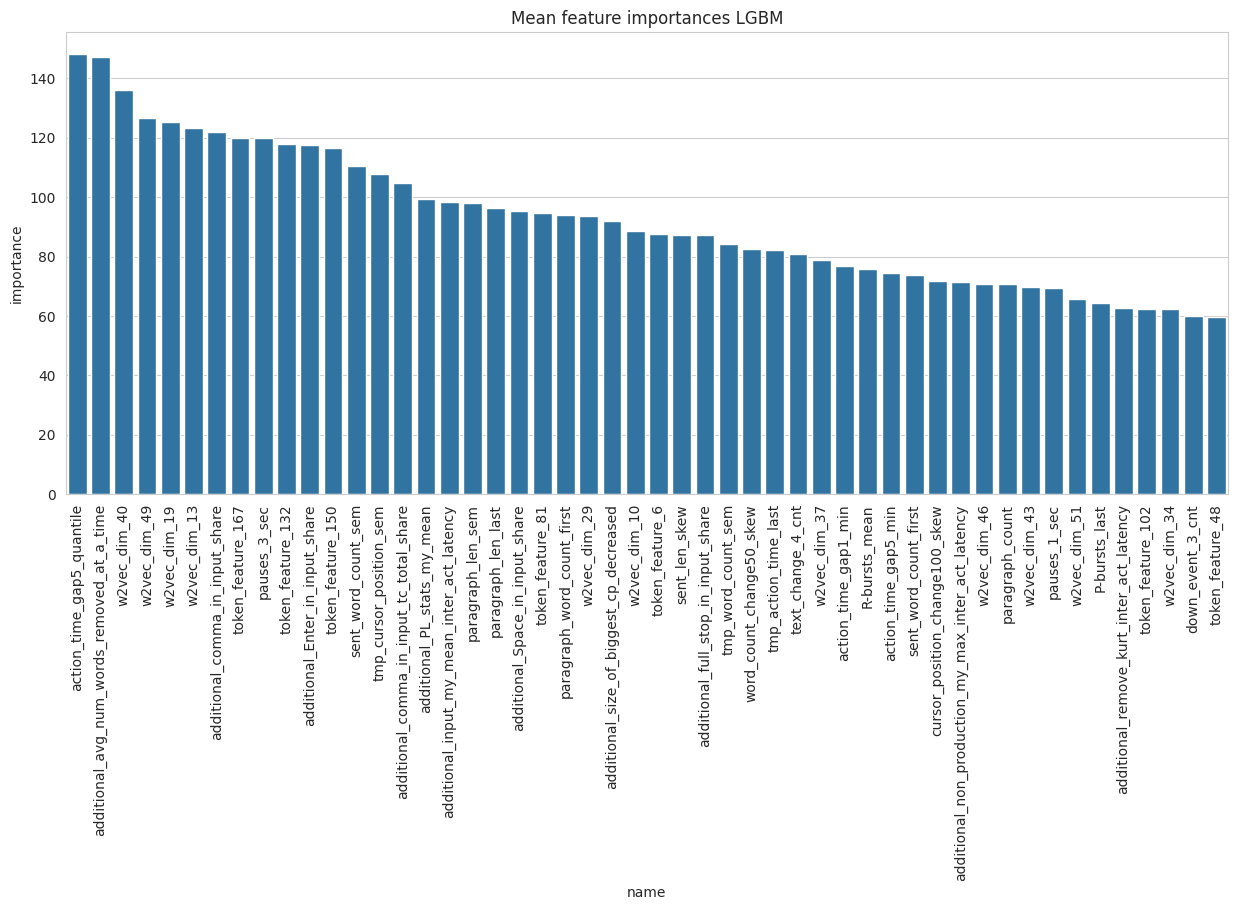

In [219]:
models_lgbm = nfold_dict_lgbm[f"models_lgbm_{cnfg.seed}"]
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_lgbm]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(50), x="name", y="importance")
ax.set_title(f"Mean feature importances LGBM")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

### XGB

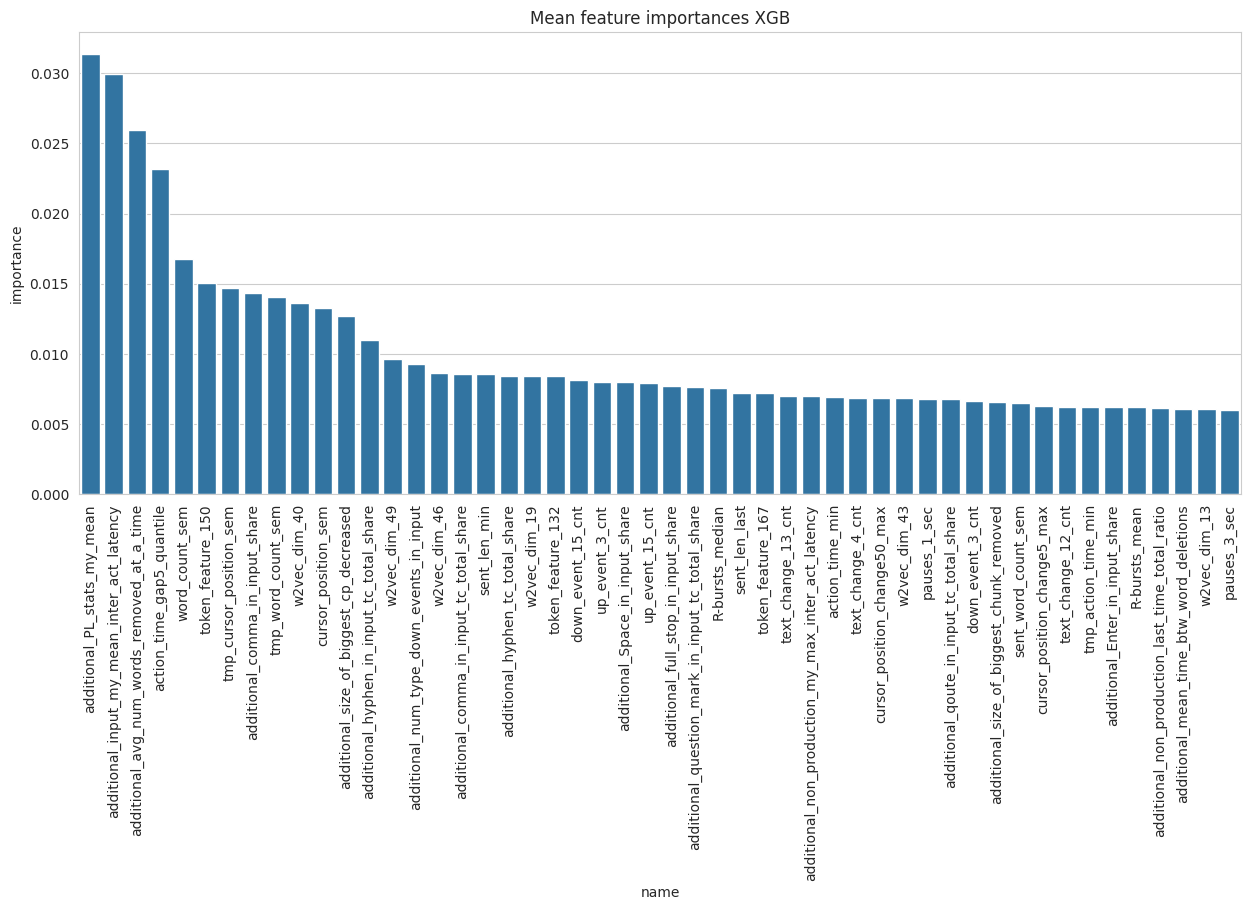

In [220]:
models_xgb = nfold_dict_xgb[f"models_xgb_{cnfg.seed}"]
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_xgb]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(50), x="name", y="importance")
ax.set_title(f"Mean feature importances XGB")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

### Catboost

### 42

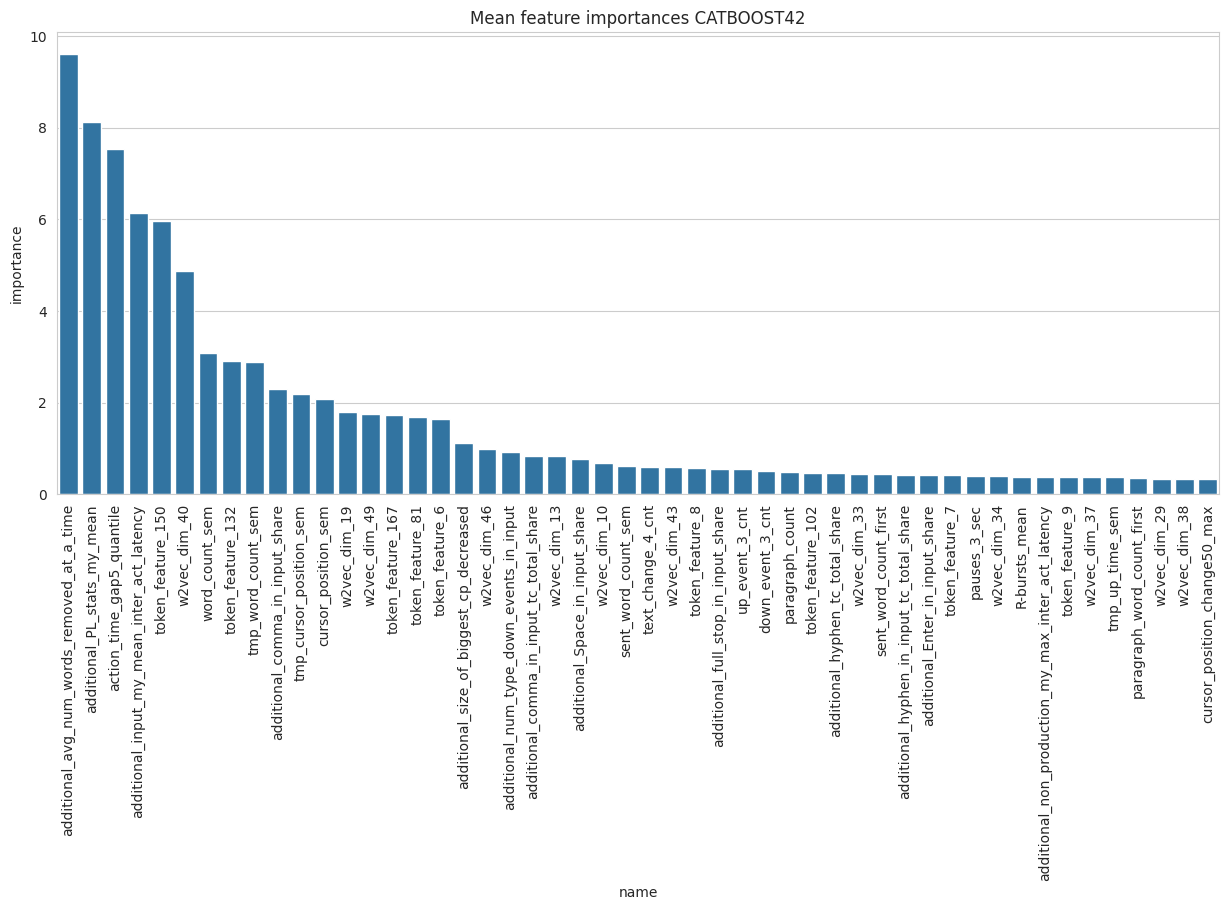

In [221]:
models_catboost_42 = nfold_dict_cat[f"models_catboost_{cnfg.seed}"]
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_catboost_42]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(50), x="name", y="importance")
ax.set_title(f"Mean feature importances CATBOOST42")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

### 43

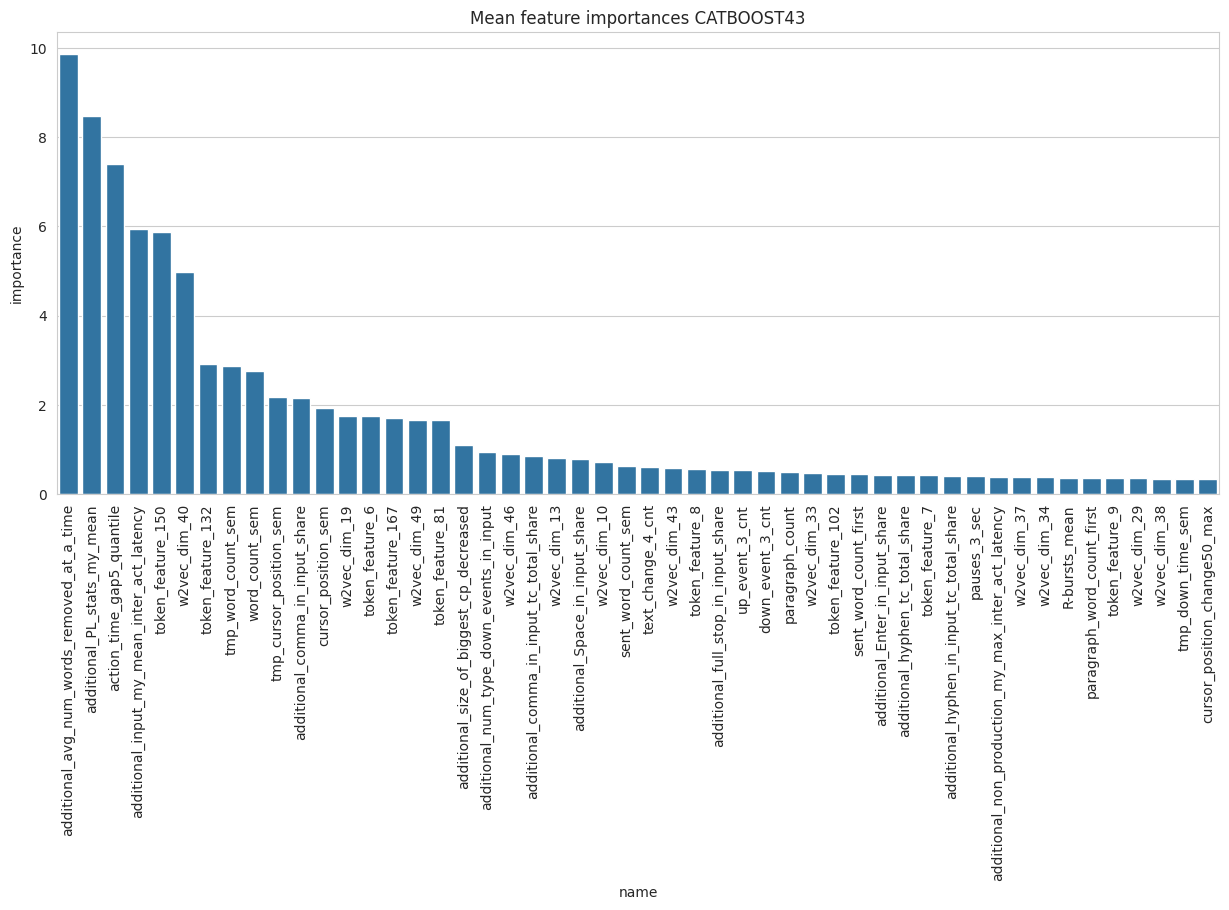

In [222]:
models_catboost_43 = nfold_dict_cat1[f"models_catboost_{cnfg.seed+1}"]
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_catboost_43]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(50), x="name", y="importance")
ax.set_title(f"Mean feature importances CATBOOST43")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

### 44

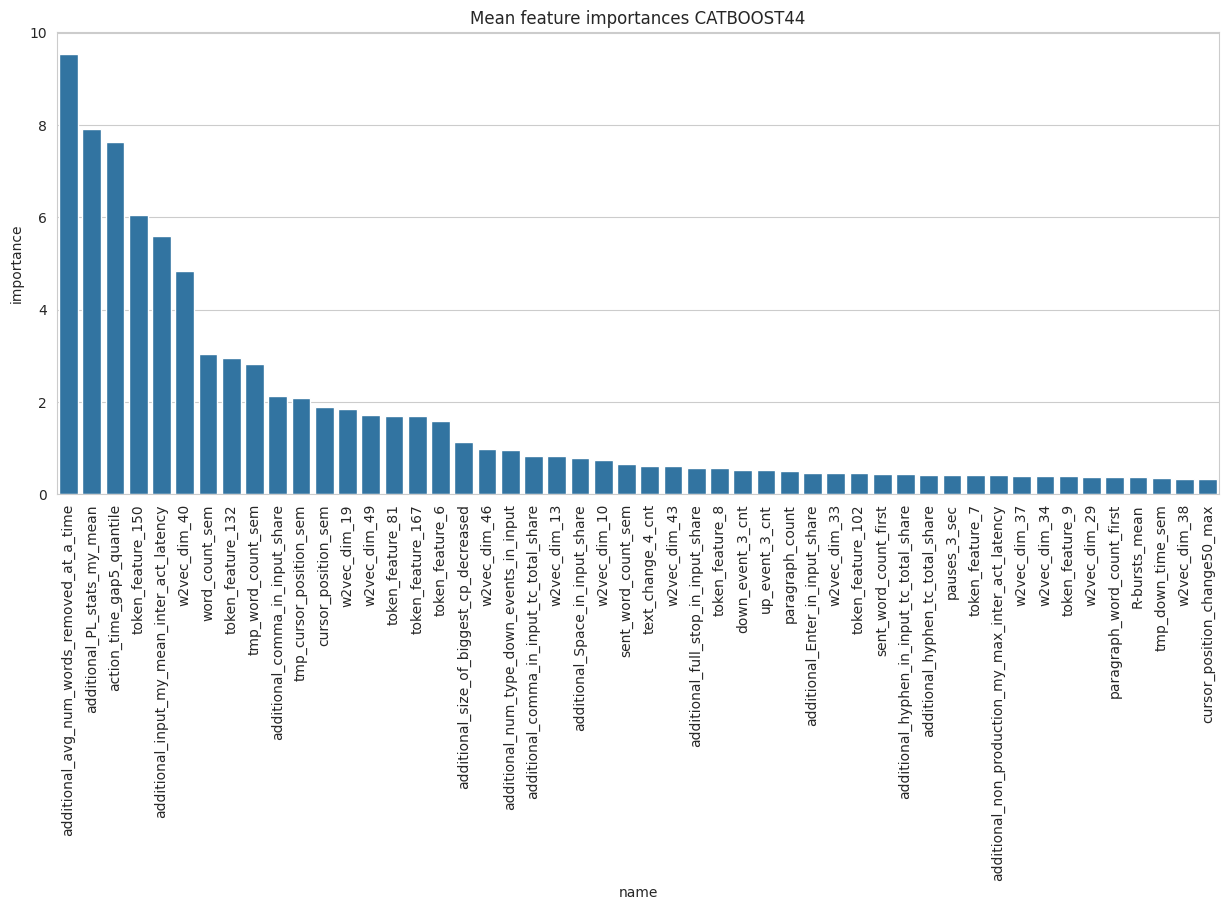

In [223]:
models_catboost_44 = nfold_dict_cat2[f"models_catboost_{cnfg.seed+2}"]
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_catboost_44]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(50), x="name", y="importance")
ax.set_title(f"Mean feature importances CATBOOST44")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()